In [1]:
# %pip install kafka-python pyspark==3.3.2 findspark

In [2]:
from kafka import KafkaConsumer, KafkaProducer
from kafka.consumer.fetcher import ConsumerRecord
import json
import asyncio
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import findspark
from pyspark.sql.functions import from_csv, col, avg, round as _round, countDistinct, approx_count_distinct
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
findspark.init(os.environ["SPARK_HOME"])

In [4]:
TOPIC = "KafkaMusicStream"

In [5]:
consumer = KafkaConsumer(TOPIC, bootstrap_servers="localhost:9092", consumer_timeout_ms=5000)
producer = KafkaProducer(bootstrap_servers="localhost:9092")

In [6]:
async def run_consumer(consumer: KafkaConsumer):
    for msg in consumer:
        await asyncio.sleep(1)
        assert isinstance(msg, ConsumerRecord), "Invalid Type"
        print(json.loads(msg.value))
        
def run_producer(producer: KafkaProducer):
    with open("data/SpotifyFeatures.csv") as f:
        f.readline() # first line
        
        while((line := f.readline()) != ""):
            producer.send(TOPIC, line.encode())
        

In [7]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")
         .appName("KafkaSqlStream")
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0")
         .config("spark.sql.warehouse.dir", "spark-warehouse")  
         .config("spark.driver.memory", "4g")
         .enableHiveSupport()
         .getOrCreate())

spark.sparkContext.setLogLevel("WARN")
print("Spark started:", spark)


your 131072x1 screen size is bogus. expect trouble


25/11/07 13:04:11 WARN Utils: Your hostname, LAPTOP-IVV27U6L resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/07 13:04:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/omnissiah/SPARK/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/omnissiah/.ivy2/cache
The jars for the packages stored in: /home/omnissiah/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cdf944ad-c677-4487-820f-41c06889b903;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 460ms :: artifacts dl 20

25/11/07 13:04:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark started: <pyspark.sql.session.SparkSession object at 0x7dbbf1f37450>


In [8]:
# Read from Kafka
kafka_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", TOPIC) \
    .load()
    
schema = StructType([
    StructField("genre", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("track_id", StringType(), True),
    StructField("popularity", IntegerType(), True),
    StructField("acousticness", DoubleType(), True),
    StructField("danceability", DoubleType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("energy", DoubleType(), True),
    StructField("instrumentalness", DoubleType(), True),
    StructField("key", StringType(), True),
    StructField("liveness", DoubleType(), True),
    StructField("loudness", DoubleType(), True),
    StructField("mode", StringType(), True),
    StructField("speechiness", DoubleType(), True),
    StructField("tempo", DoubleType(), True),
    StructField("time_signature", StringType(), True),
    StructField("valence", DoubleType(), True)
])

In [9]:
try:
    csv_df = kafka_df.selectExpr("CAST(value AS STRING) as csv_value")
    parsed_df = csv_df.select(from_csv("csv_value", schema.simpleString()).alias("data")).select("data.*")

    parsed_df.createOrReplaceTempView("music_stream")

    sql_df = spark.sql("""
        SELECT genre, AVG(popularity) AS avg_popularity, COUNT(*) AS count
        FROM music_stream
        GROUP BY genre
    """)

    query = sql_df.writeStream \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", False) \
        .start()

    query.awaitTermination(10)
except:
    pass

25/11/07 13:04:19 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-8bfdbb8d-fa7c-458c-a807-ee7927b3d5d6. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:19 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----+--------------+-----+
|genre|avg_popularity|count|
+-----+--------------+-----+
+-----+--------------+-----+



25/11/07 13:04:29 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b2eba69d-f19e-4084-8f8c-30f919fccdf7. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:29 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/11/07 13:04:29 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-e1b94cb2-e5d5-40cd-a1d9-2ac47a3b382a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:29 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/11/07 13:04:29 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-9fe56002-32c0-4c5a-b098-7655c4a80cd7. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:29 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/07 13:04:30 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-69a6681a-d2ba-4be4-82bc-74be760c4333. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:30 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not support

25/11/07 13:04:30 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-3714ee53-ceb6-4c7b-bff2-fea9078e3469. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:30 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/11/07 13:04:30 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-7f26c148-bfe4-4a7e-a31e-ade447cea945. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/07 13:04:30 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 1
-------------------------------------------
+-----------+-----------------+-----+
|genre      |avg_popularity   |count|
+-----------+-----------------+-----+
|Alternative|51.53076923076923|1300 |
+-----------+-----------------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+-----------+--------------+-----+
|genre      |avg_popularity|count|
+-----------+--------------+-----+
|Alternative|51.2475       |1600 |
+-----------+--------------+-----+

25/11/07 13:04:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


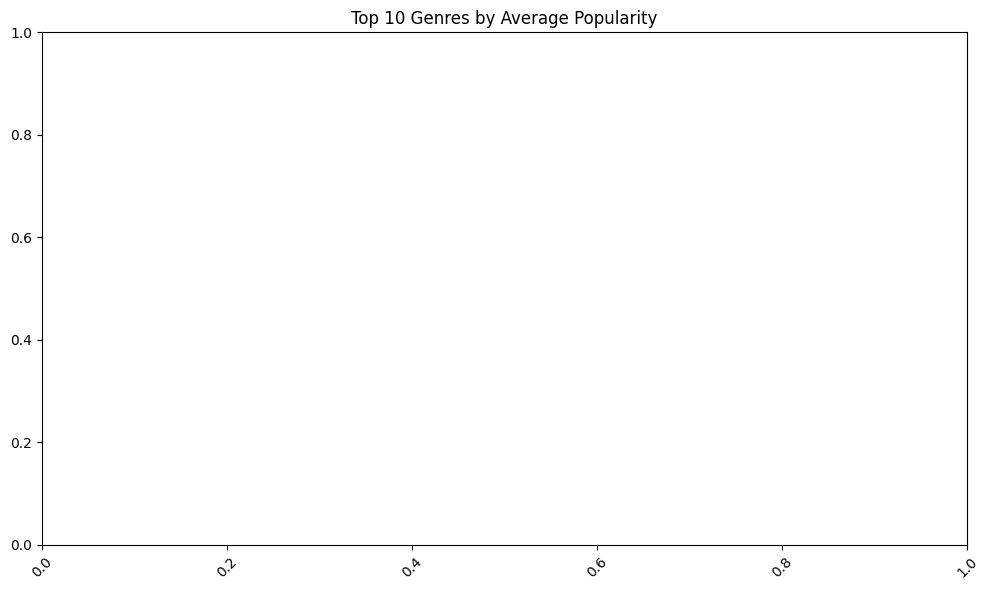

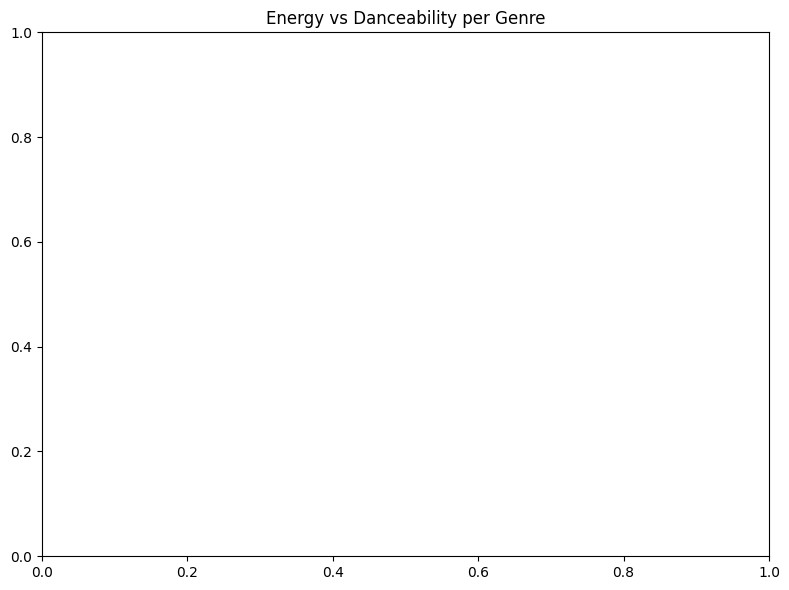

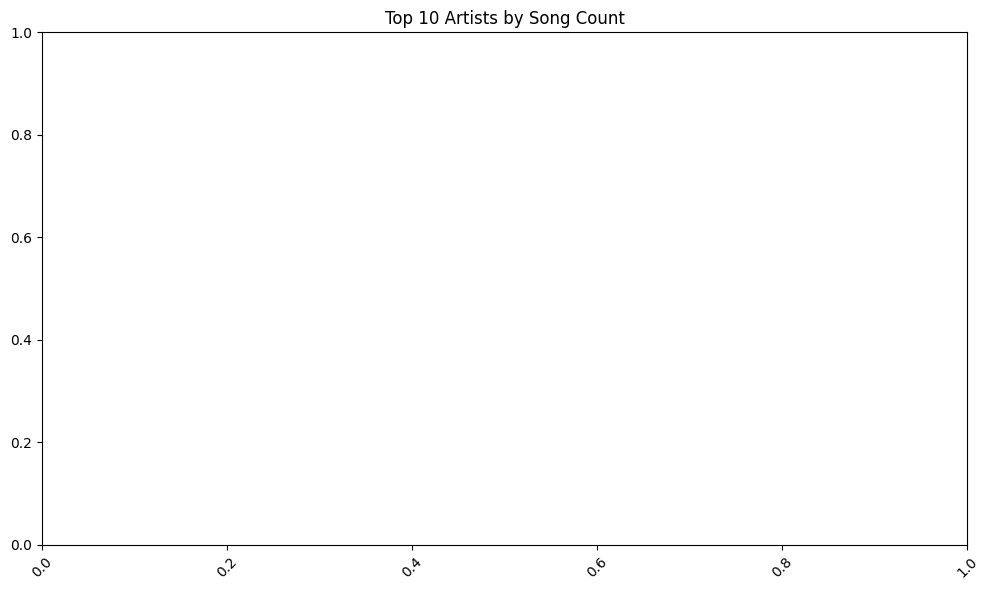

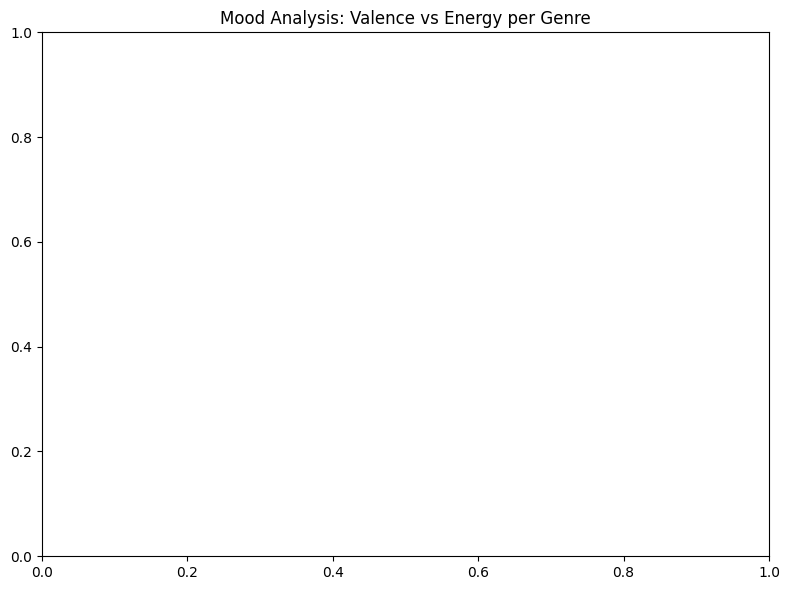

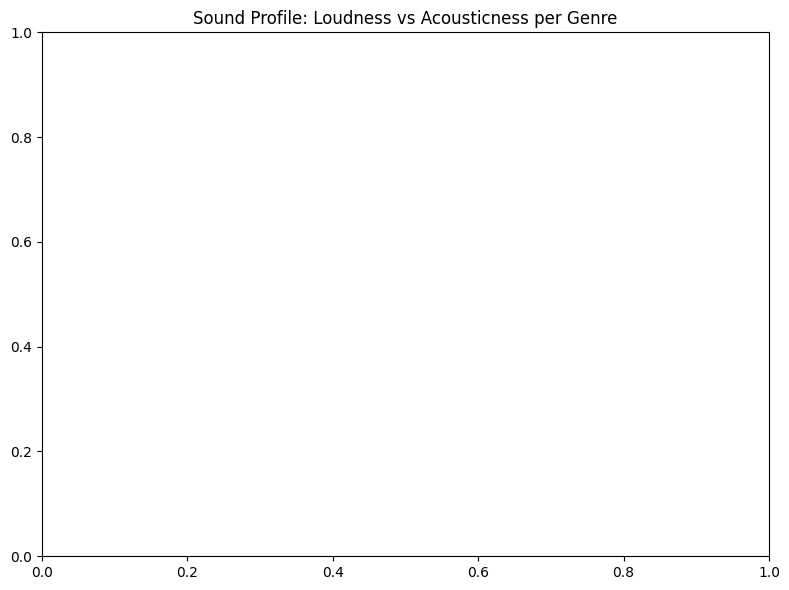

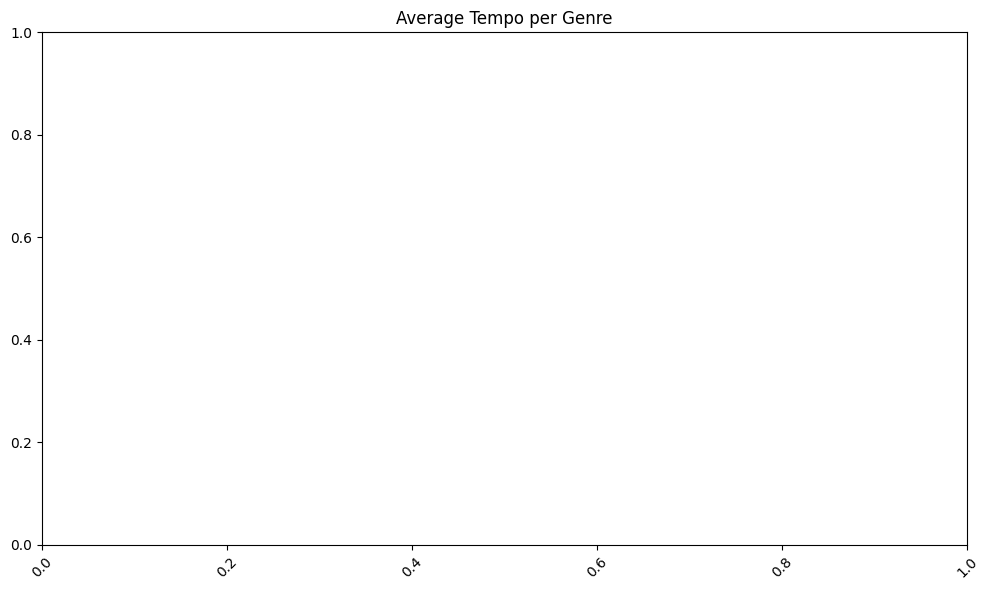

-------------------------------------------
Batch: 3
-------------------------------------------
+-----------+-----------------+-----+
|genre      |avg_popularity   |count|
+-----------+-----------------+-----+
|Alternative|51.22140672782874|1635 |
|Country    |39.28679245283019|265  |
+-----------+-----------------+-----+



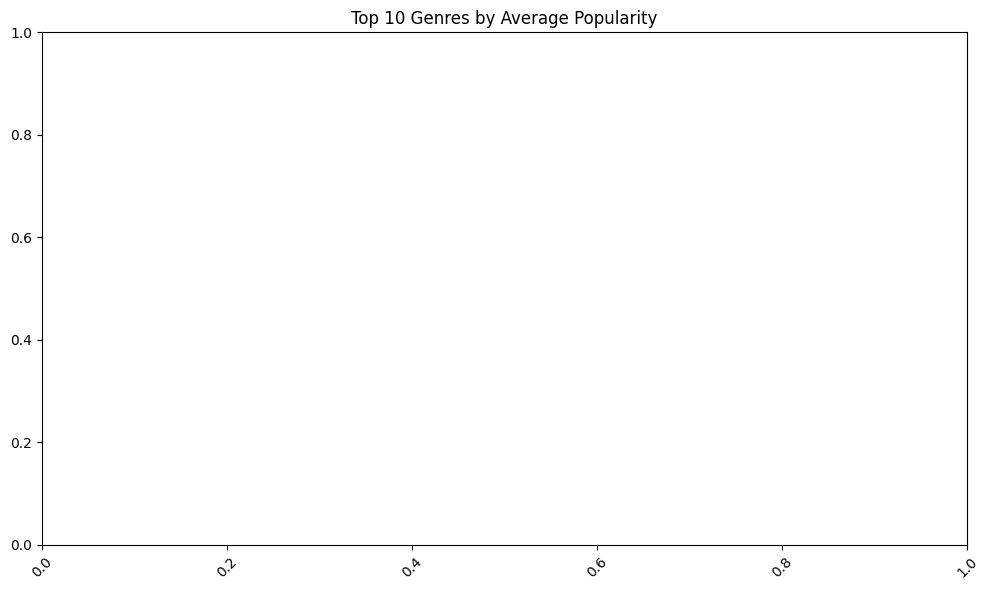

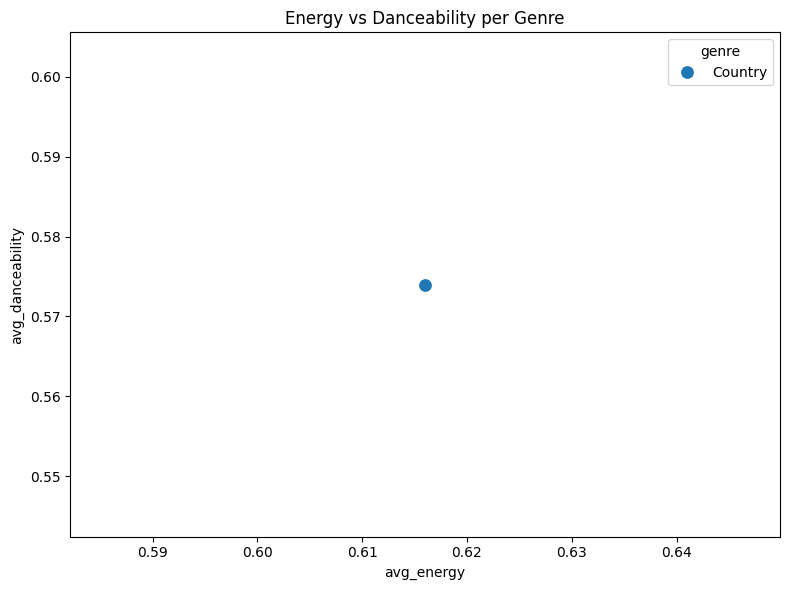

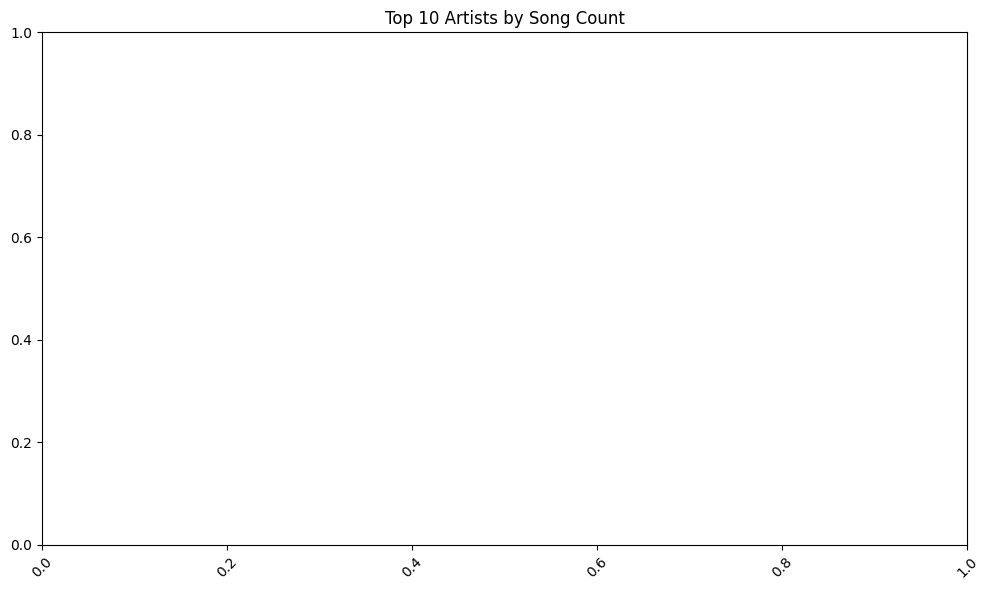

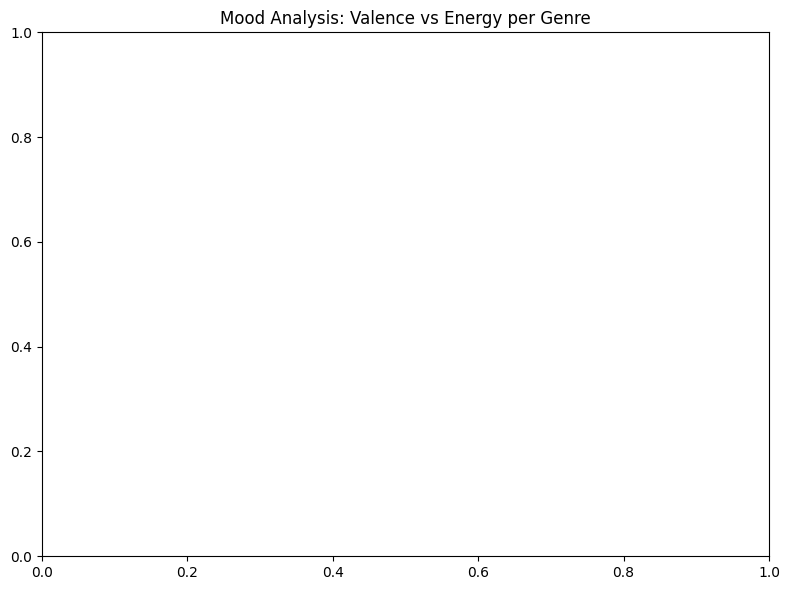

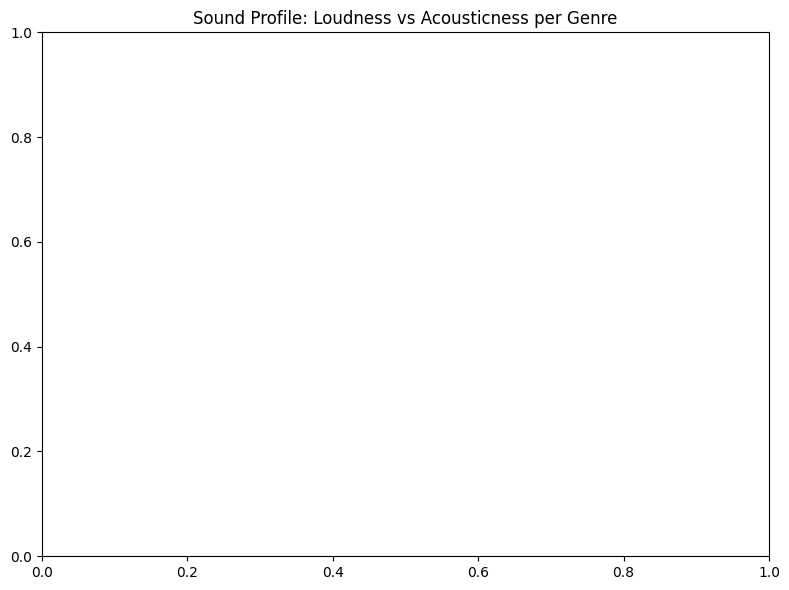

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: ge 30:>   (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


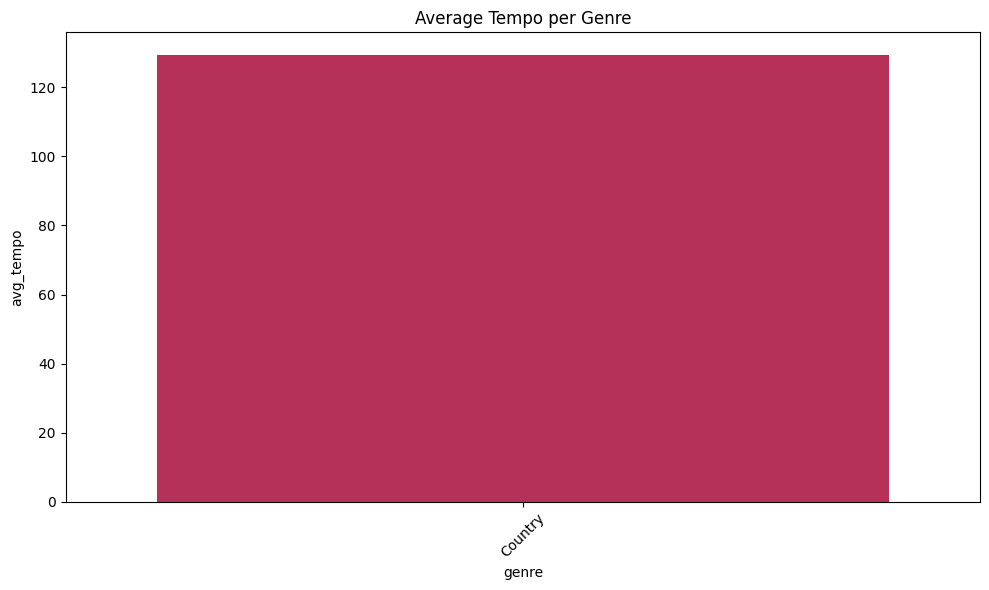

-------------------------------------------
Batch: 4
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|50.199164926931104|2395 |
|Country    |37.90726577437859 |2092 |
|Dance      |85.30088495575221 |113  |
+-----------+------------------+-----+



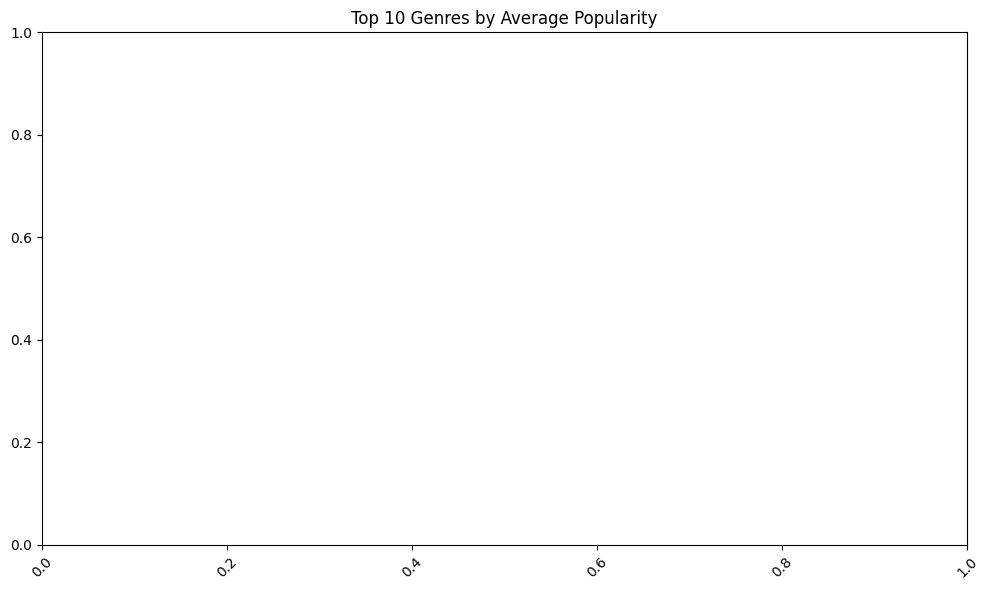

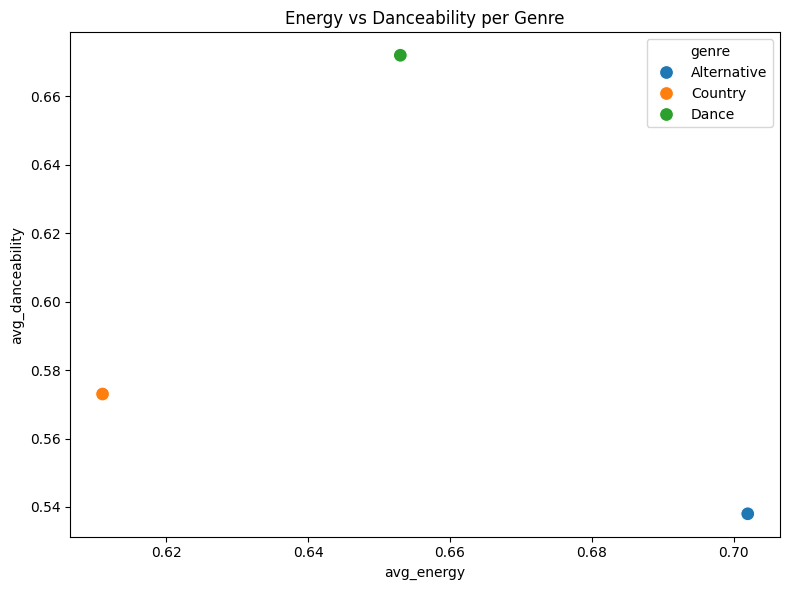

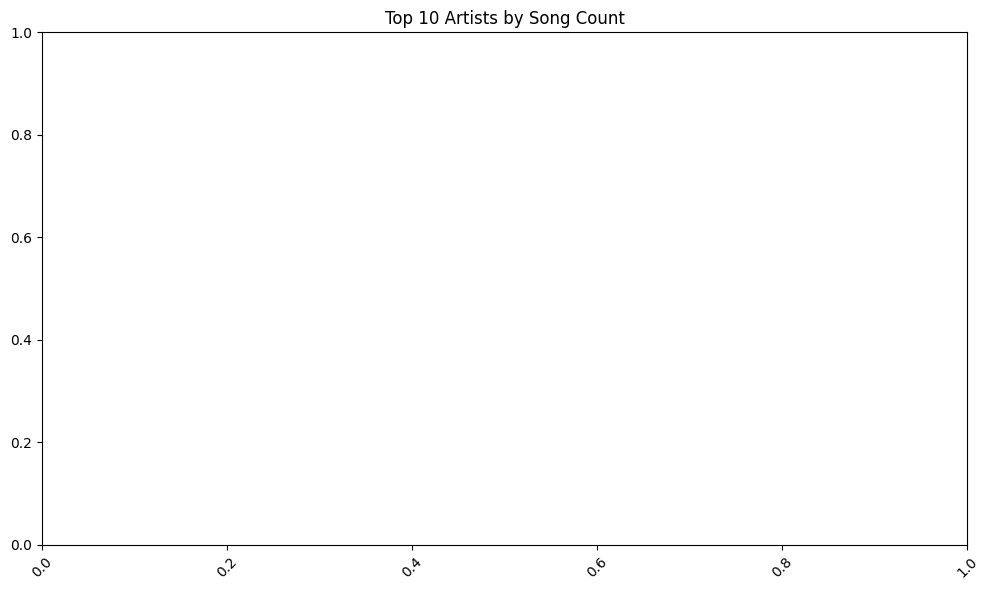

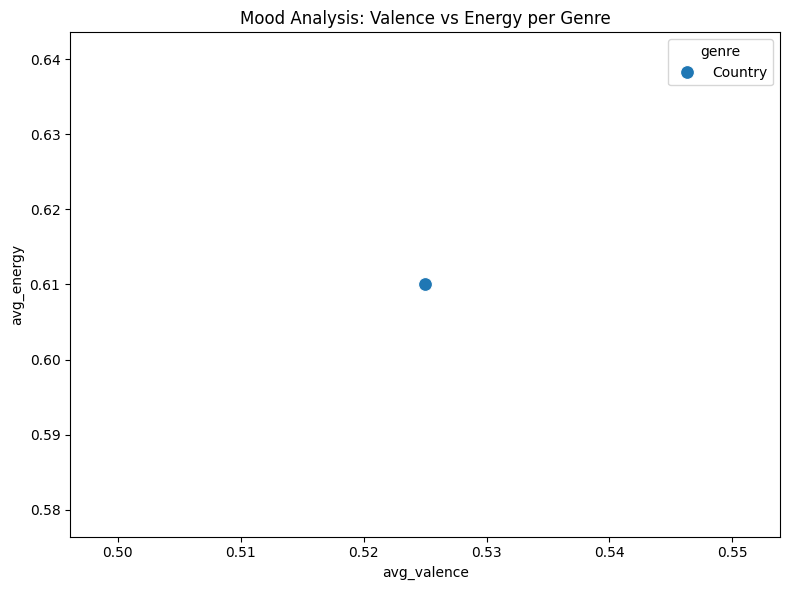

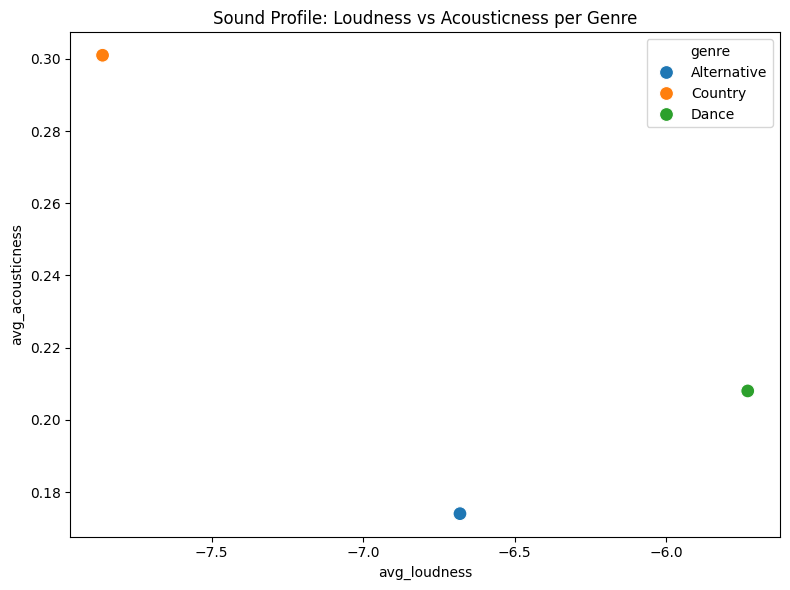

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: e 51:>(0 + 12) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


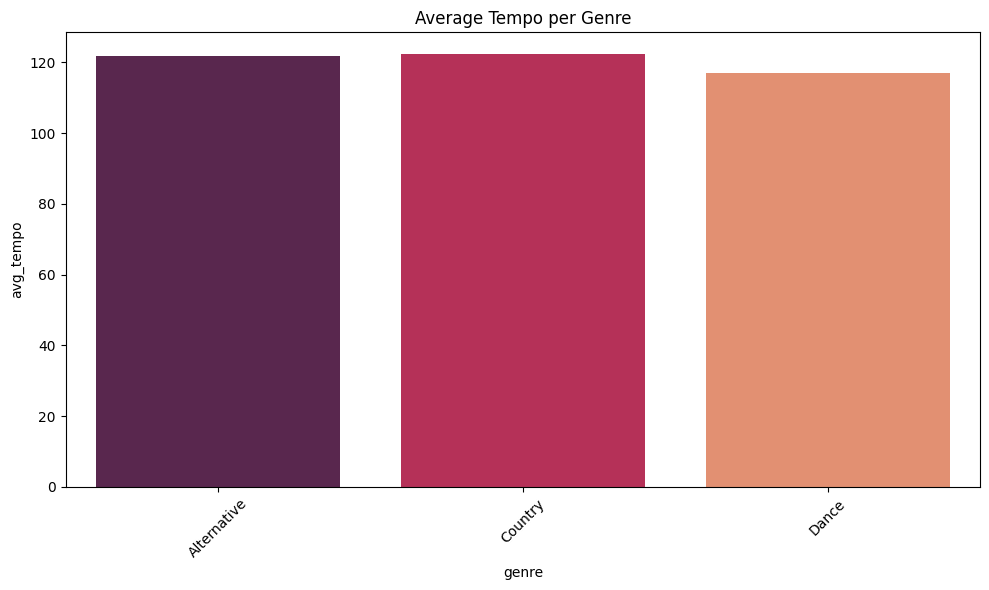

-------------------------------------------
Batch: 5
-------------------------------------------
+-----------+-----------------+-----+
|genre      |avg_popularity   |count|
+-----------+-----------------+-----+
|Alternative|48.79158134243458|4395 |
|Country    |37.90726577437859|2092 |
|Dance      |85.30088495575221|113  |
+-----------+-----------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: ge 60:>   (0 + 0) / 1]  

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


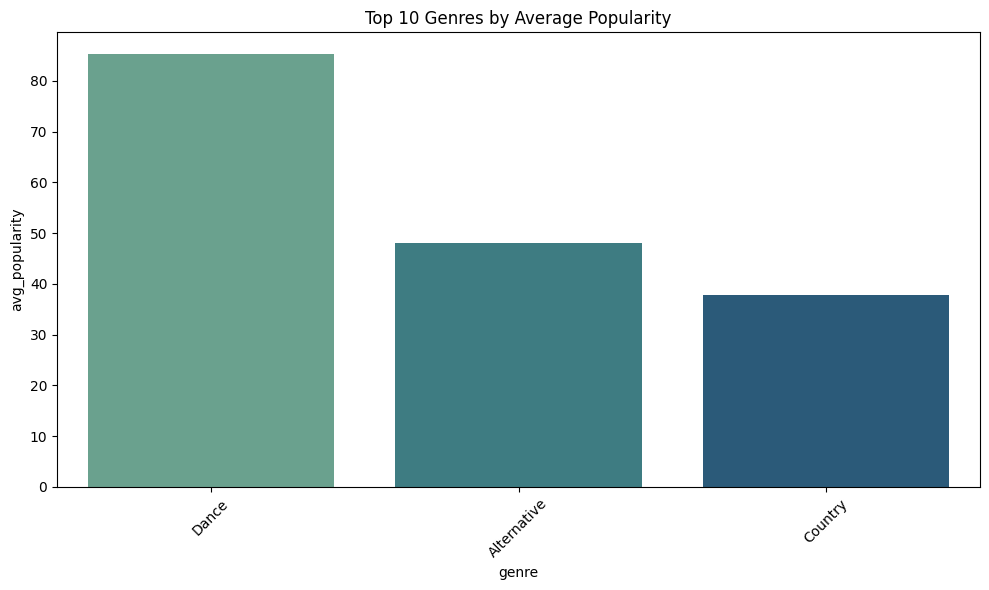

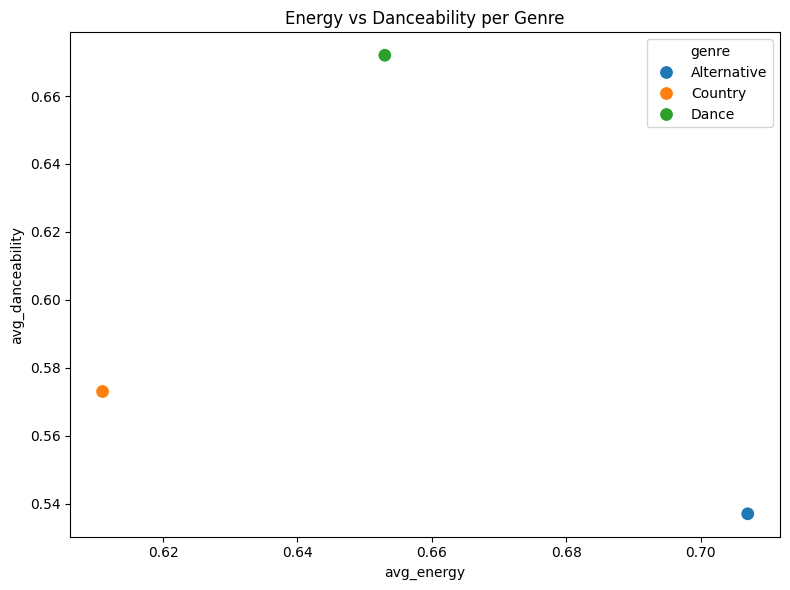

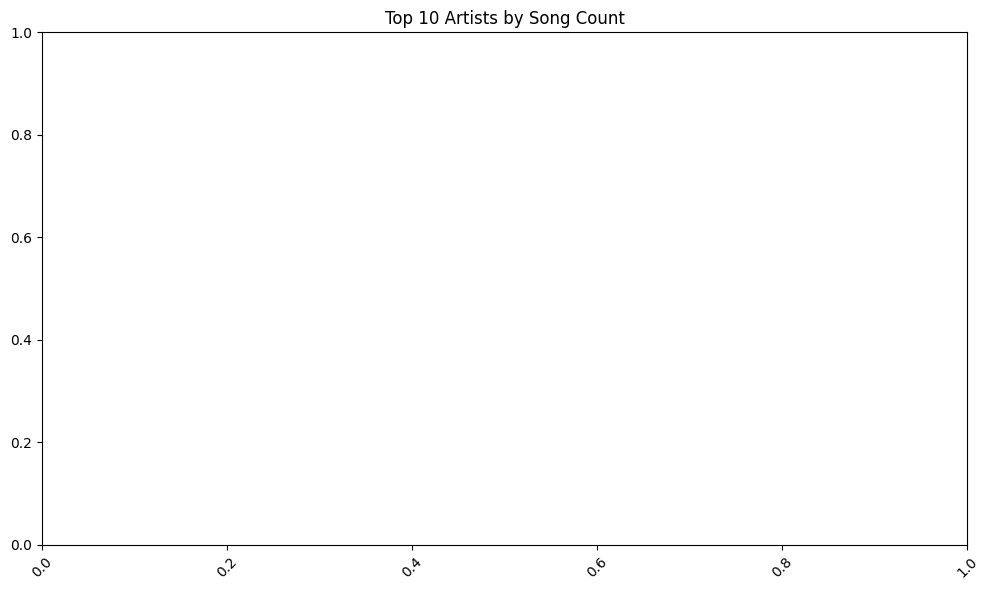

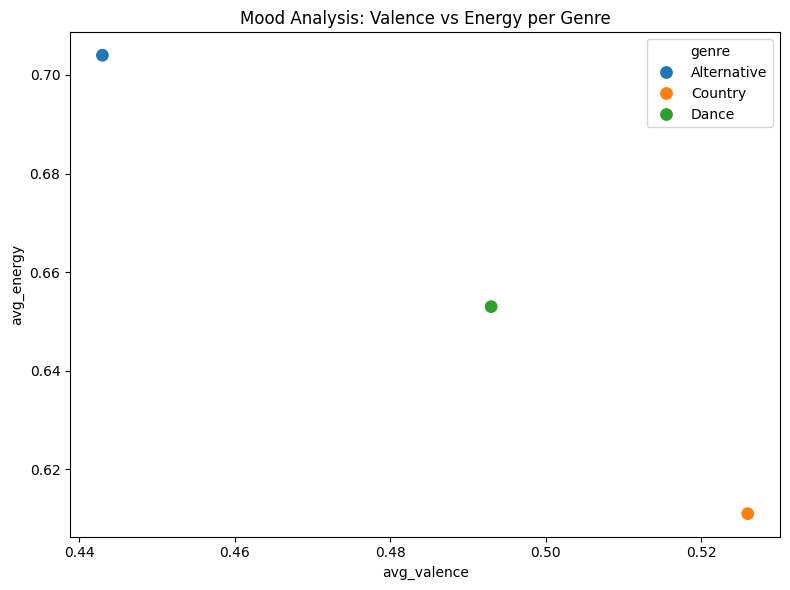

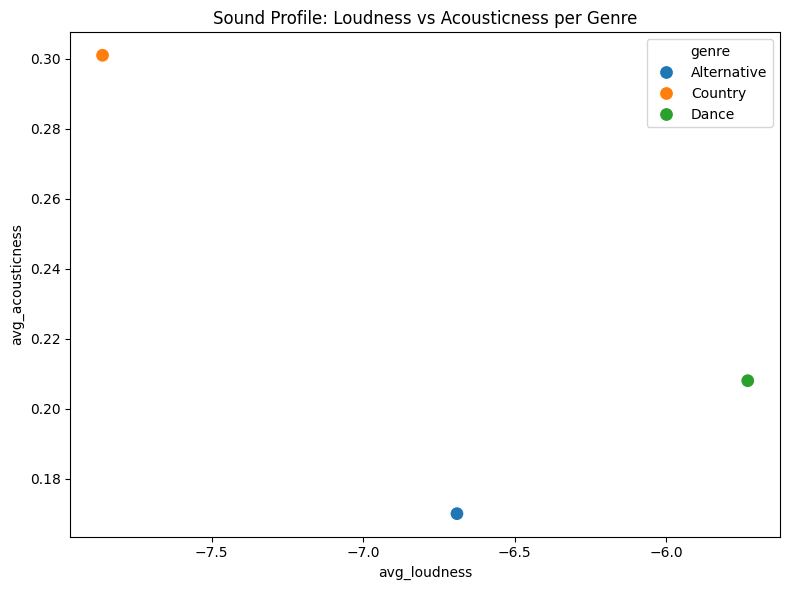

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


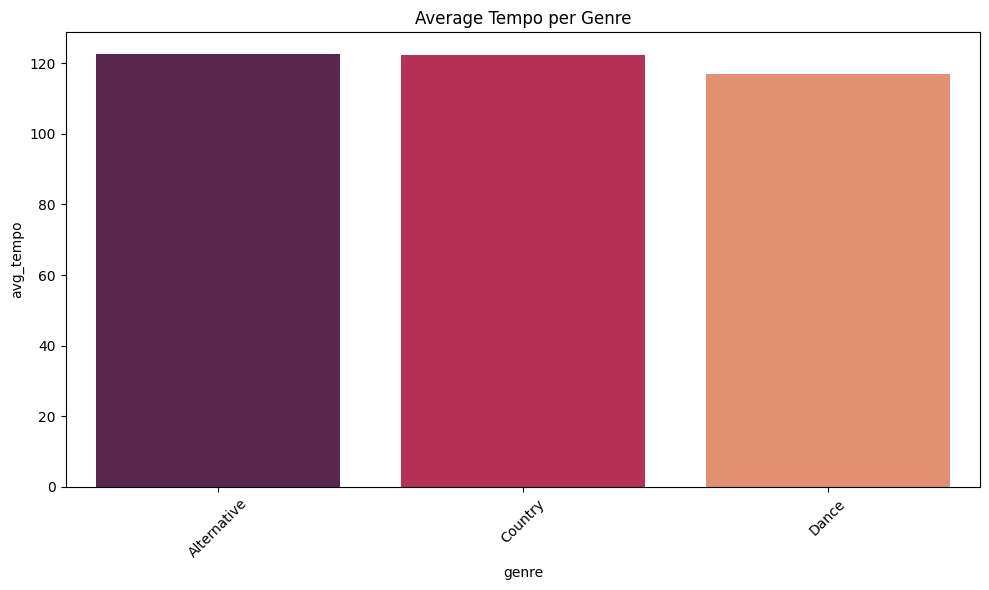

-------------------------------------------
Batch: 6
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Country    |37.90726577437859 |2092 |
|Dance      |73.47533092659447 |831  |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: ge 74:>   (0 + 0) / 1]  

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


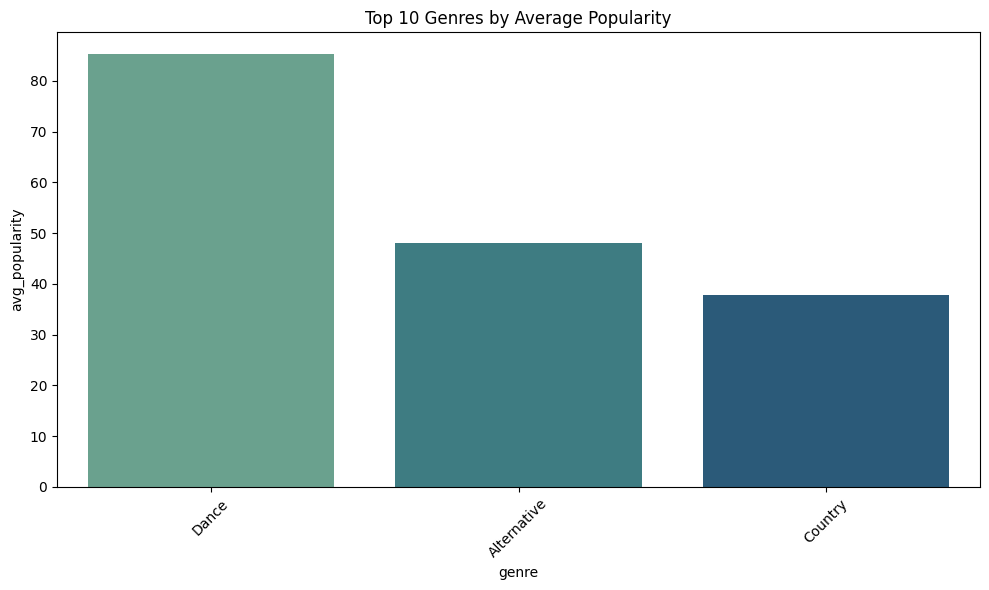

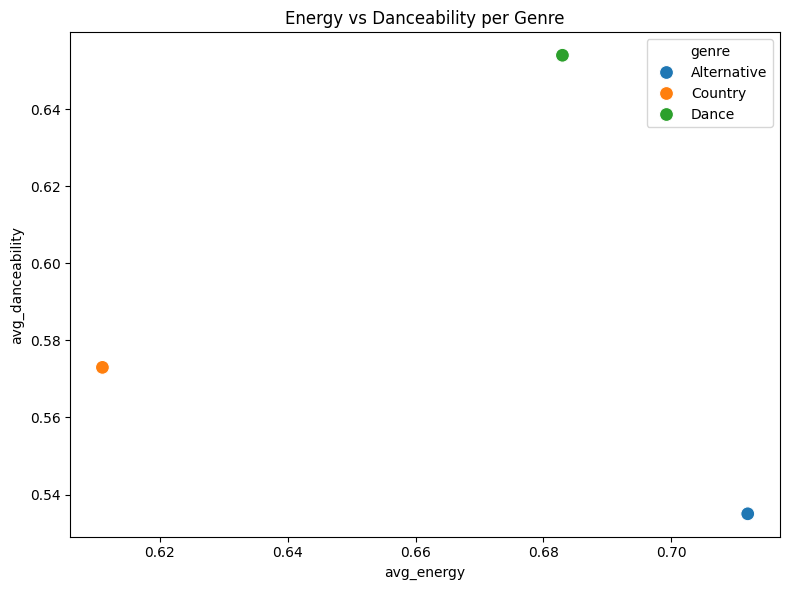

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: ge 74:>   (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


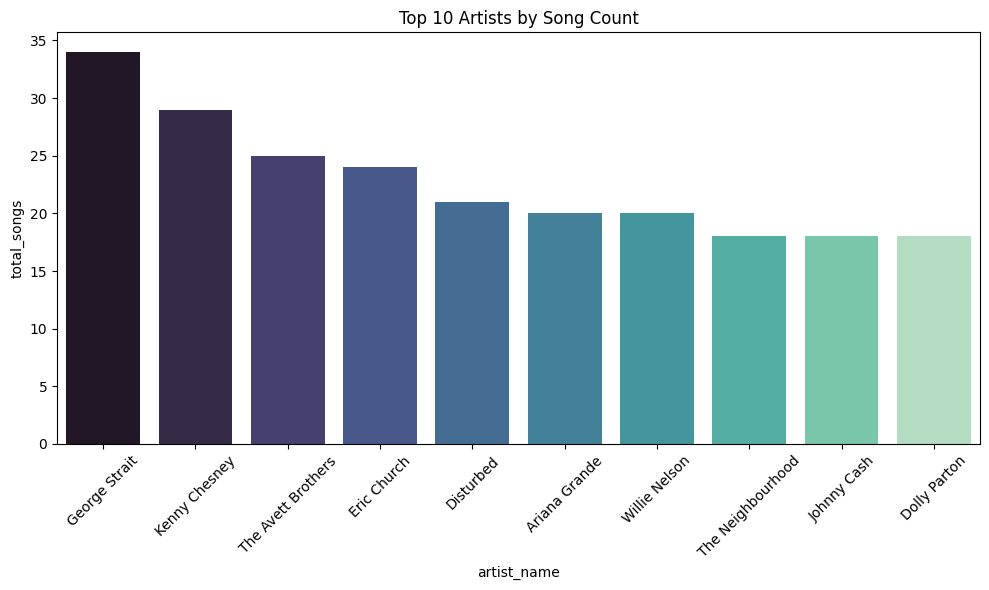

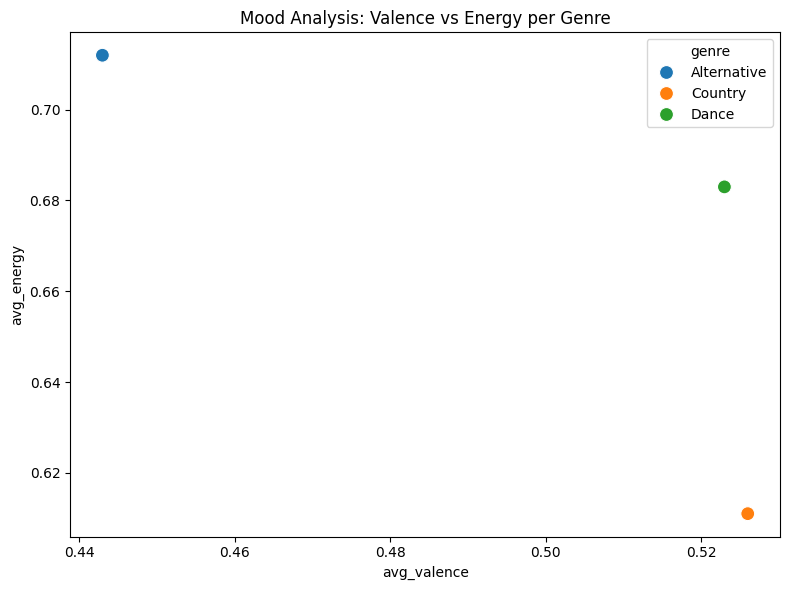

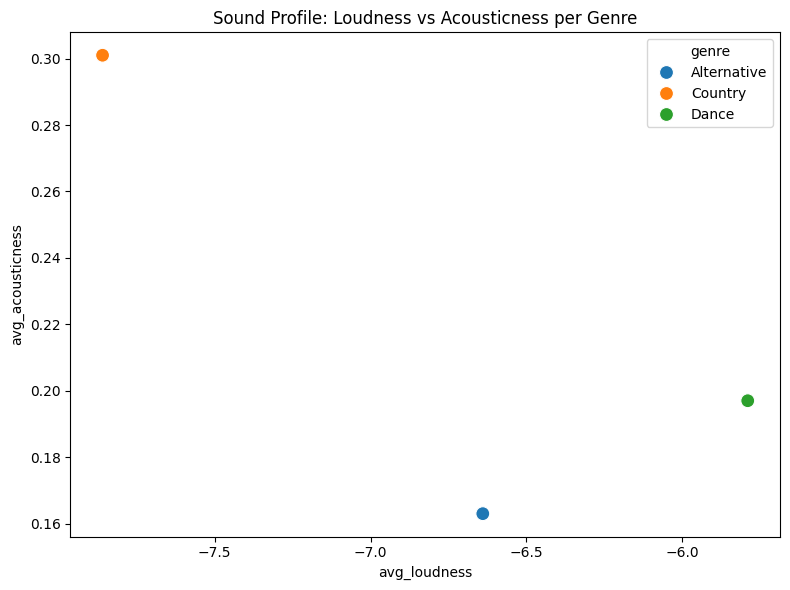

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


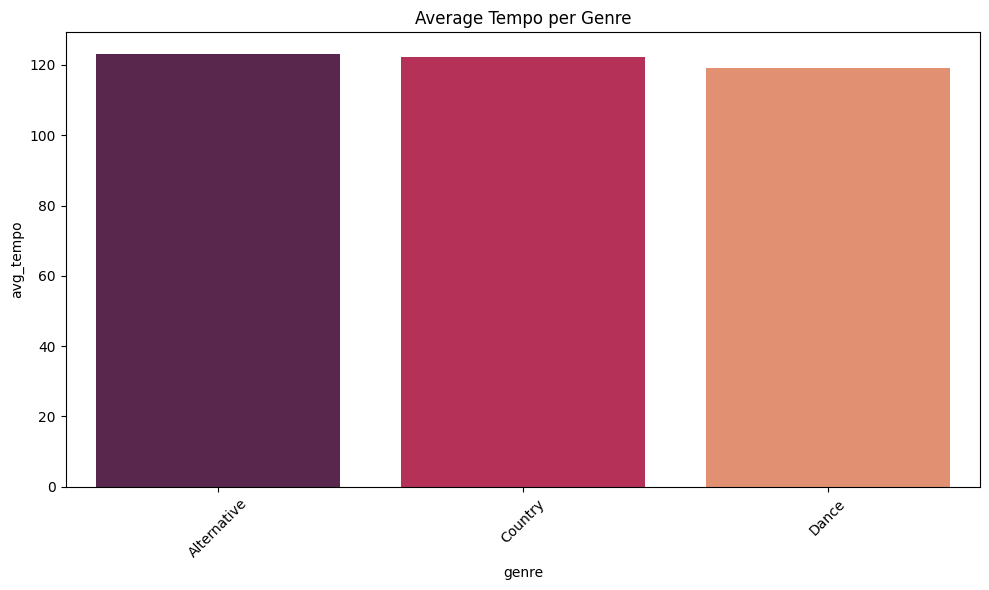

-------------------------------------------
Batch: 7
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Country    |37.90726577437859 |2092 |
|Dance      |66.07608324803822 |2931 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: age 90:>   (0 + 0) / 1] 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


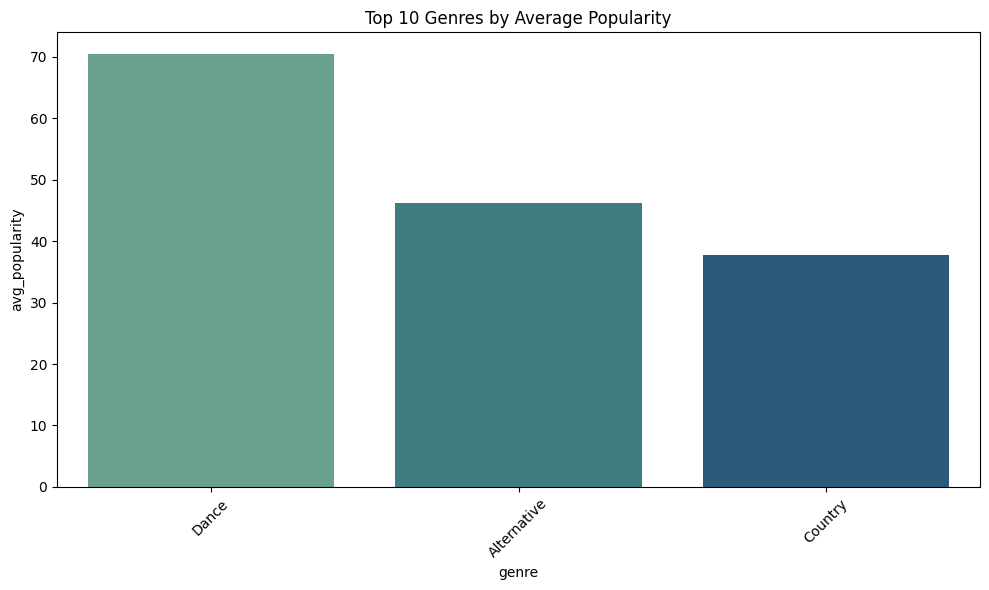

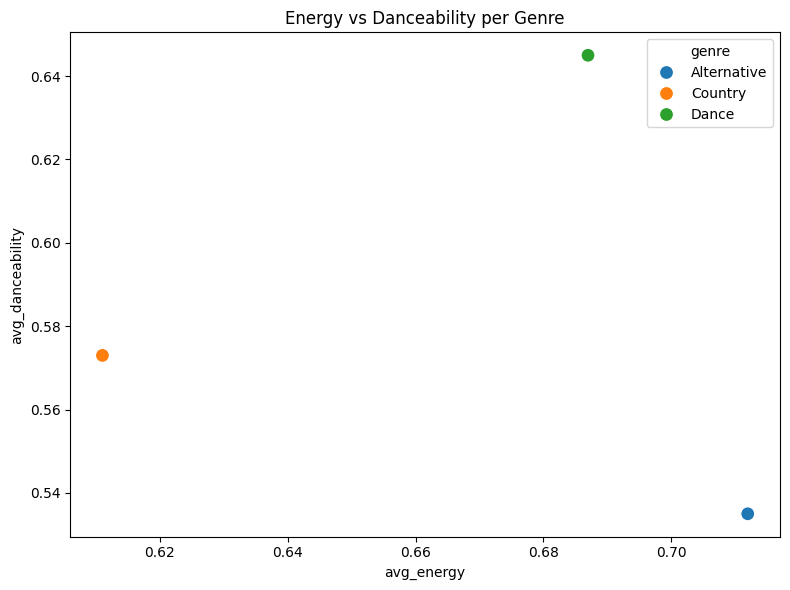

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


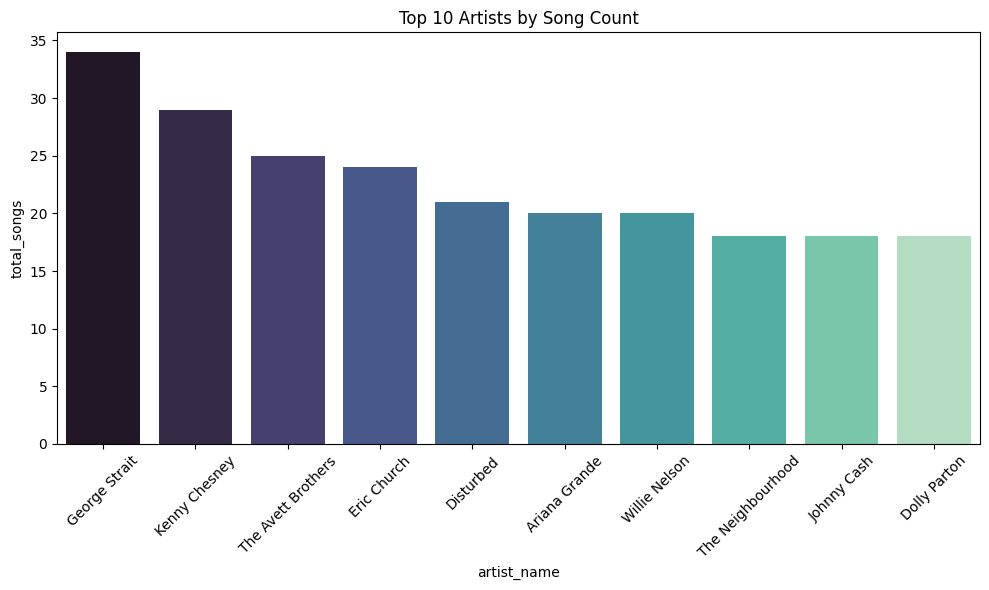

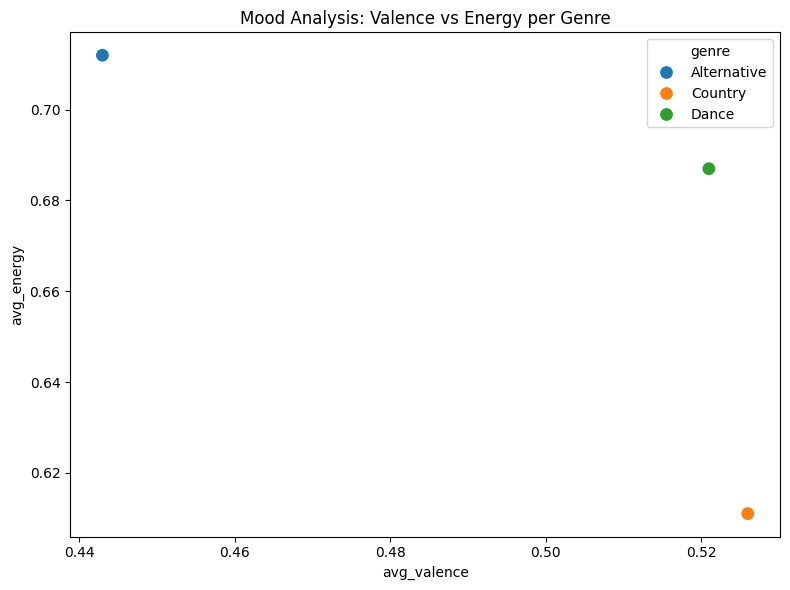

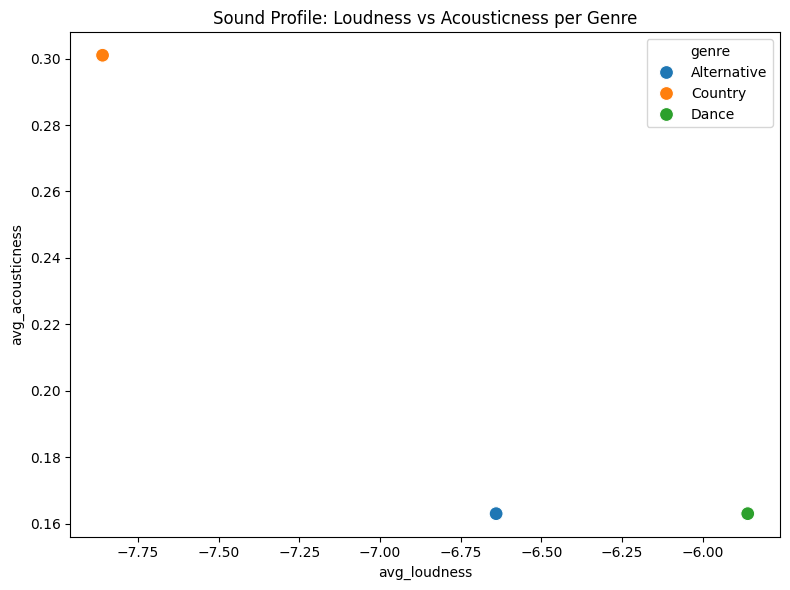

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


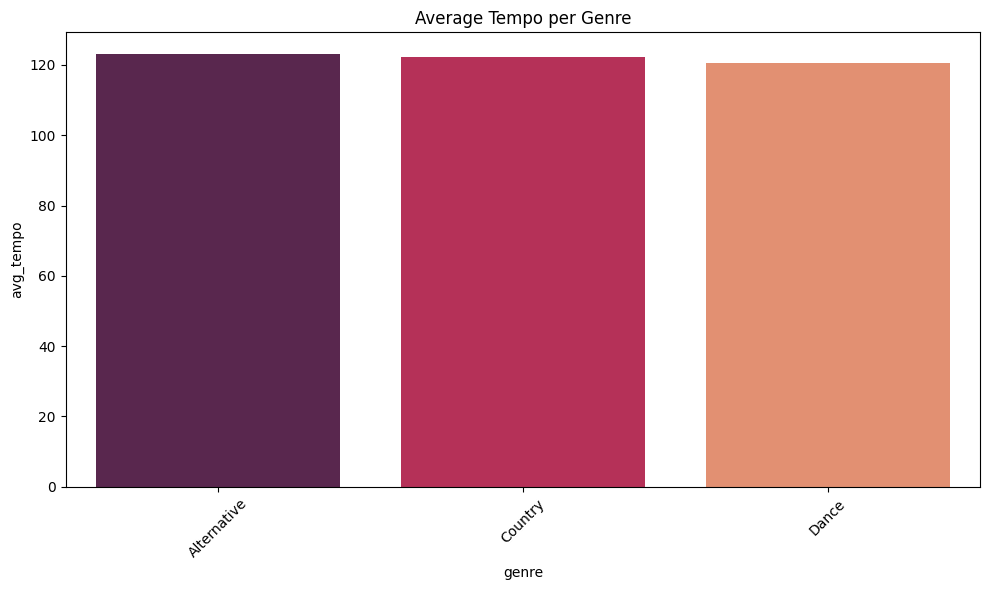

-------------------------------------------
Batch: 8
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Country    |37.90726577437859 |2092 |
|Dance      |62.95497682630766 |4531 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 104:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


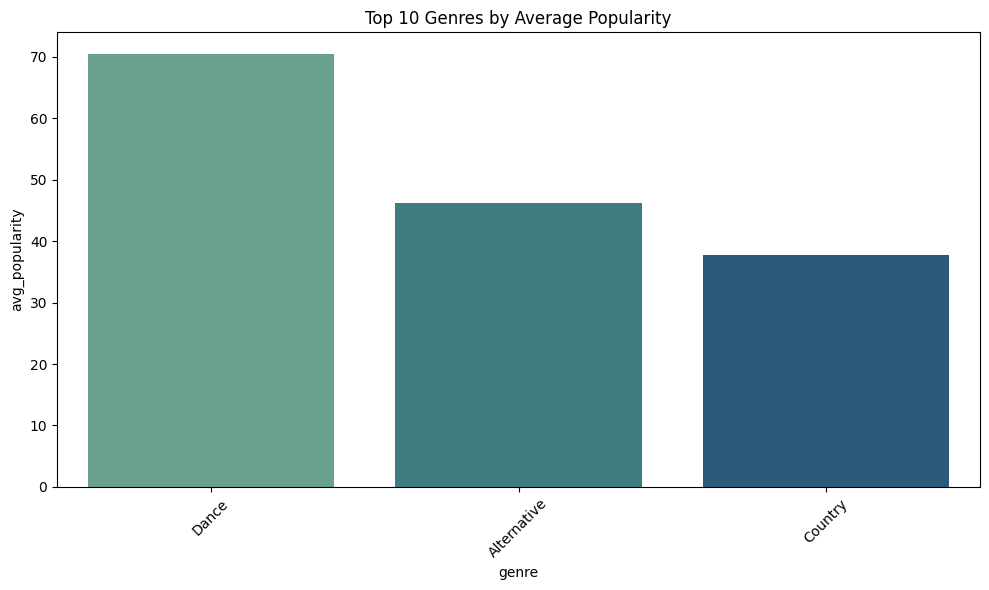

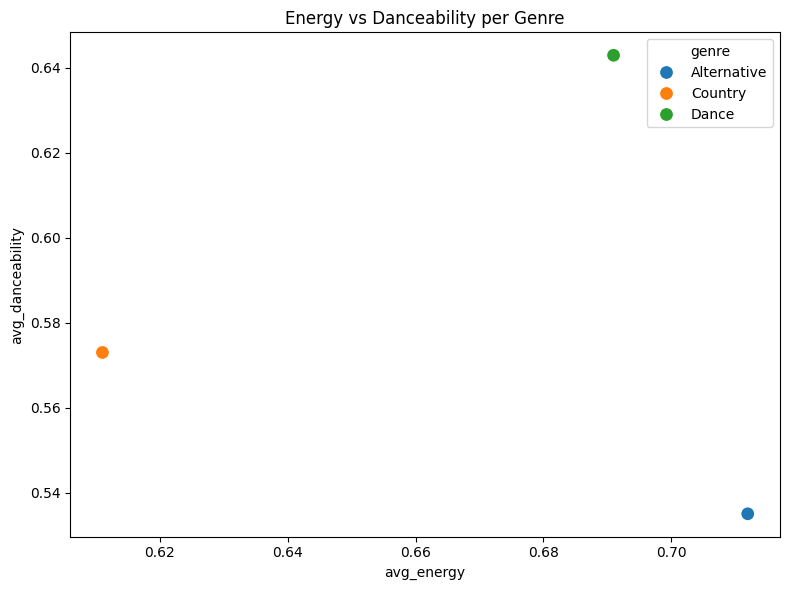

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


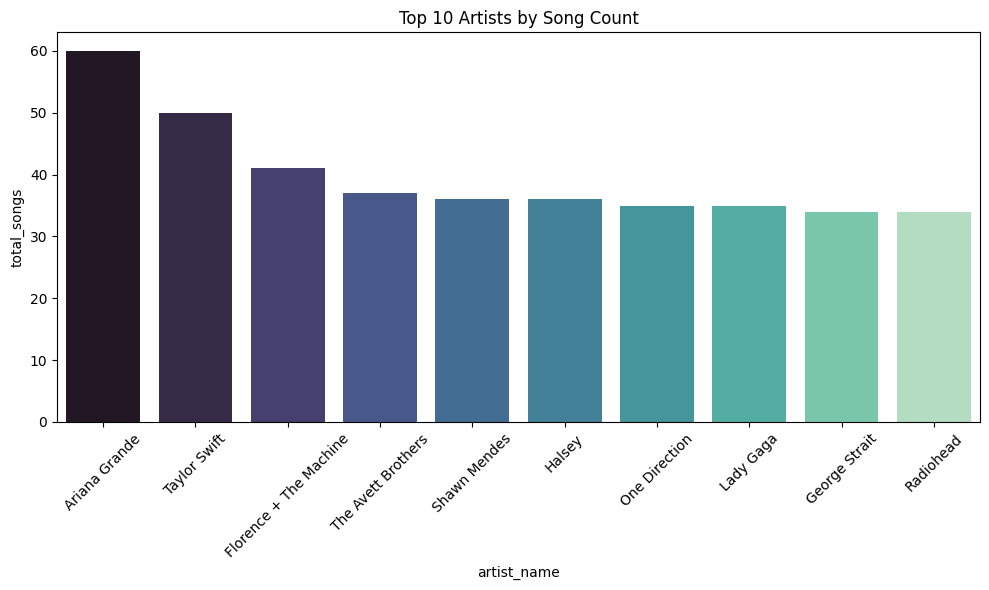

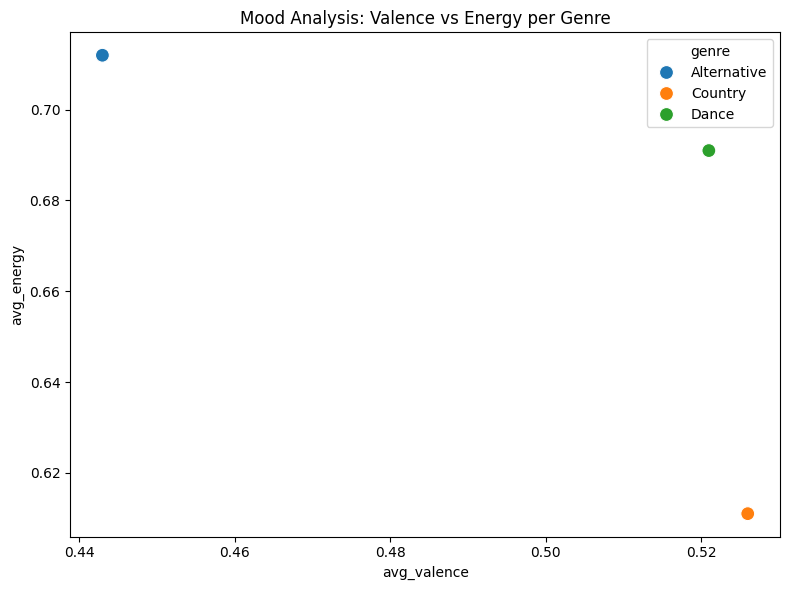

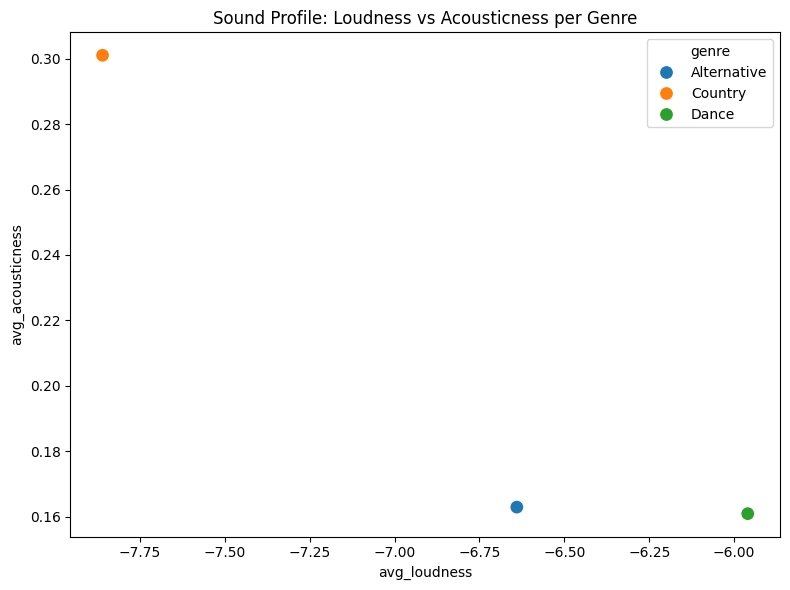

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: age 107:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


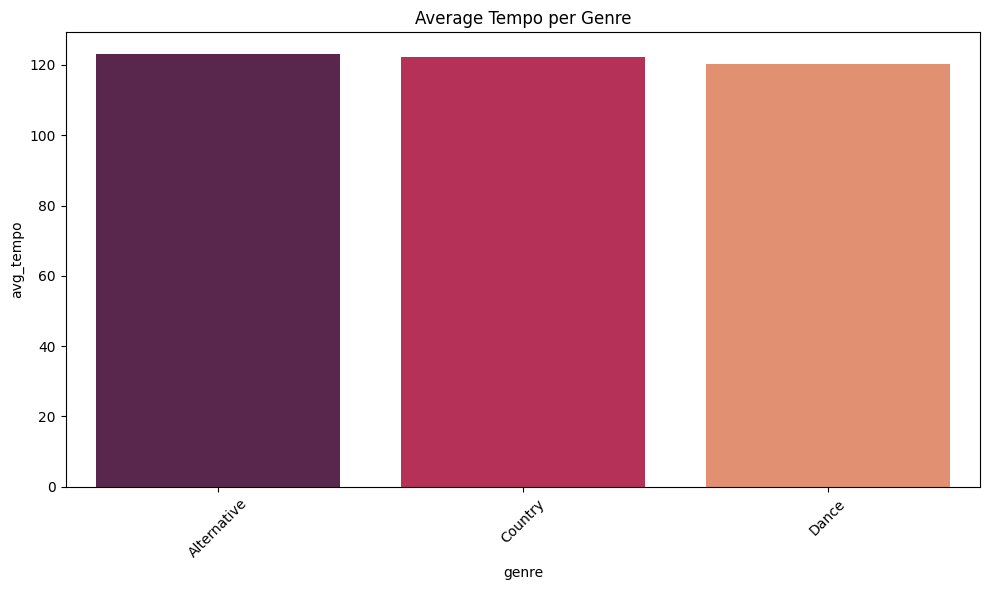

-------------------------------------------
Batch: 9
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Country    |37.90726577437859 |2092 |
|Dance      |60.043944265809216|6531 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 122:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


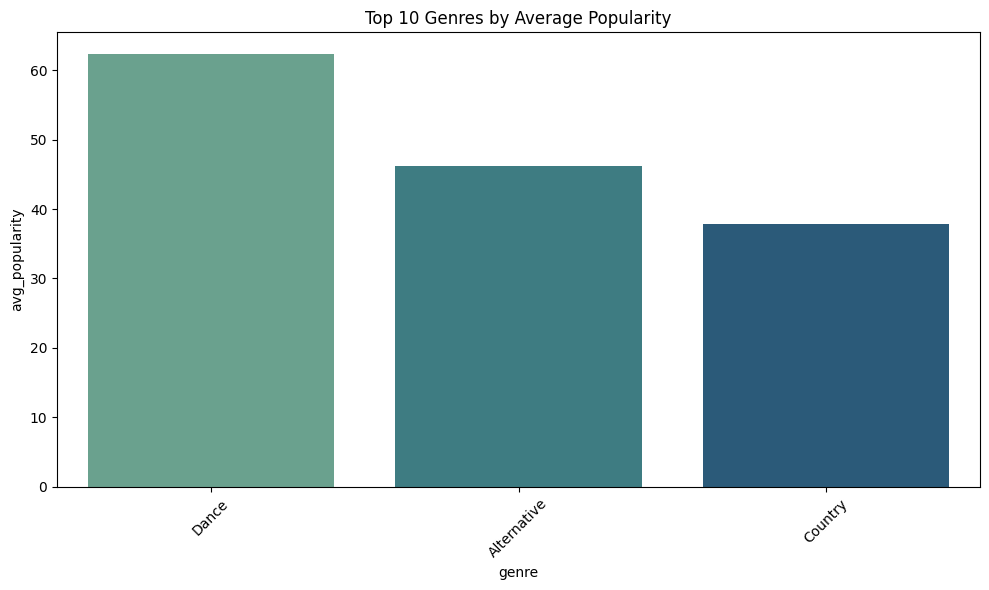

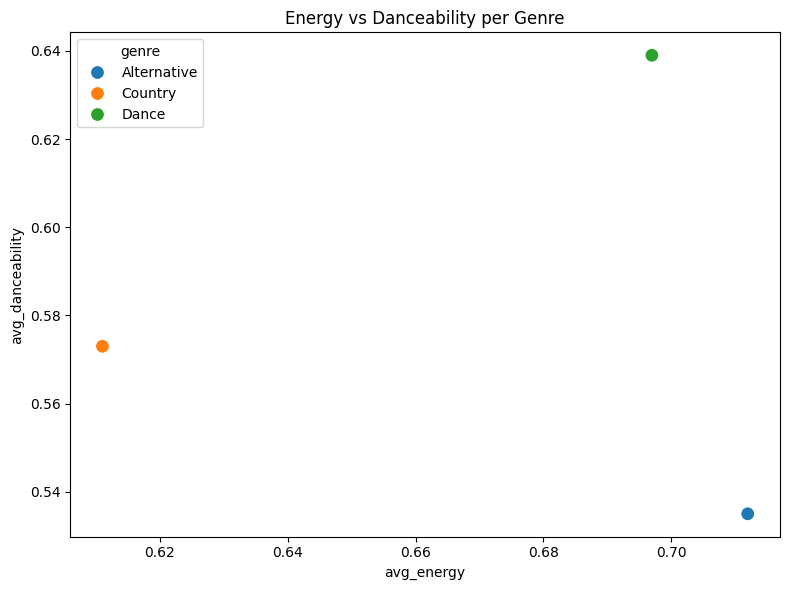

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


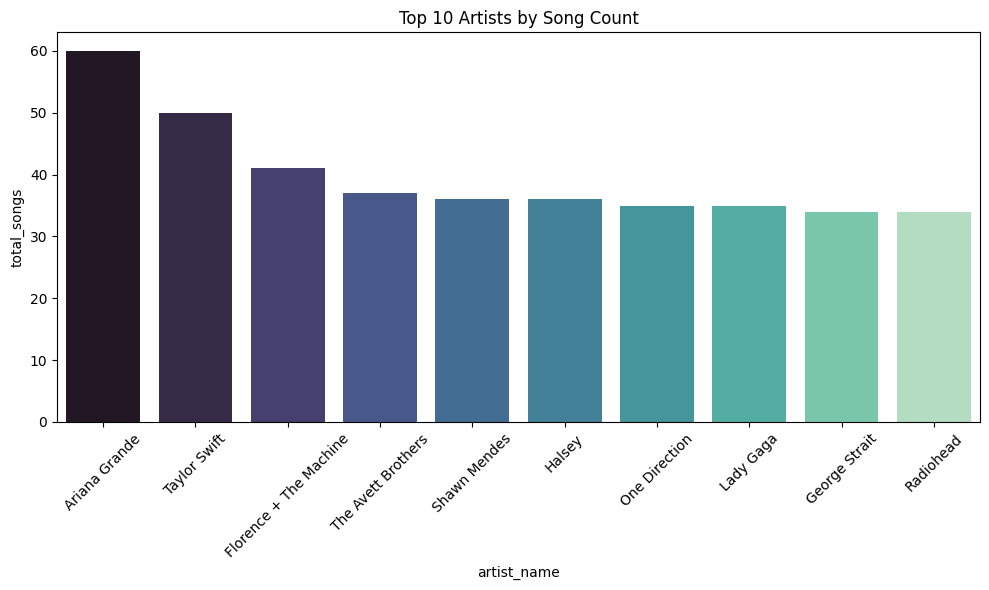

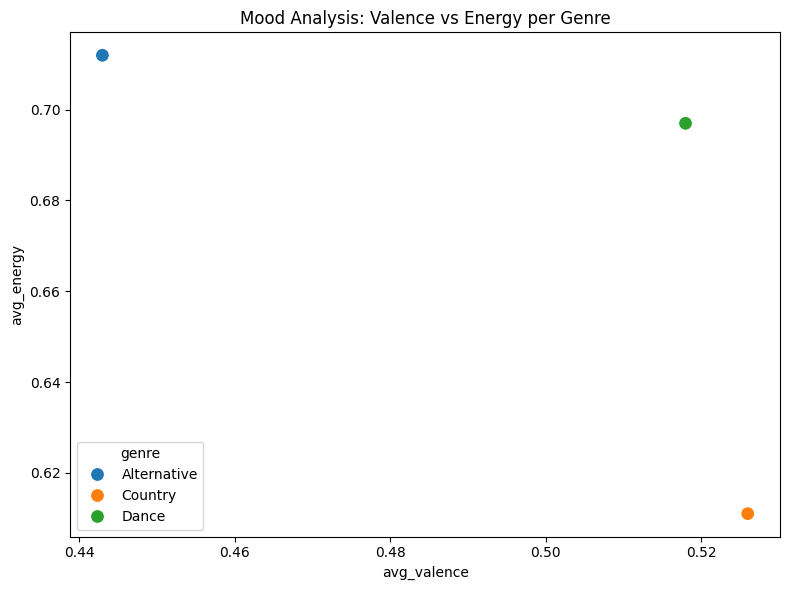

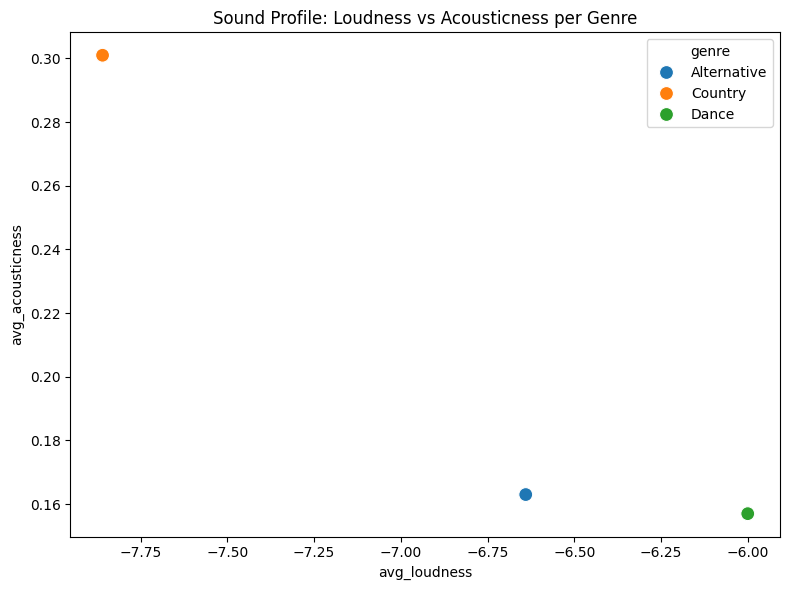

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


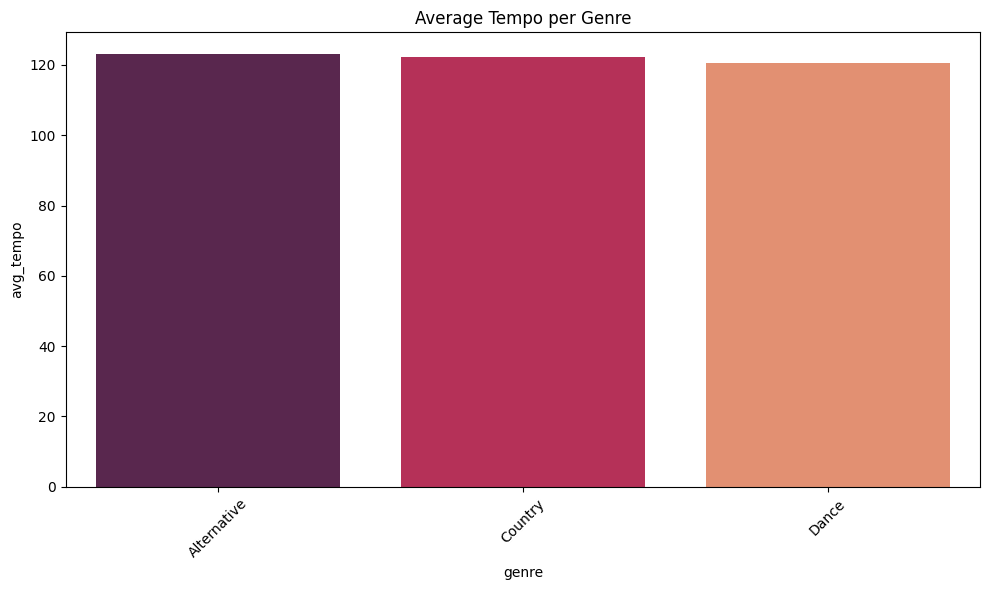

-------------------------------------------
Batch: 10
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.844733325233875|8231 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


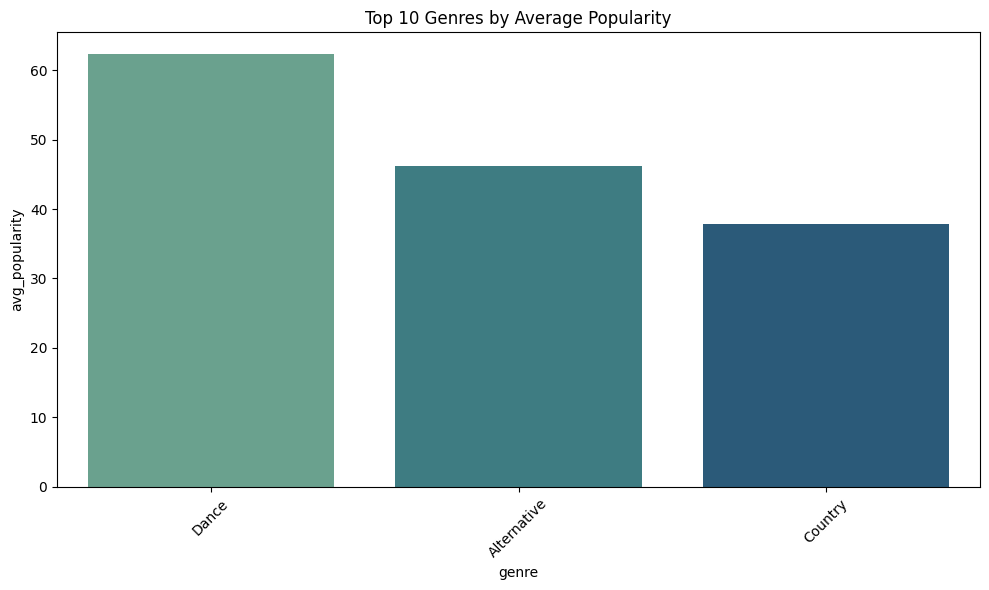

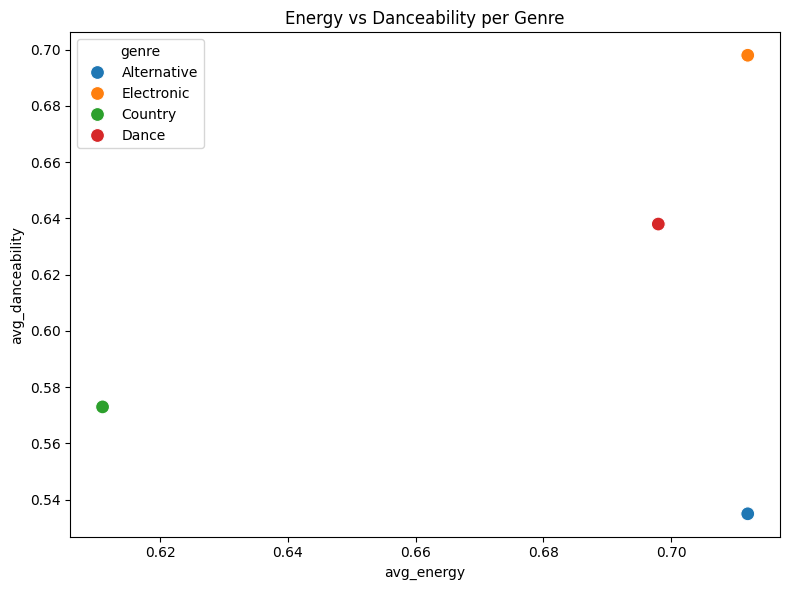

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


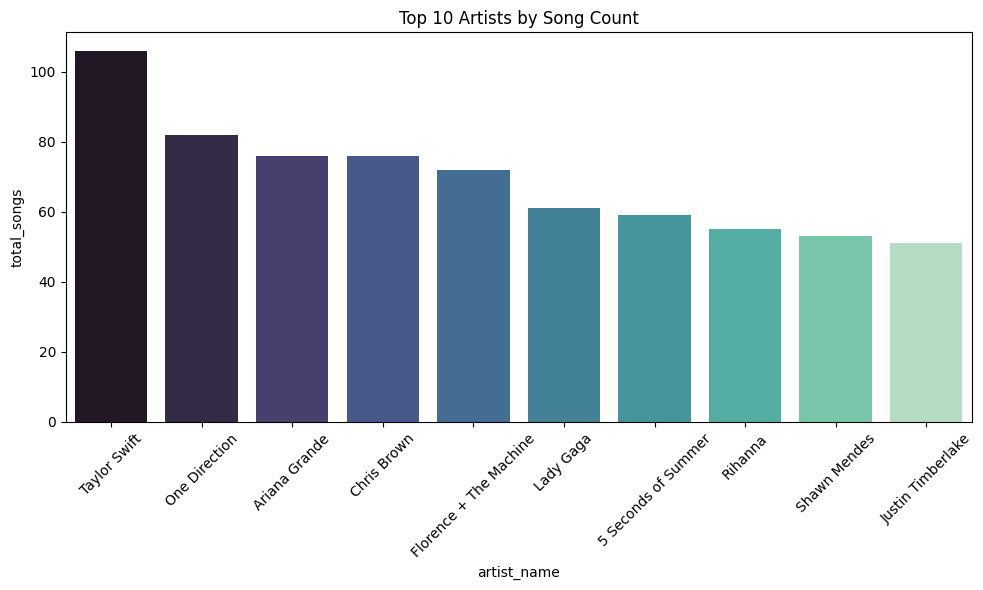

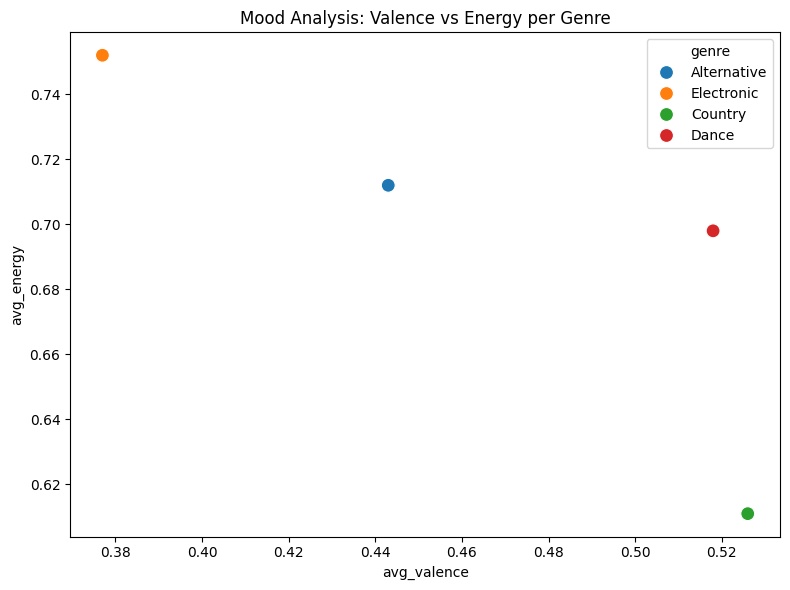

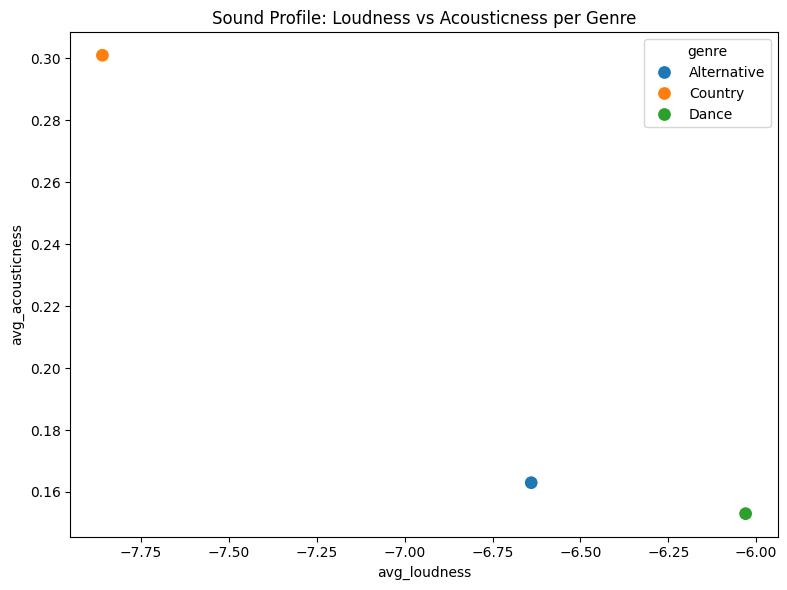

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


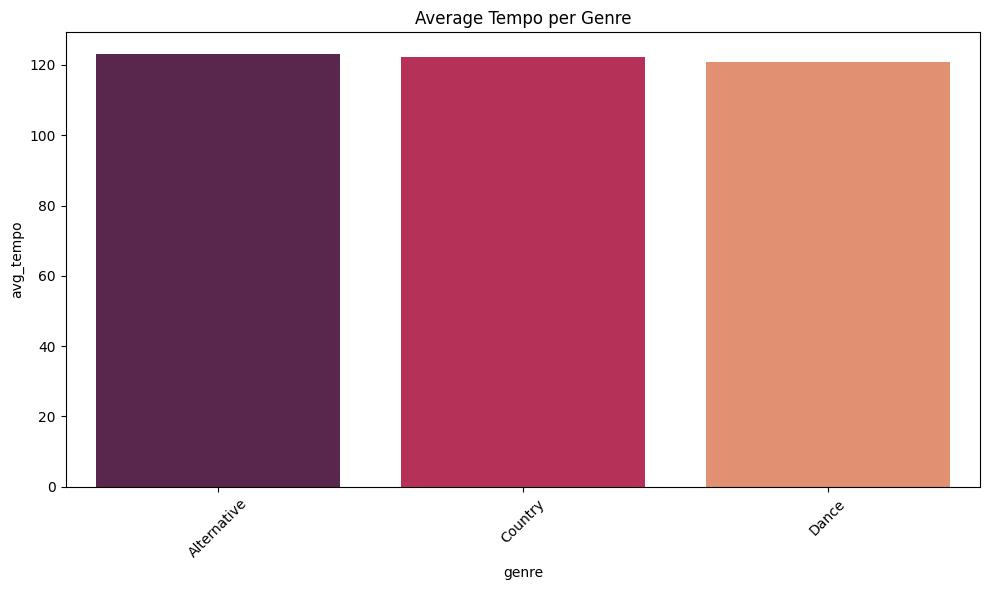

-------------------------------------------
Batch: 11
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Electronic |51.66503496503496 |1430 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


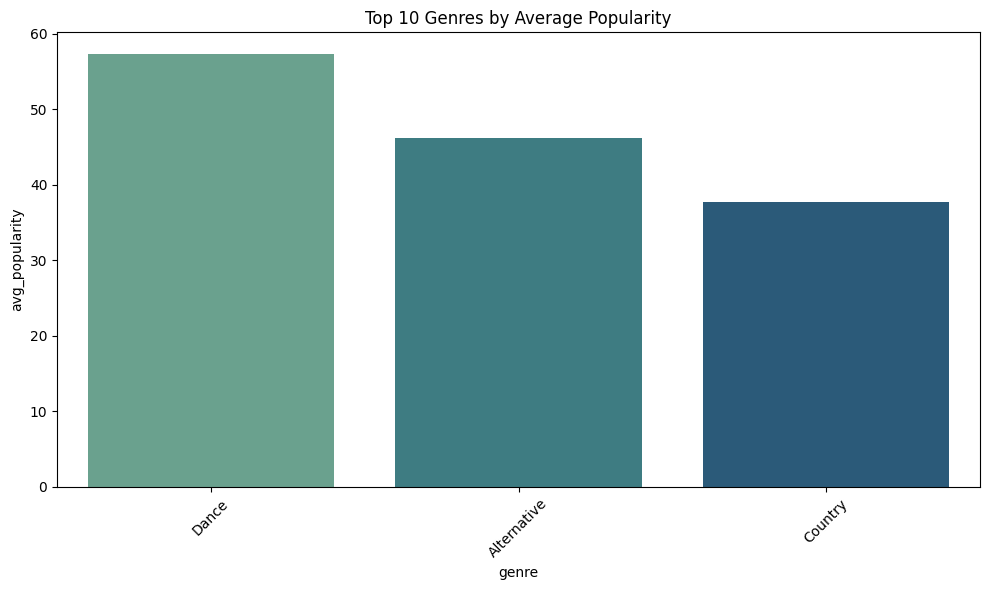

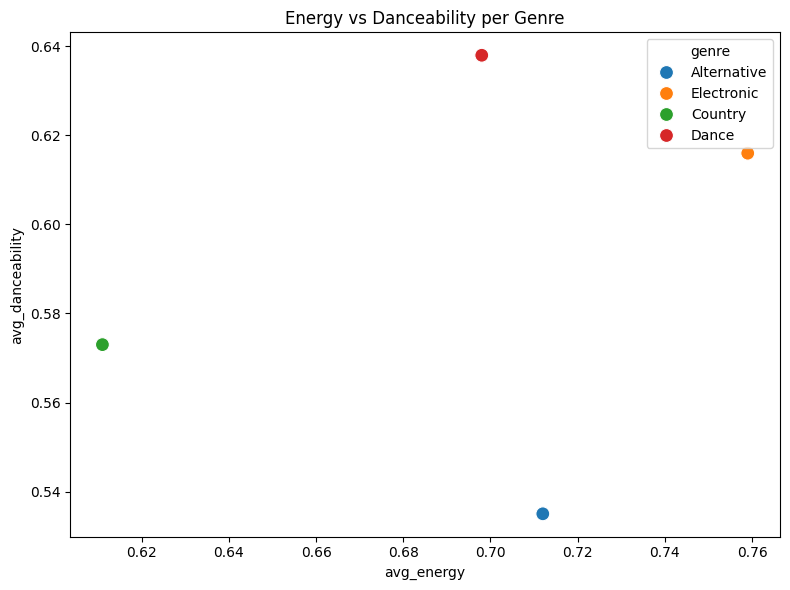

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


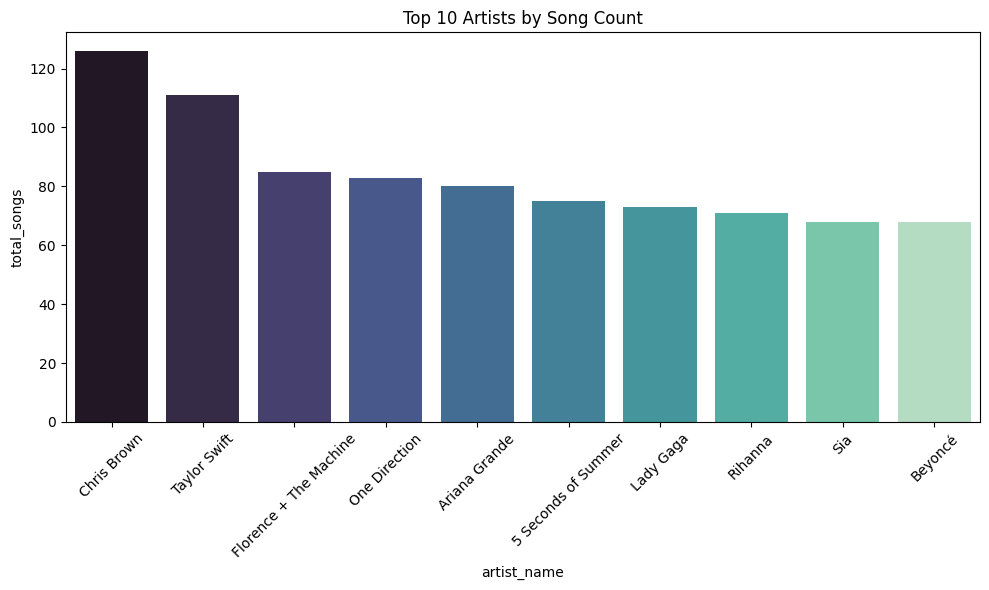

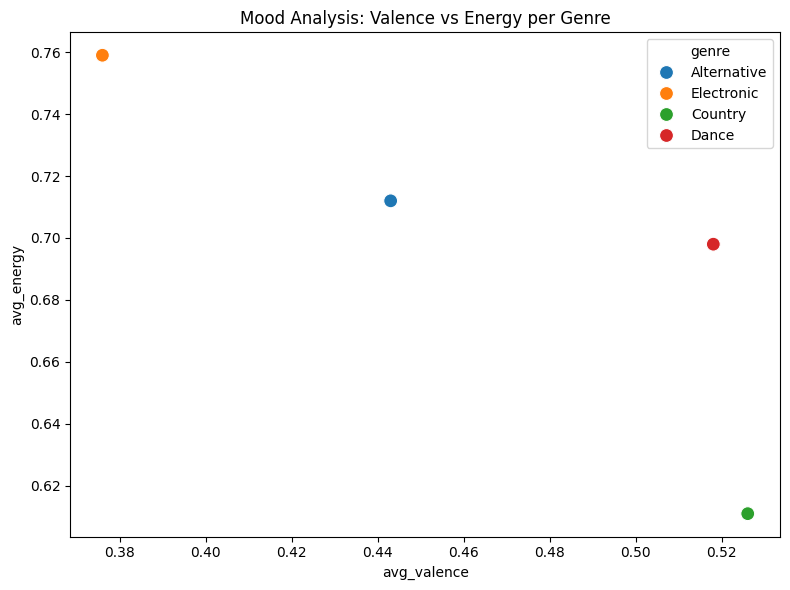

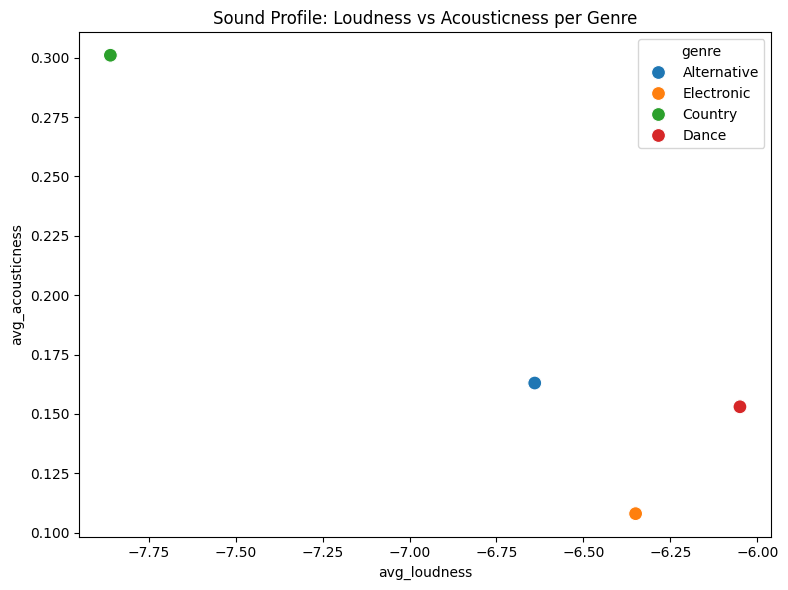

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


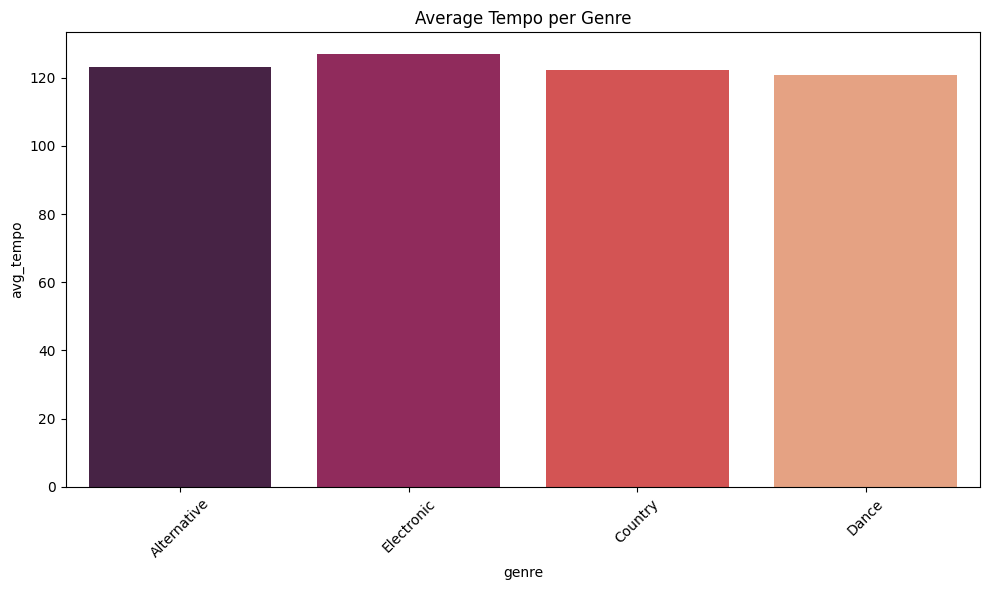

-------------------------------------------
Batch: 12
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.578904064505515|6077 |
|Electronic |45.669972451790635|3630 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 169:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


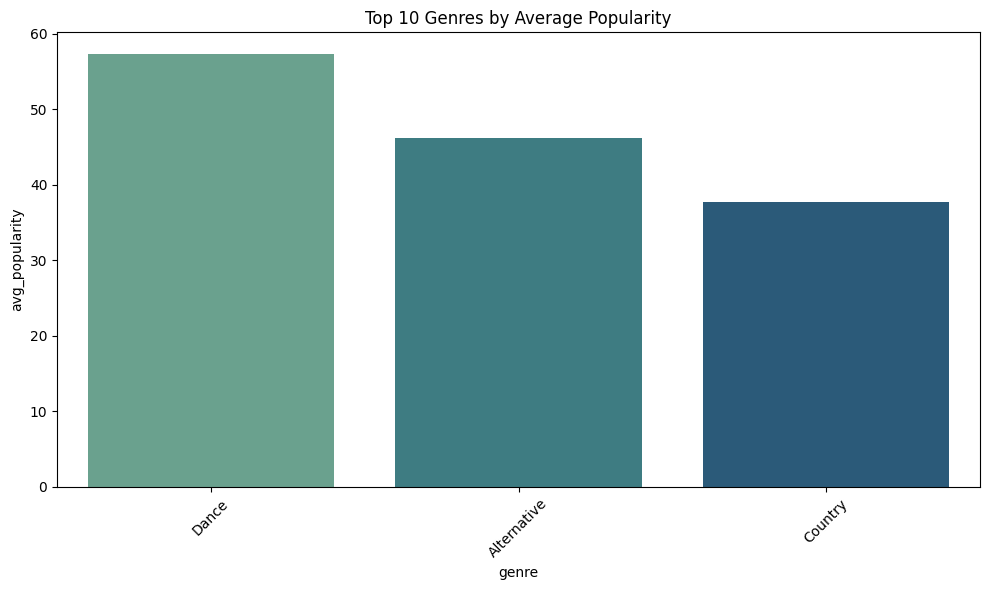

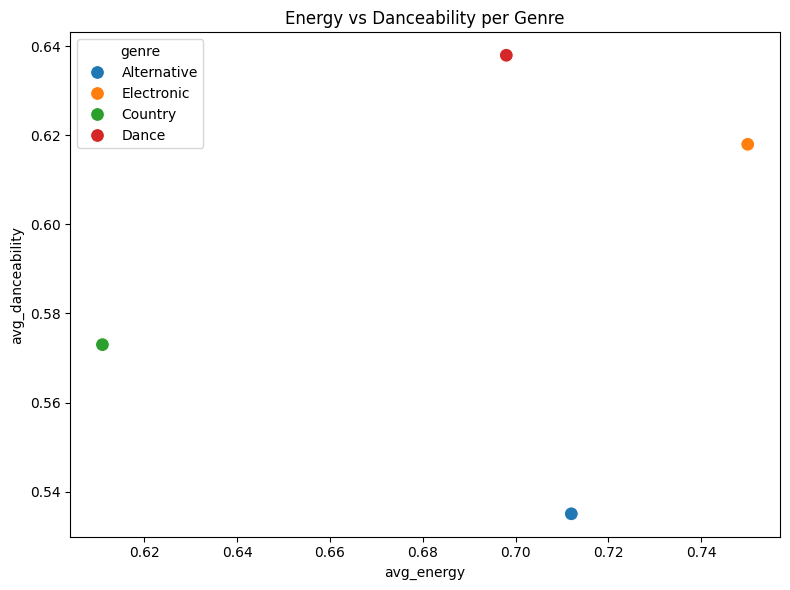

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 169:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


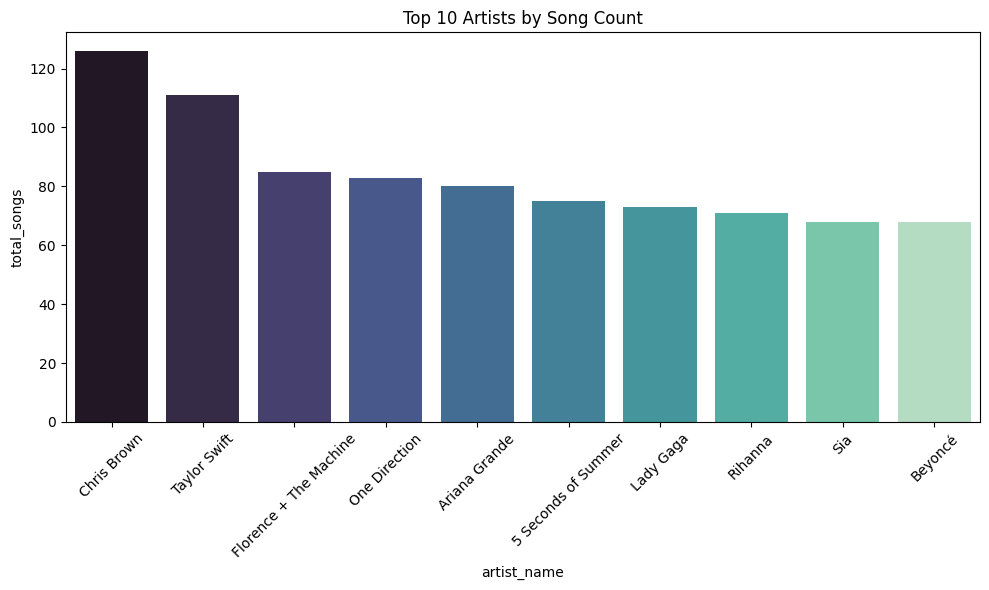

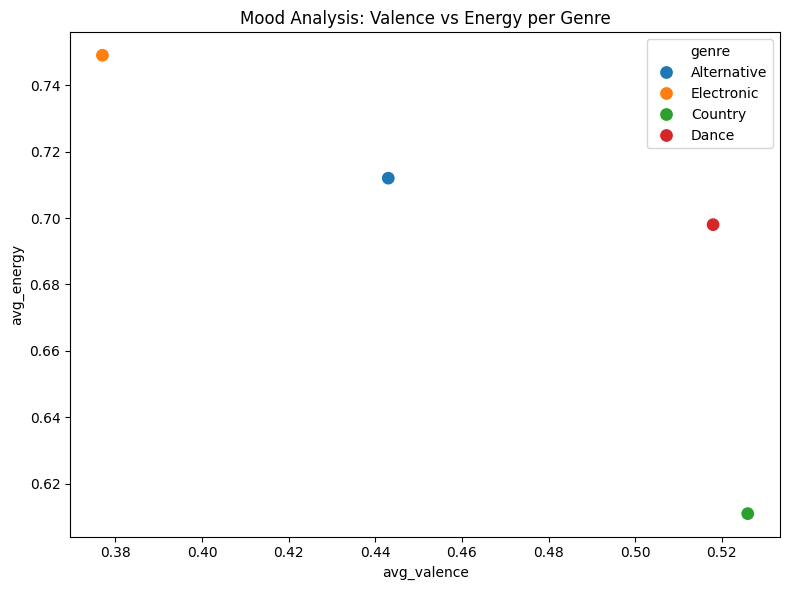

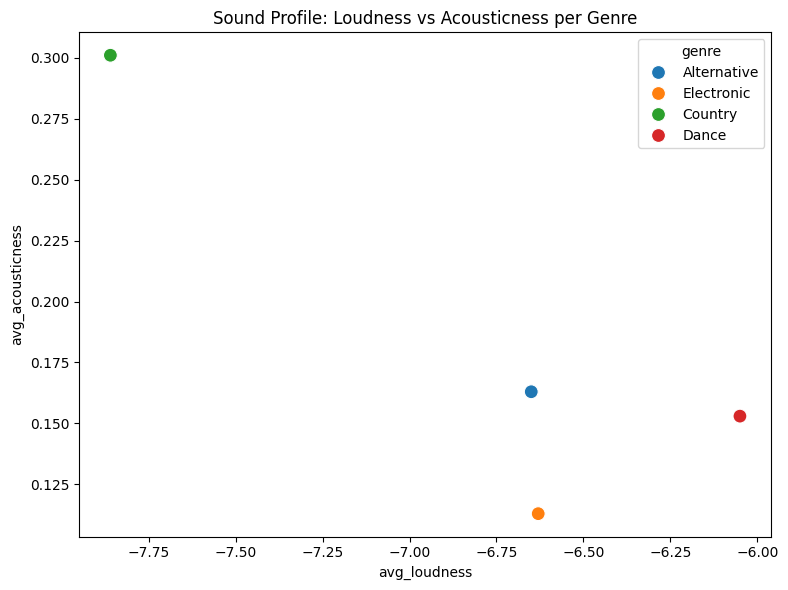

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


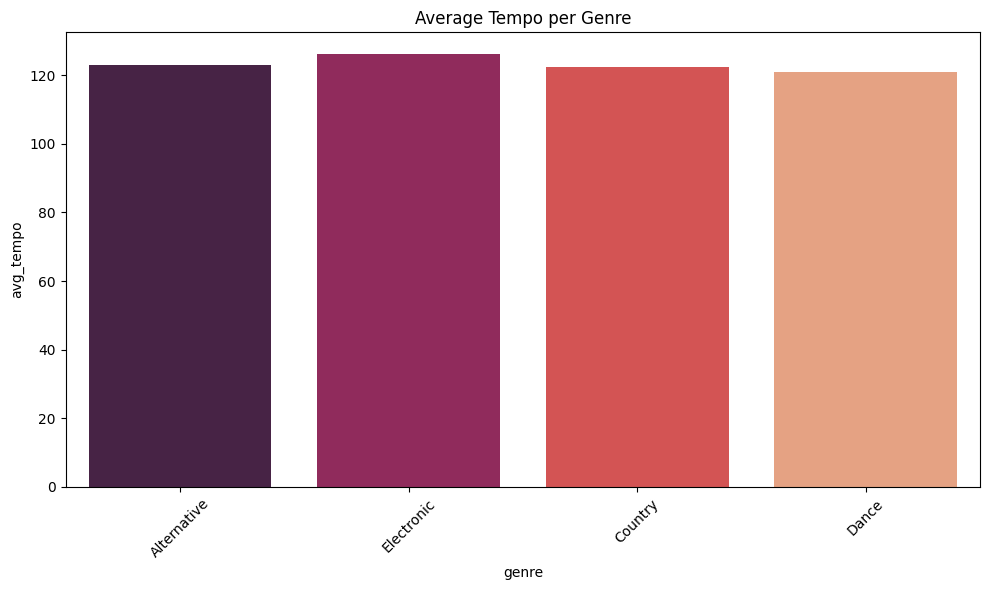

-------------------------------------------
Batch: 13
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Alternative|47.209769253820795|6674 |
|Electronic |43.338536387593756|4933 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


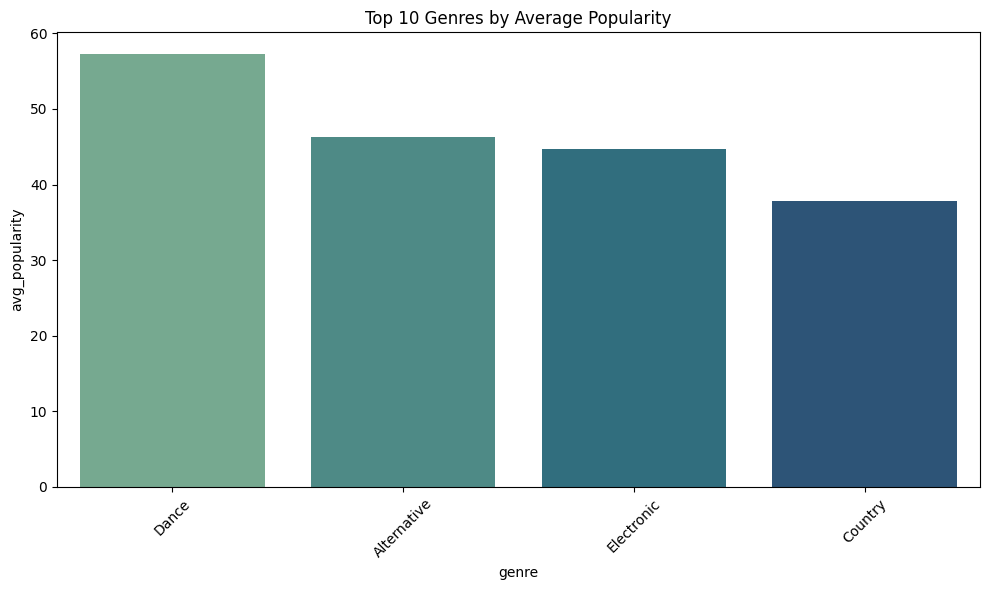

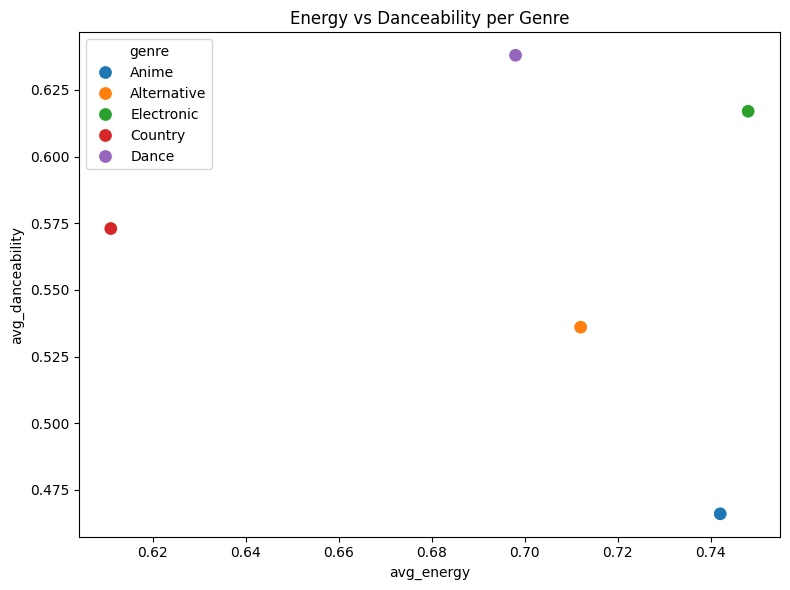

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: ge 187:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


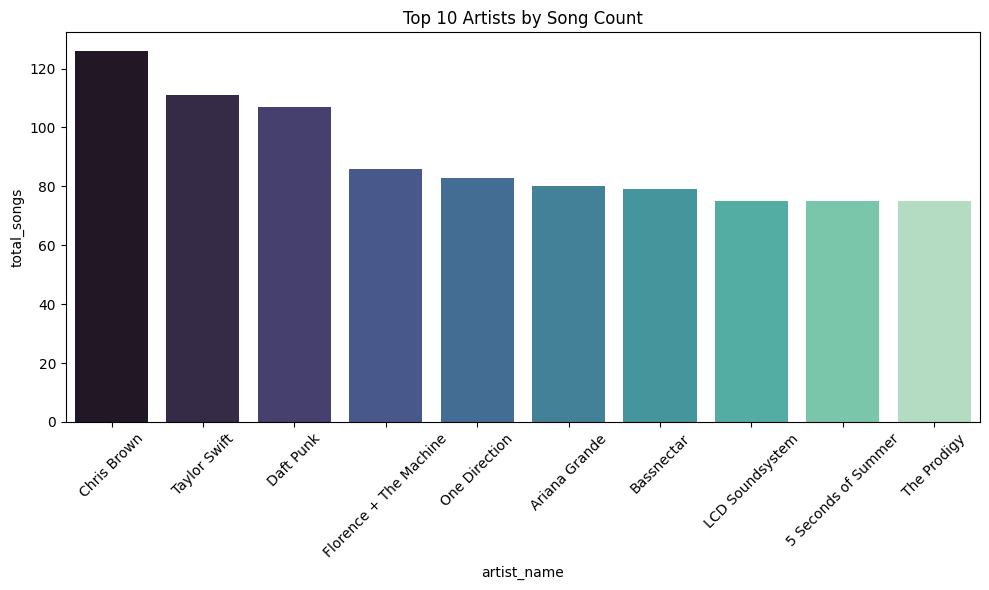

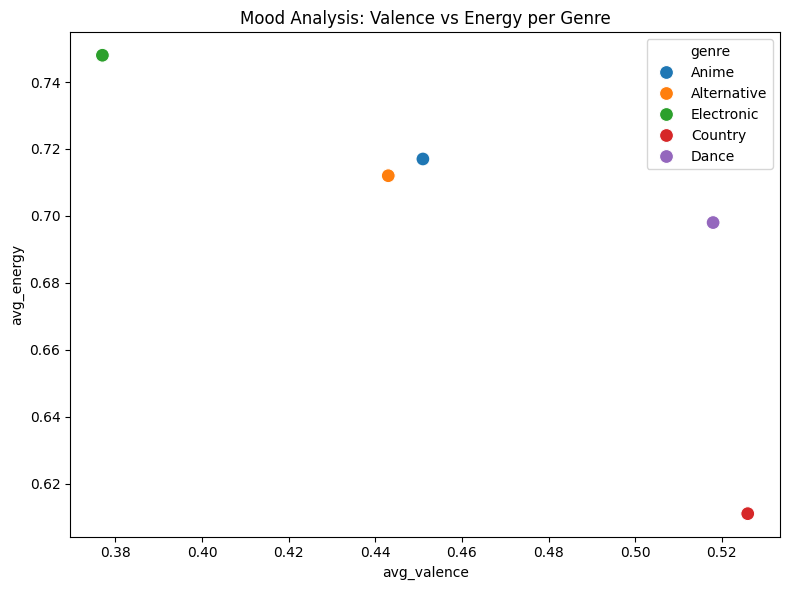

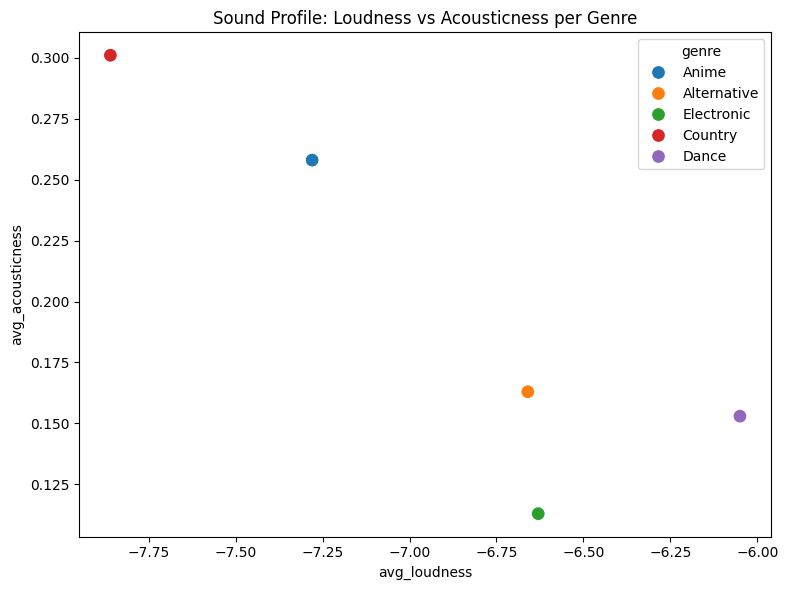

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


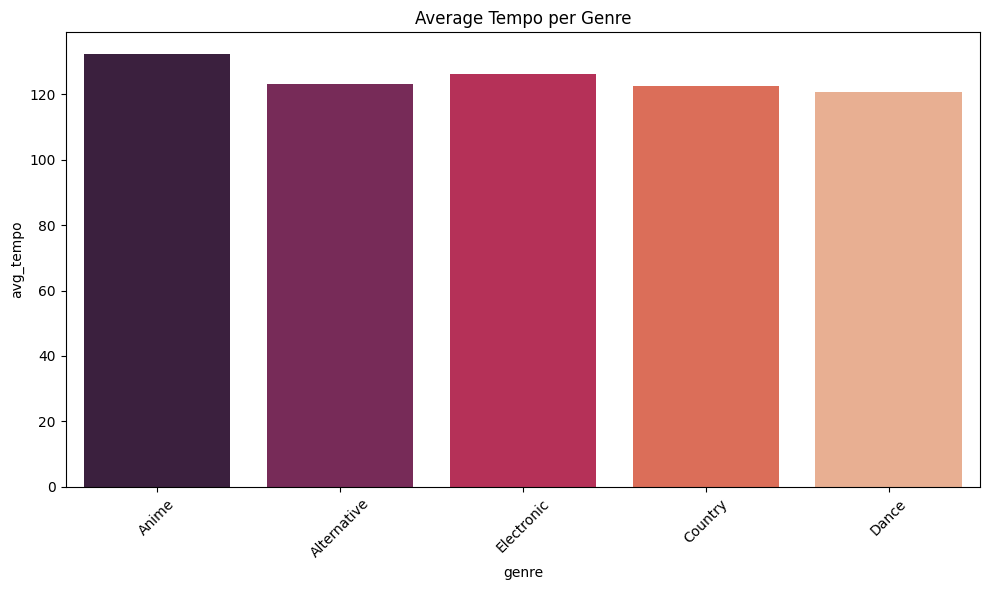

-------------------------------------------
Batch: 14
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Anime      |36.49576031656303 |1769 |
|Alternative|47.188814317673376|6705 |
|Electronic |43.338536387593756|4933 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


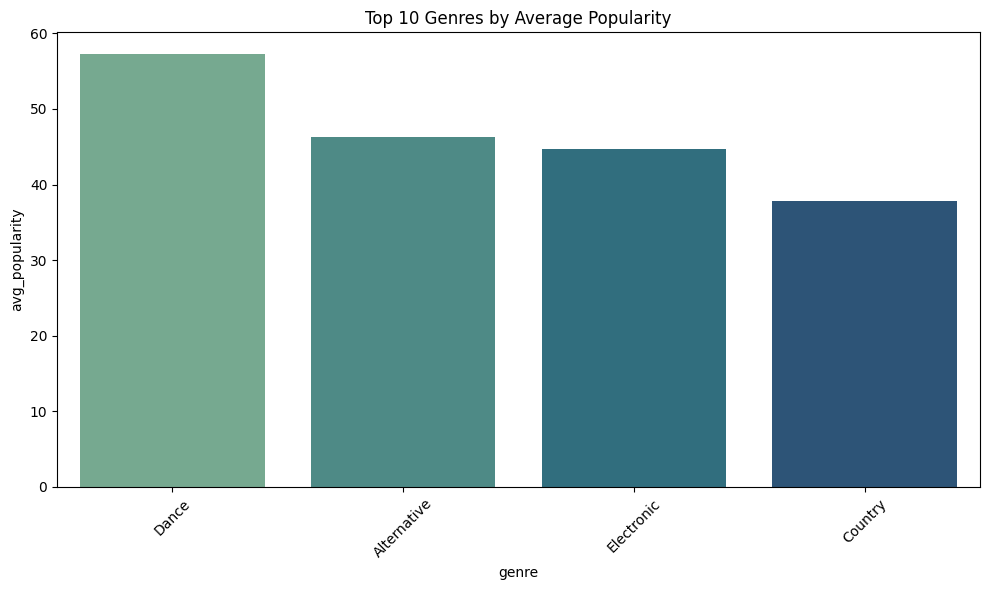

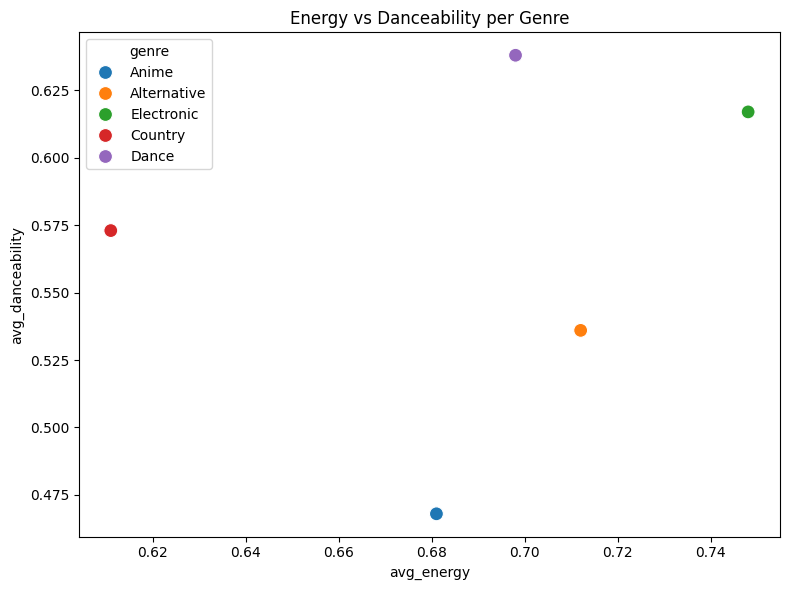

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 201:>(8 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


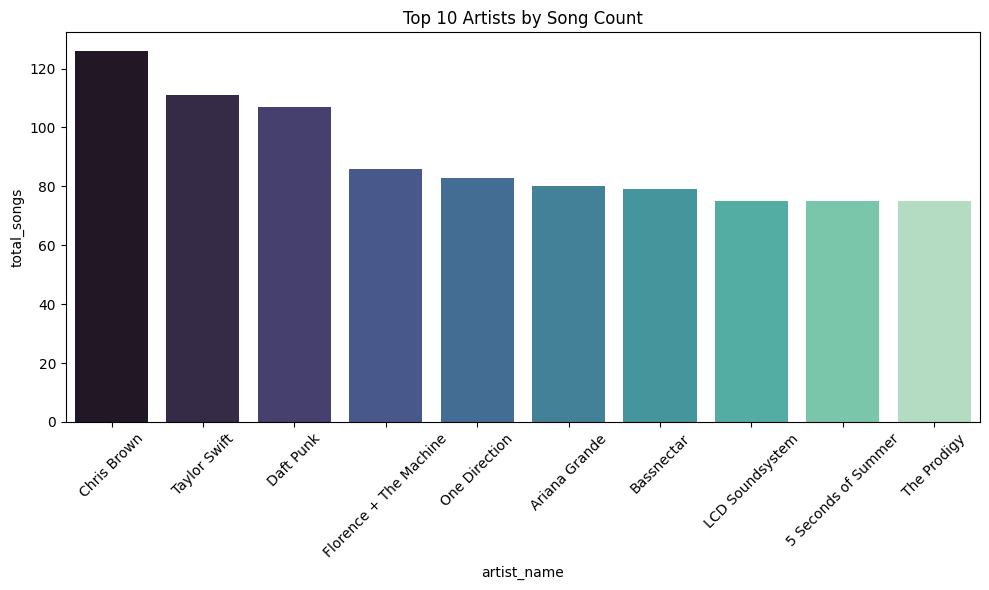

-------------------------------------------
Batch: 15
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Anime      |31.081674851382786|3869 |
|Alternative|47.188814317673376|6705 |
|Electronic |43.338536387593756|4933 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



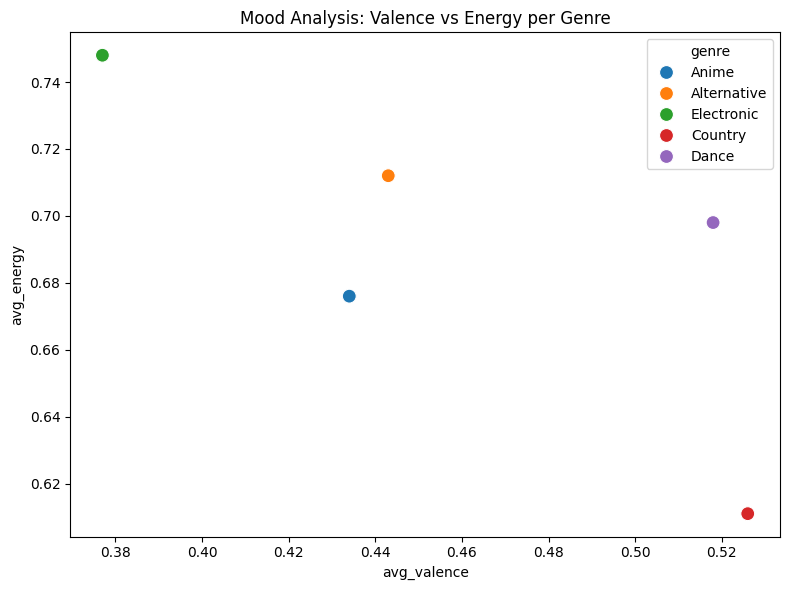

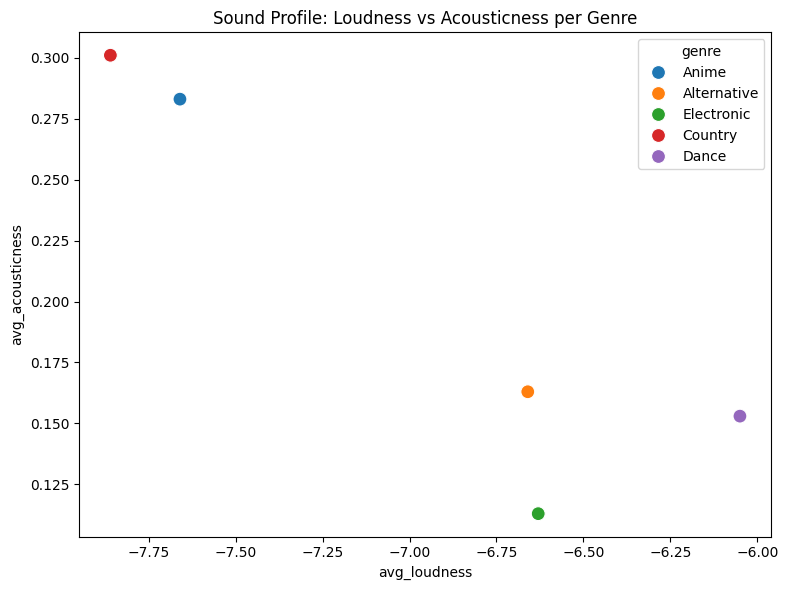

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


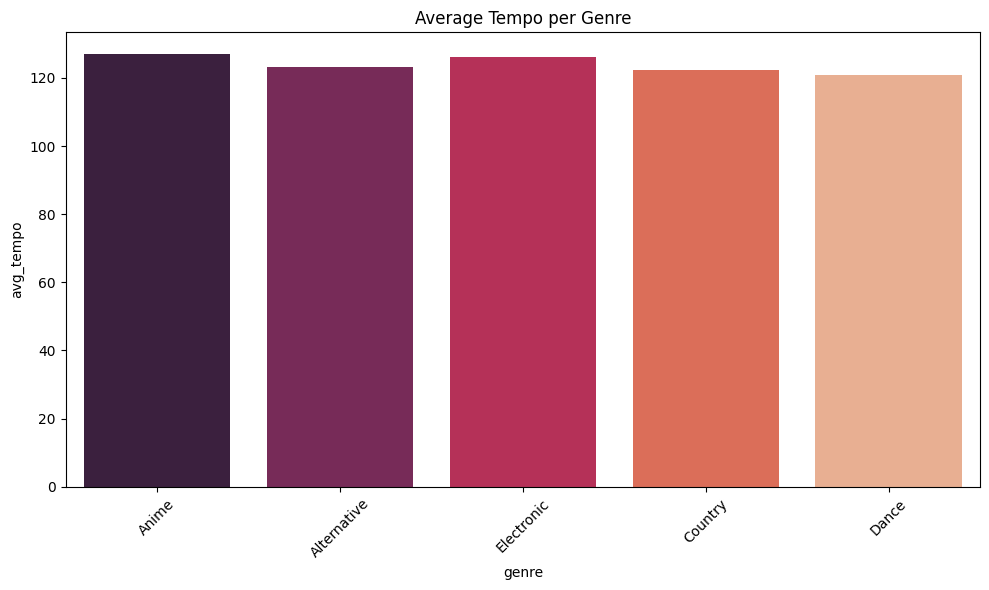

/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


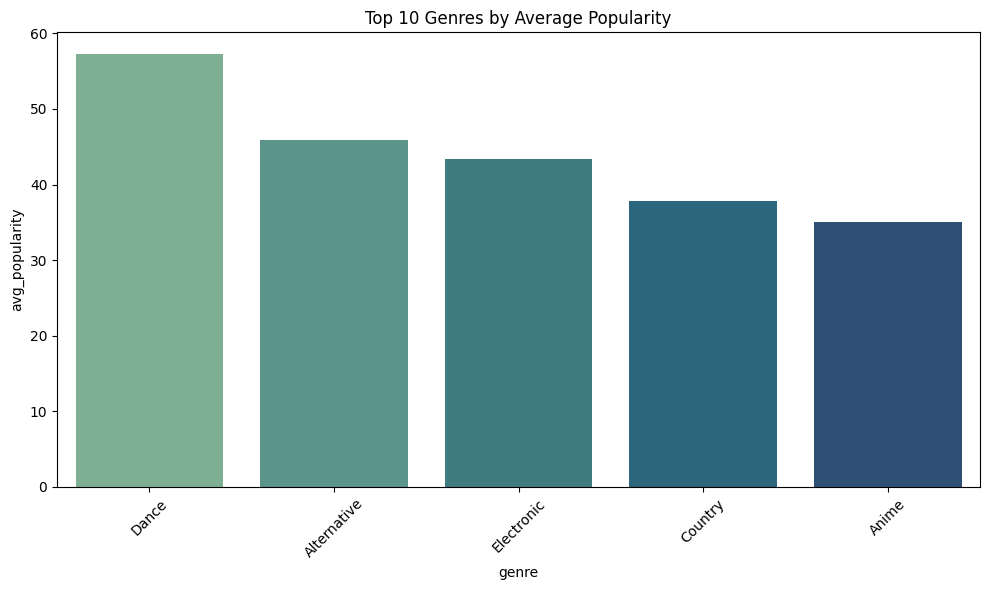

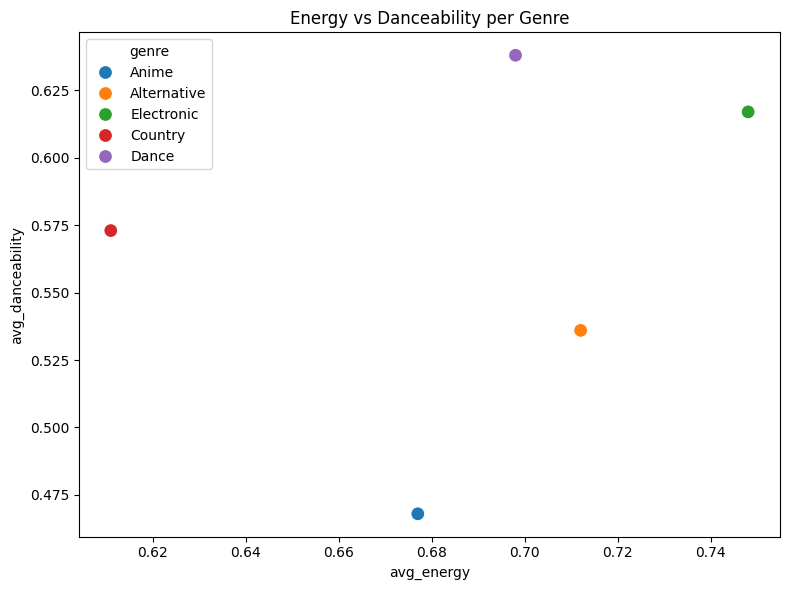

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


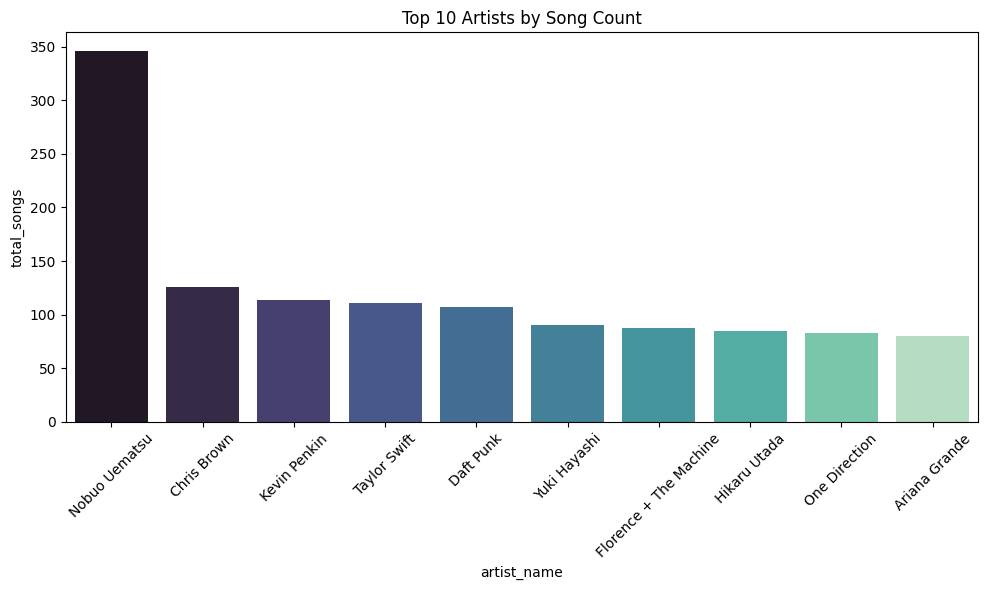

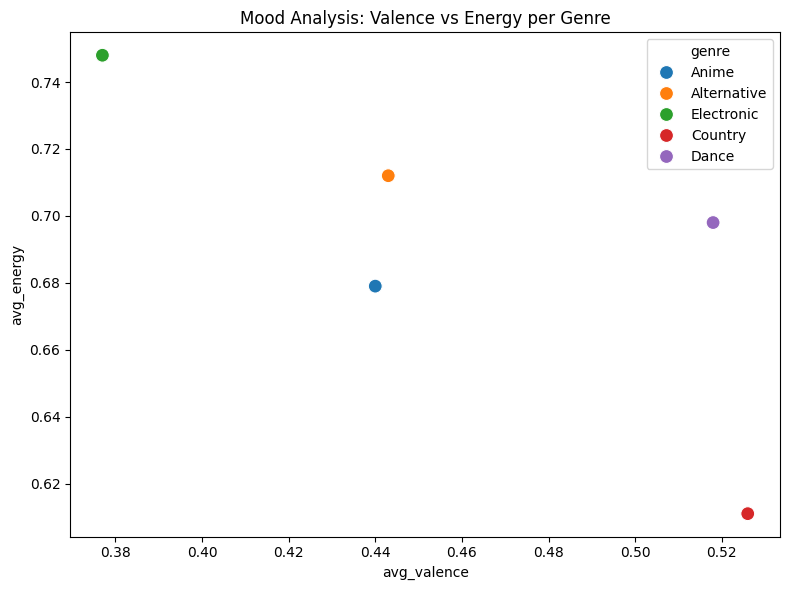

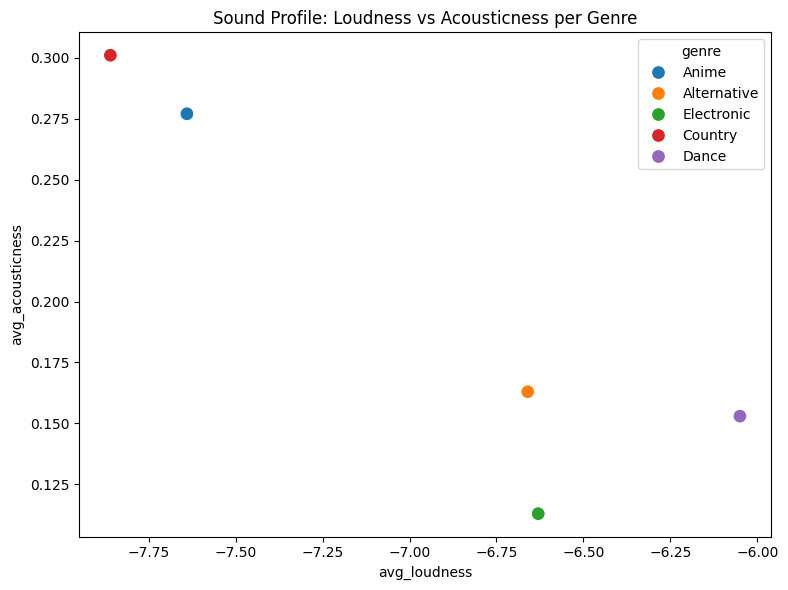

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


-------------------------------------------
Batch: 16
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Anime      |28.281379062668343|5569 |
|Alternative|47.188814317673376|6705 |
|Electronic |43.338536387593756|4933 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



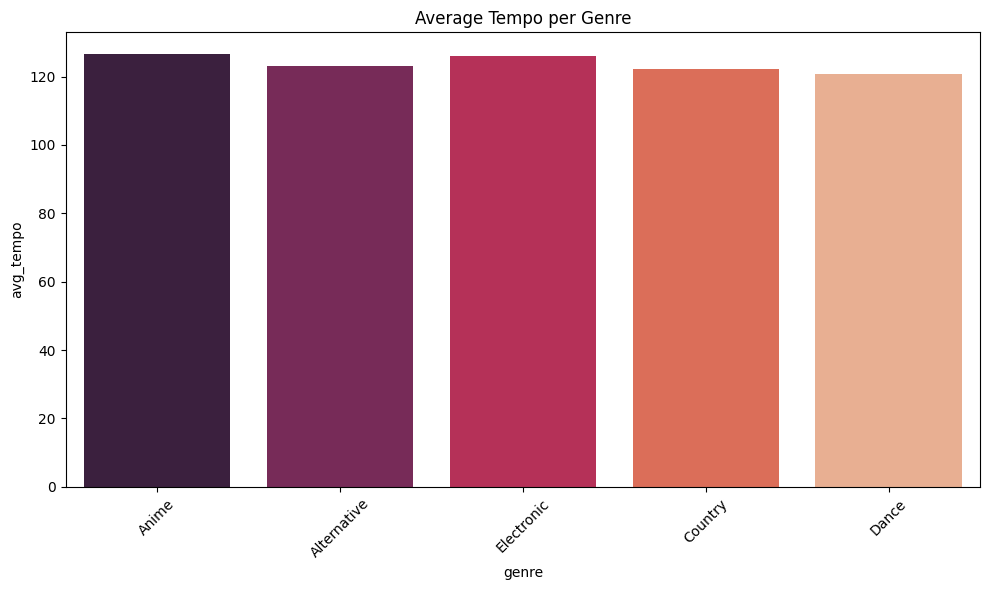

/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 231:(16 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


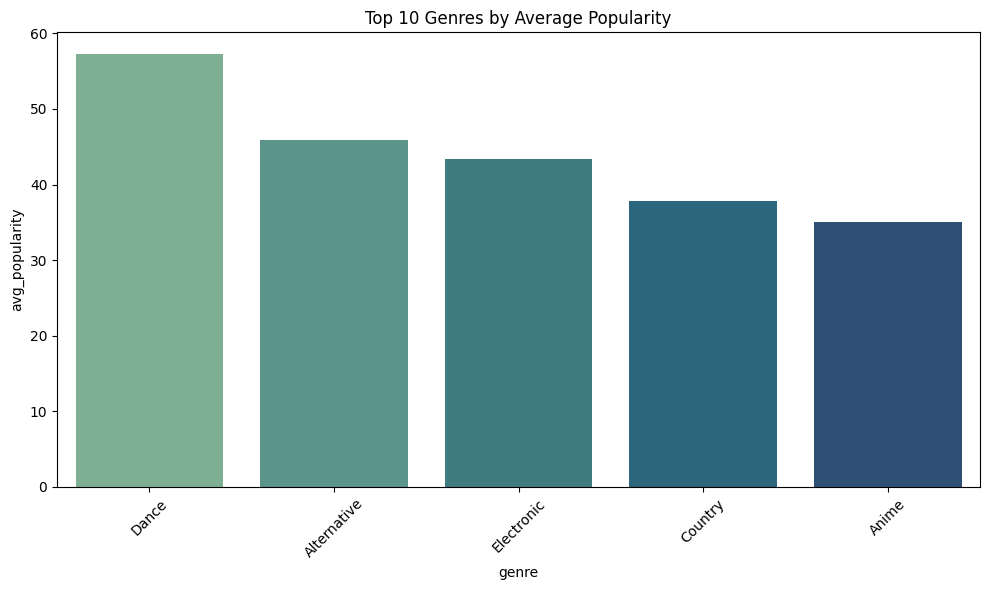

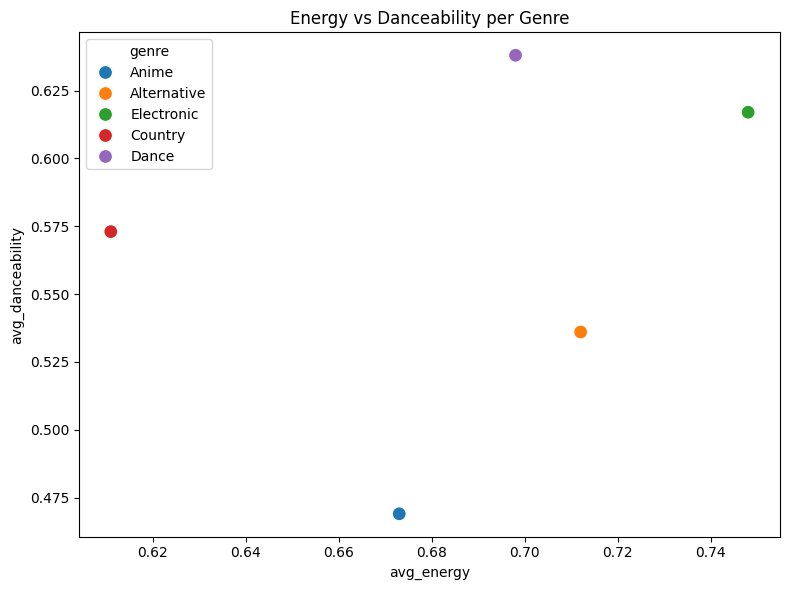

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


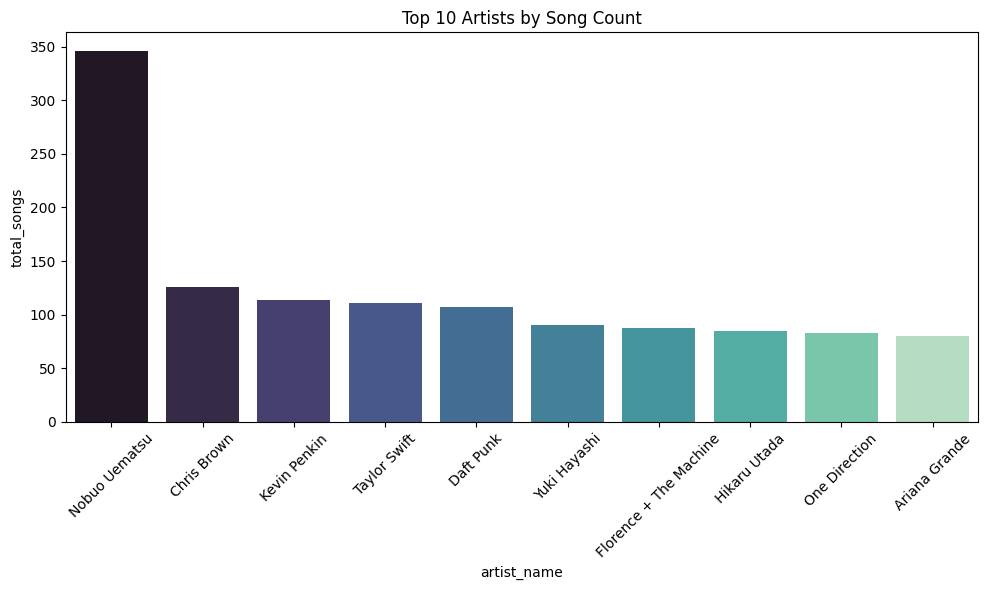

-------------------------------------------
Batch: 17
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Anime      |25.363197356716228|7869 |
|Alternative|47.188814317673376|6705 |
|Electronic |43.338536387593756|4933 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



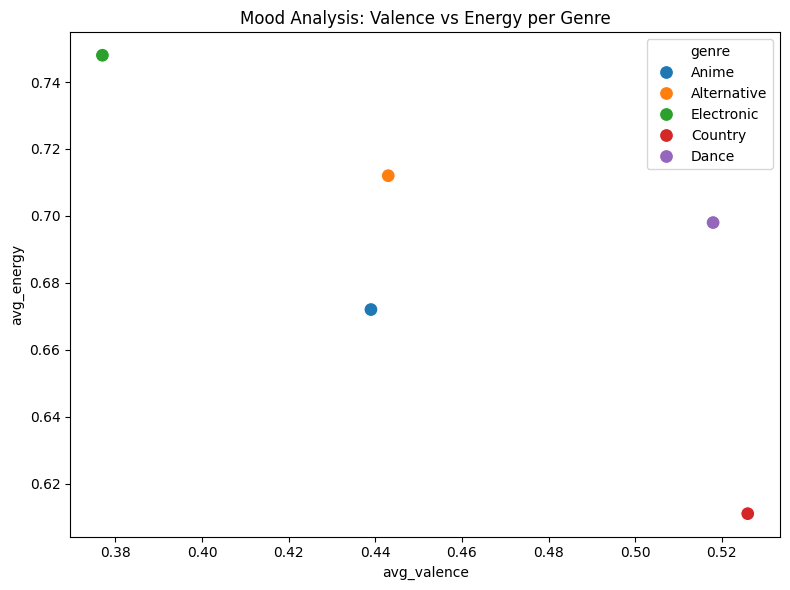

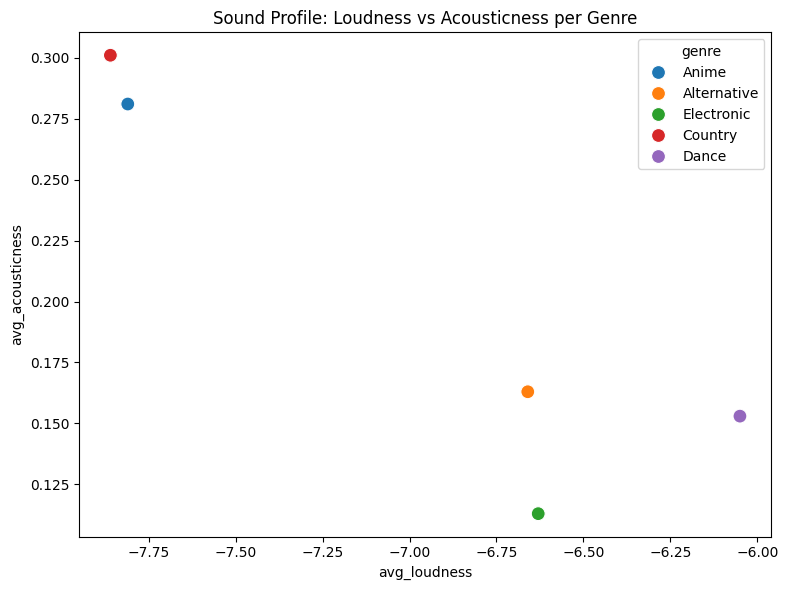

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


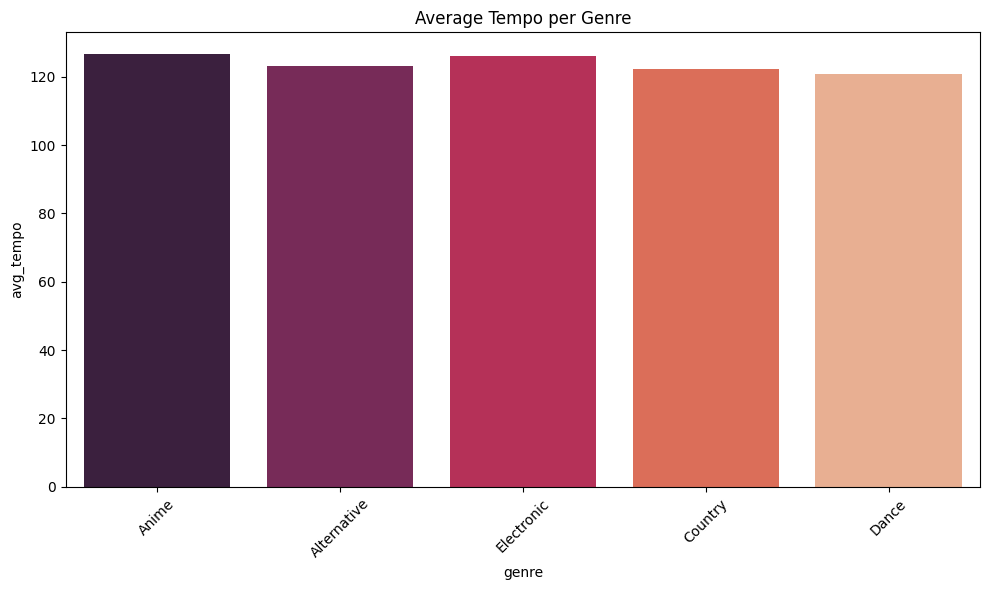

-------------------------------------------
Batch: 18
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Anime      |24.89830508474576 |8320 |
|Alternative|47.188814317673376|6705 |
|Electronic |41.03463992707384 |6582 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


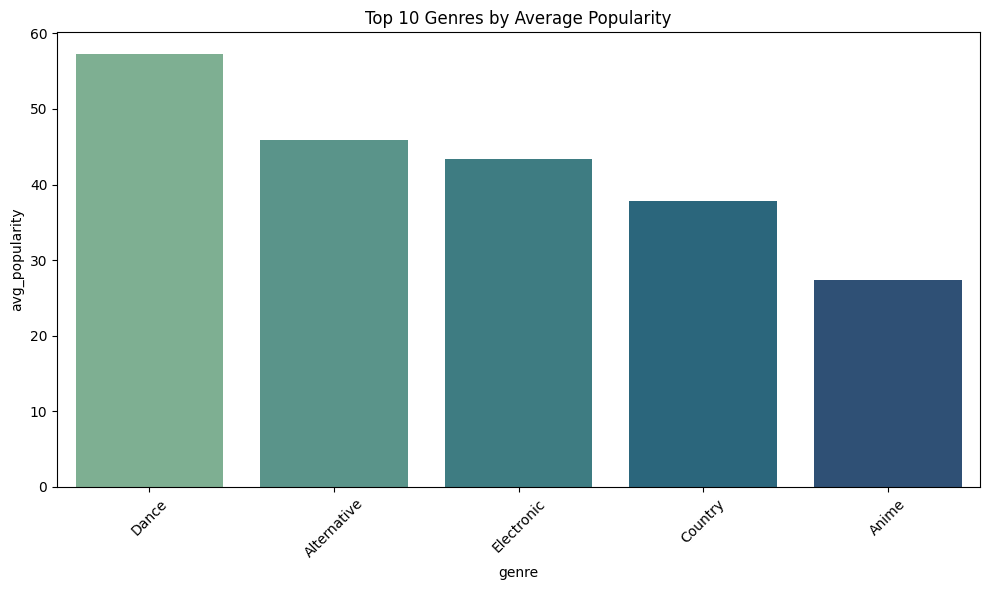

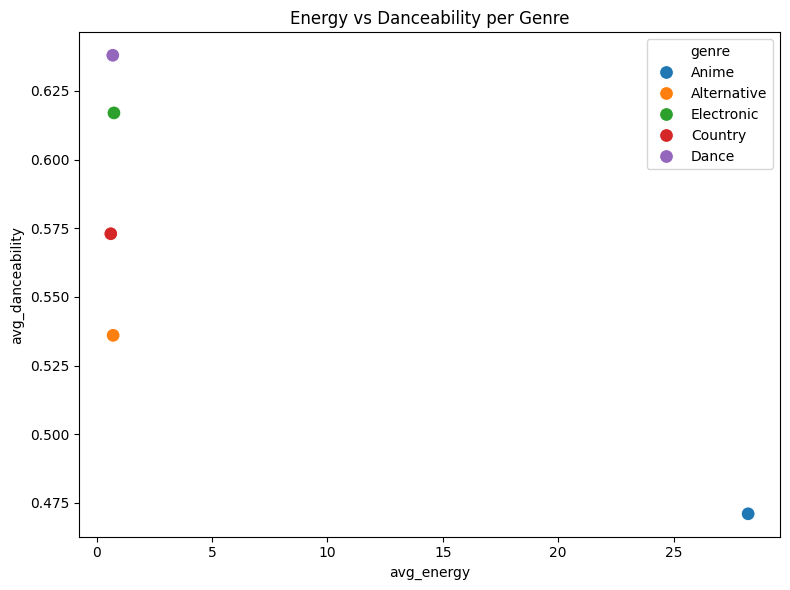

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


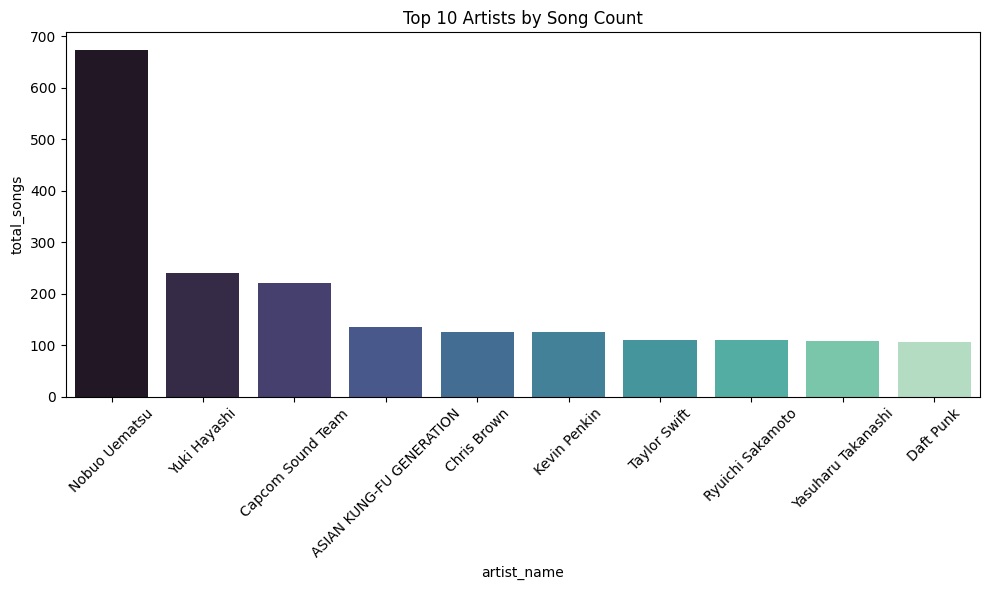

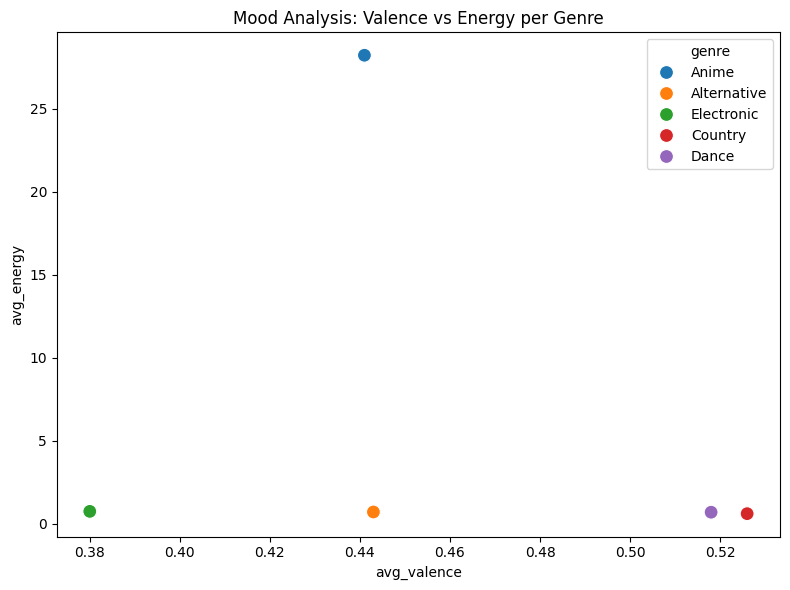

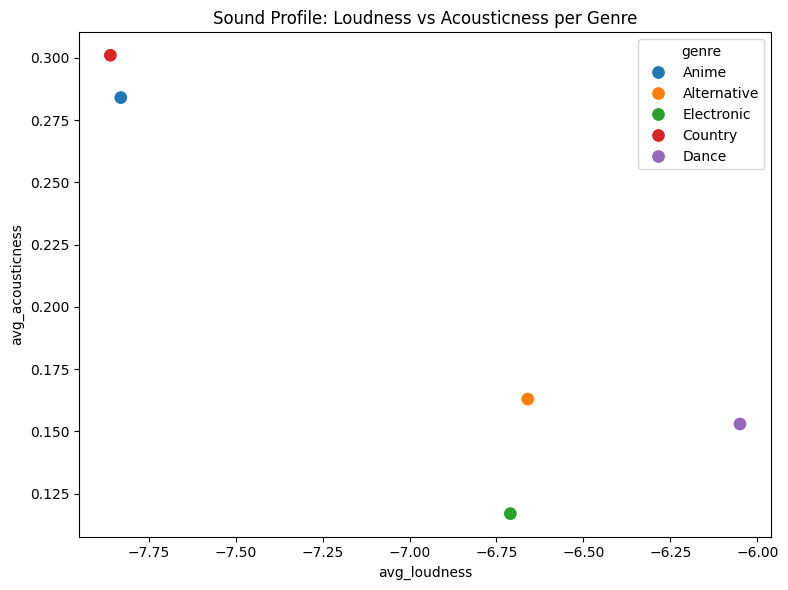

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


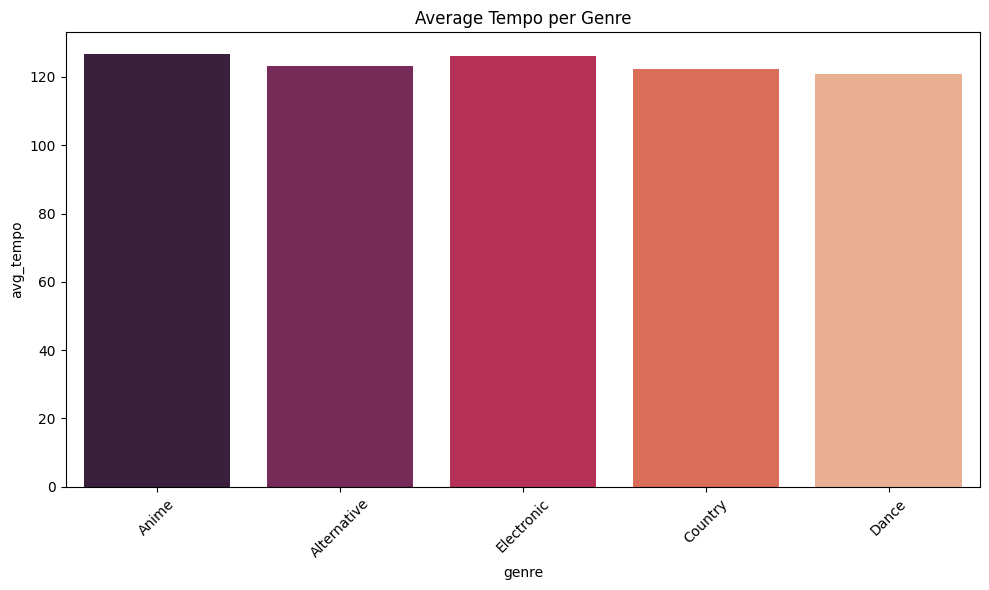

-------------------------------------------
Batch: 19
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Anime      |24.89830508474576 |8320 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.730707210320205|8682 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


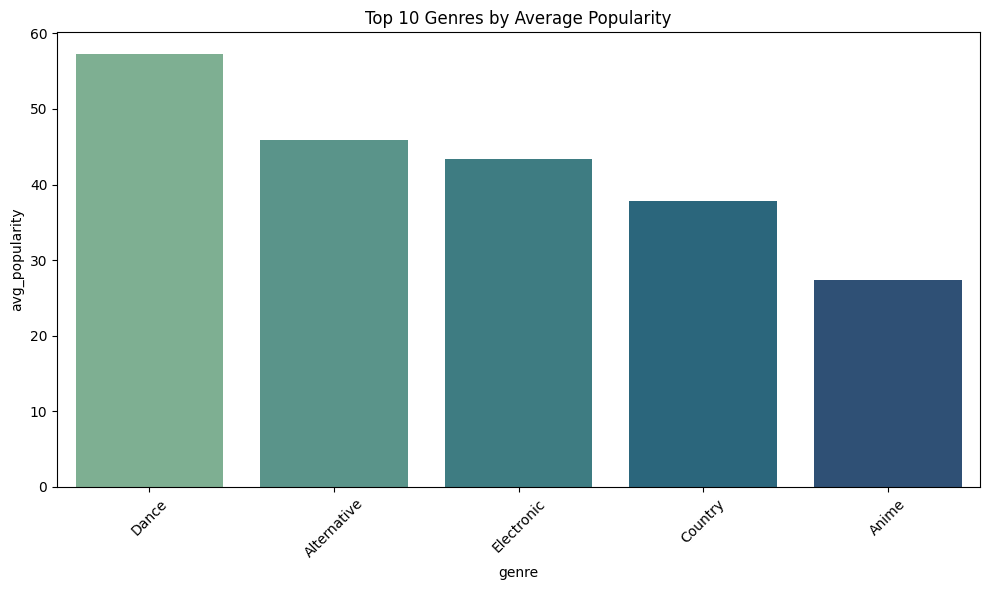

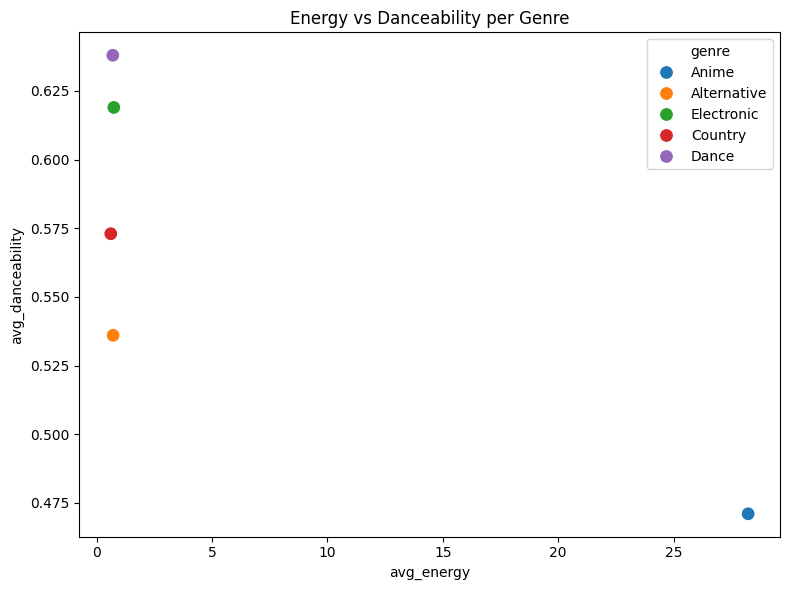

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


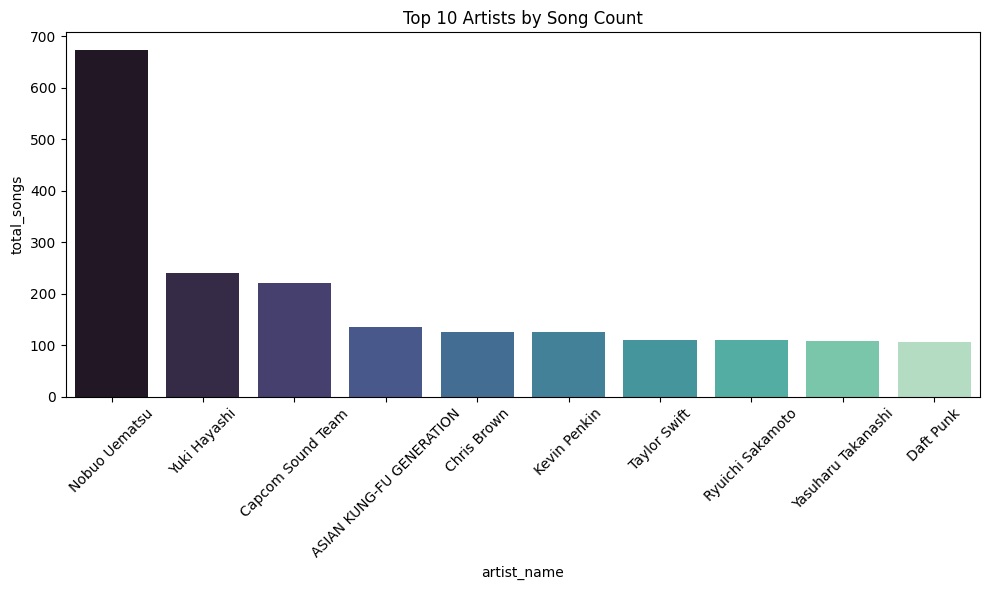

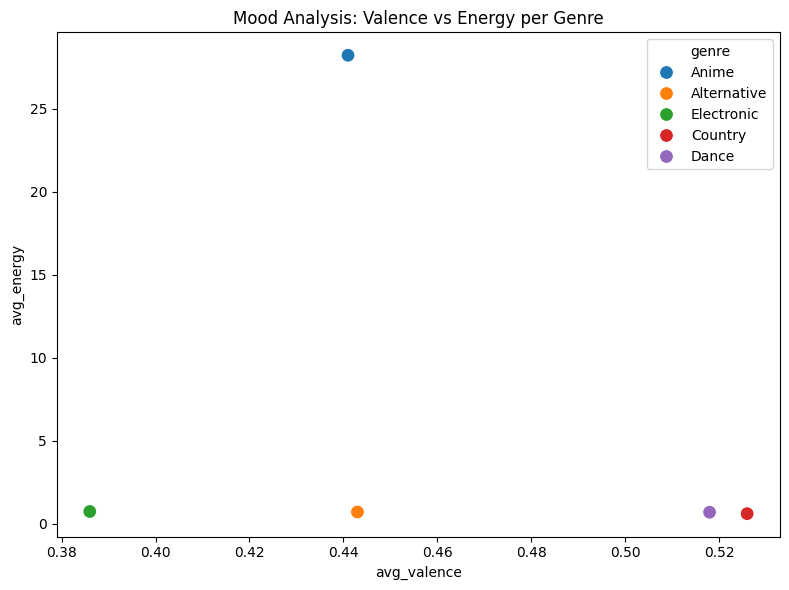

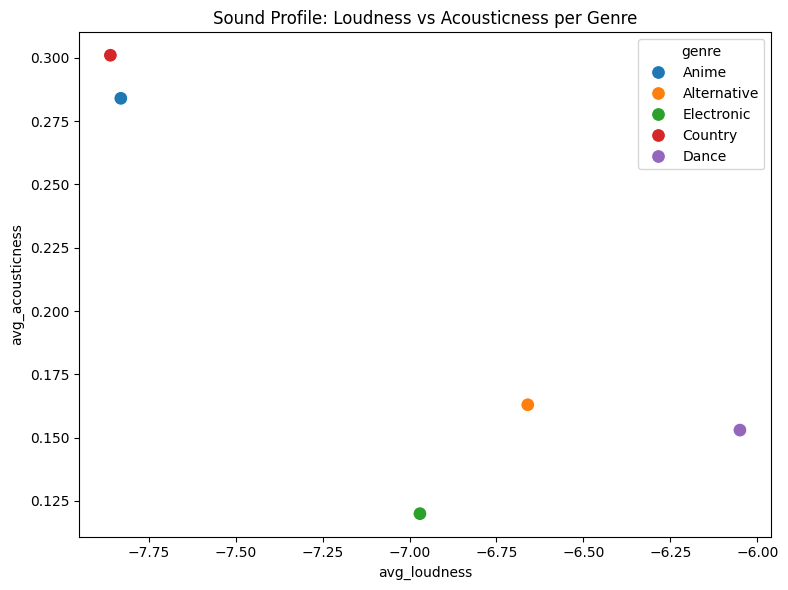

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


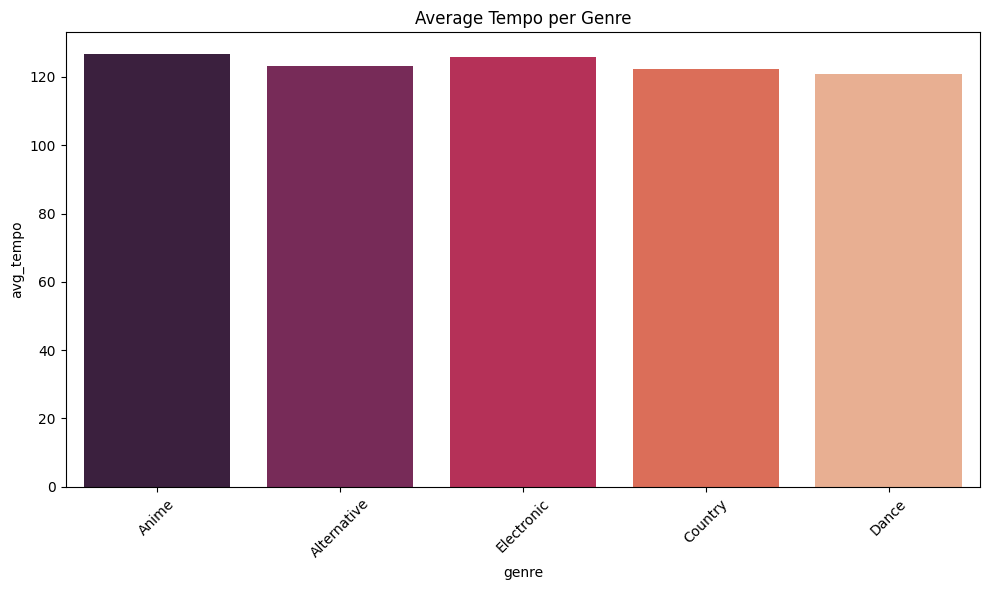

-------------------------------------------
Batch: 20
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |67.38217821782179 |505  |
|Anime      |24.89830508474576 |8320 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 281:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


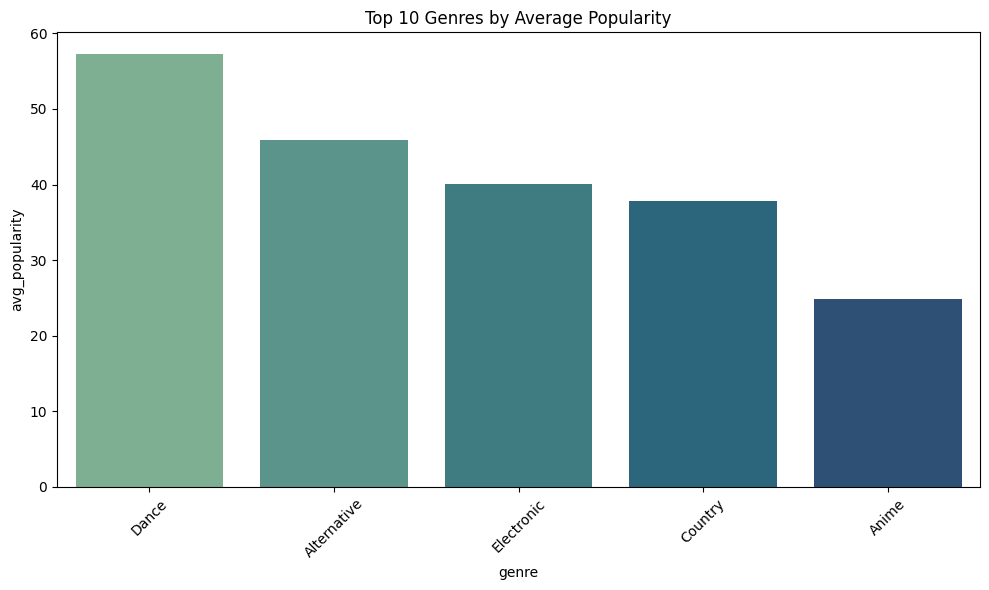

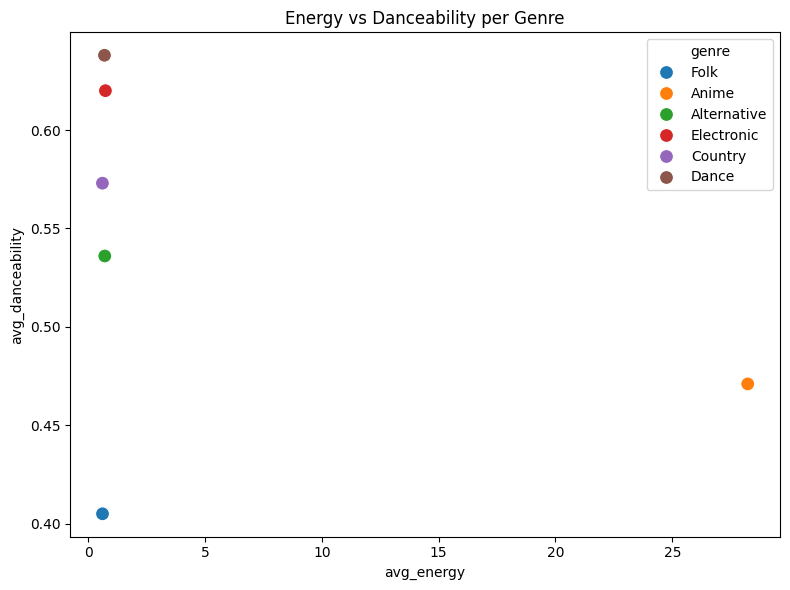

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


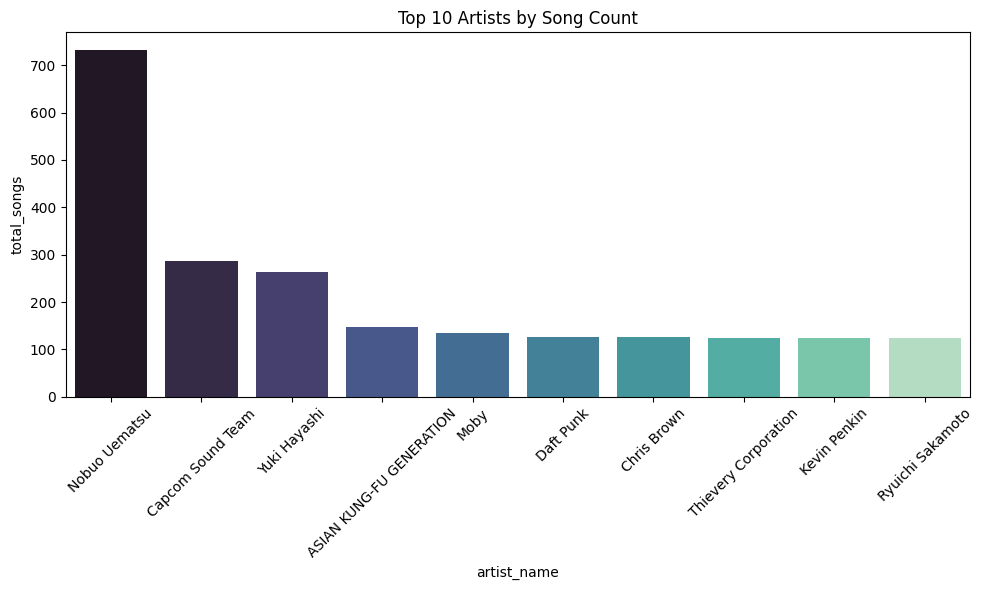

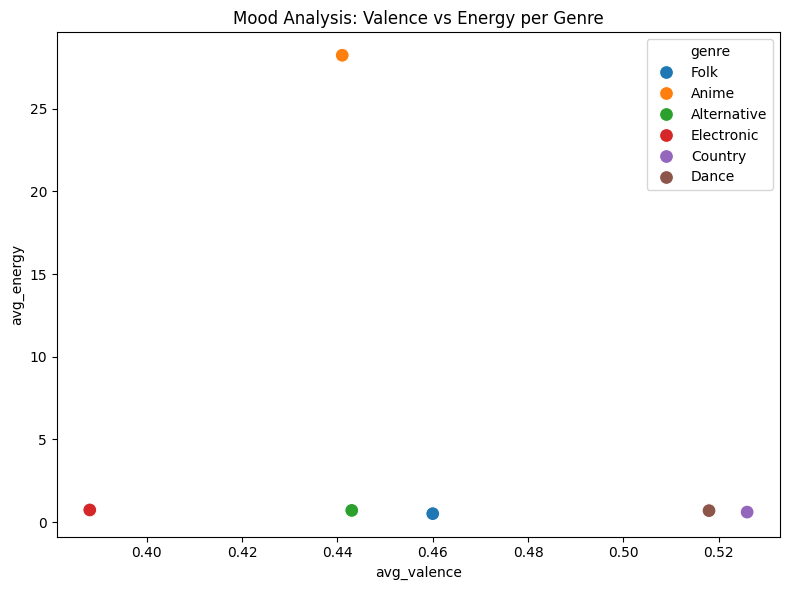

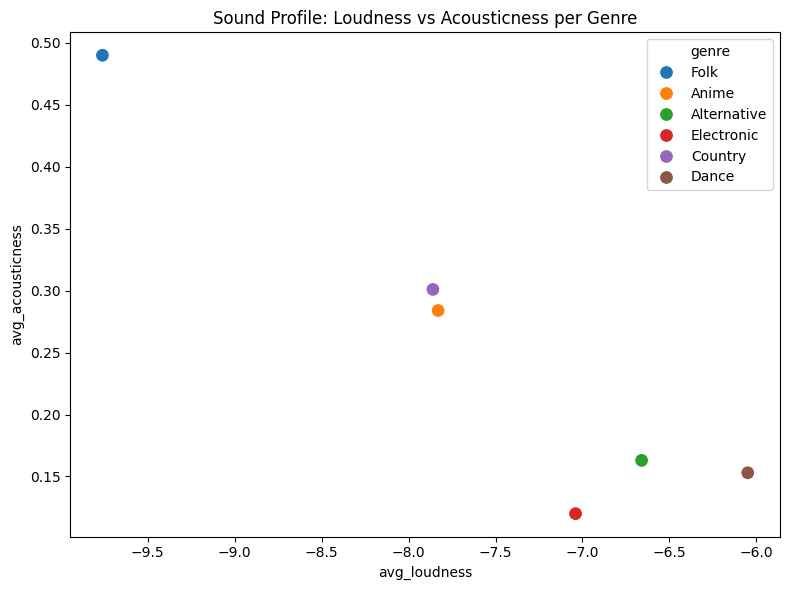

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


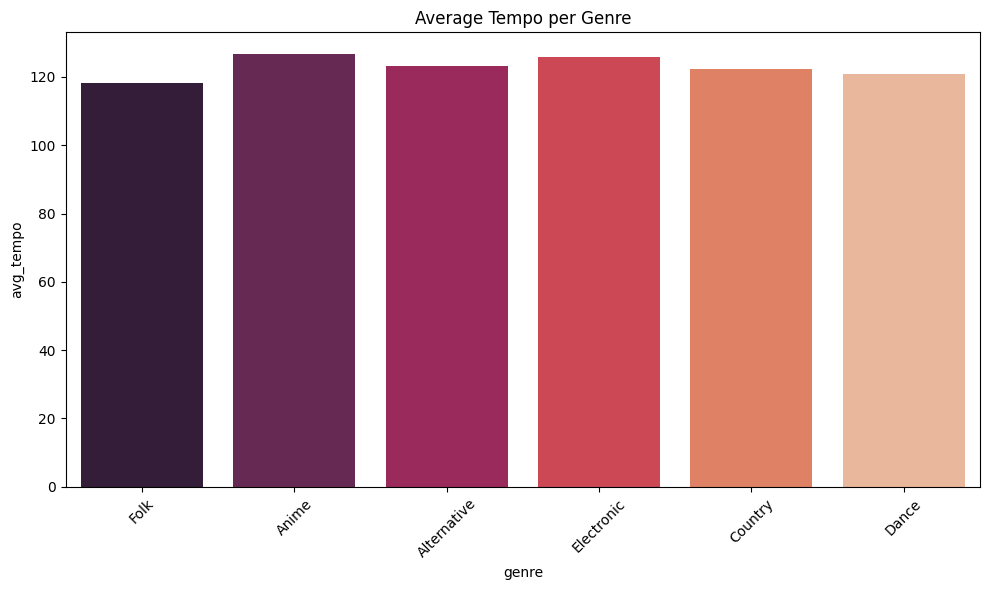

-------------------------------------------
Batch: 21
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |58.643850267379676|2805 |
|Anime      |24.89830508474576 |8320 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: age 295:>  (0 + 0) / 1] 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


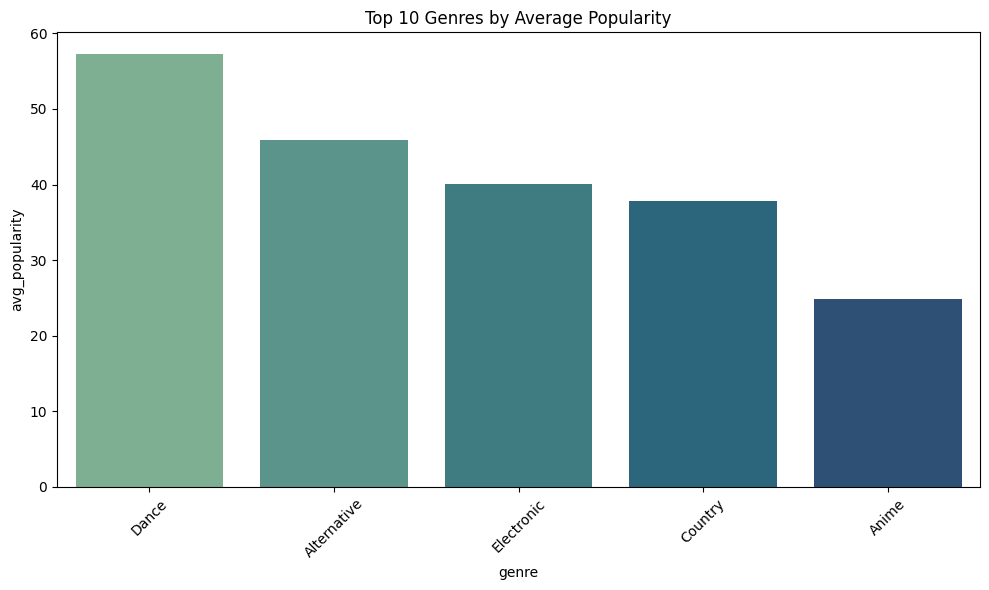

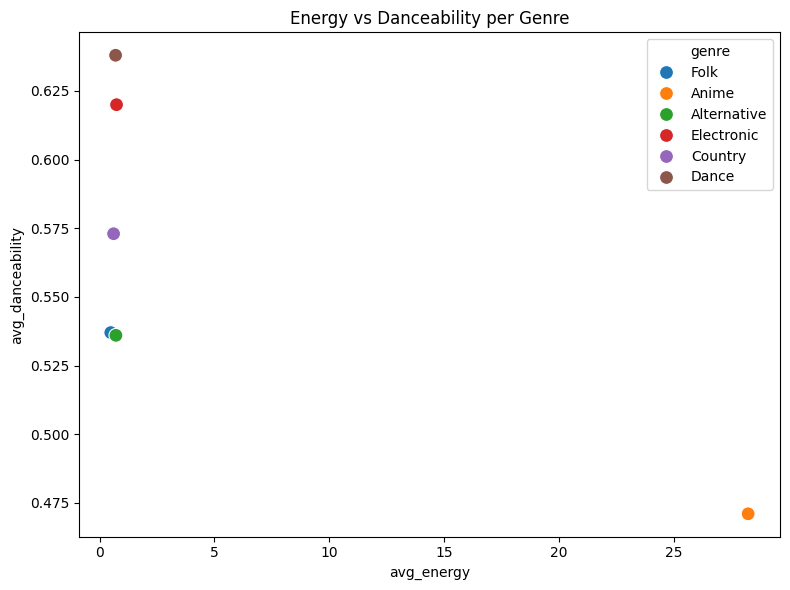

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 295:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


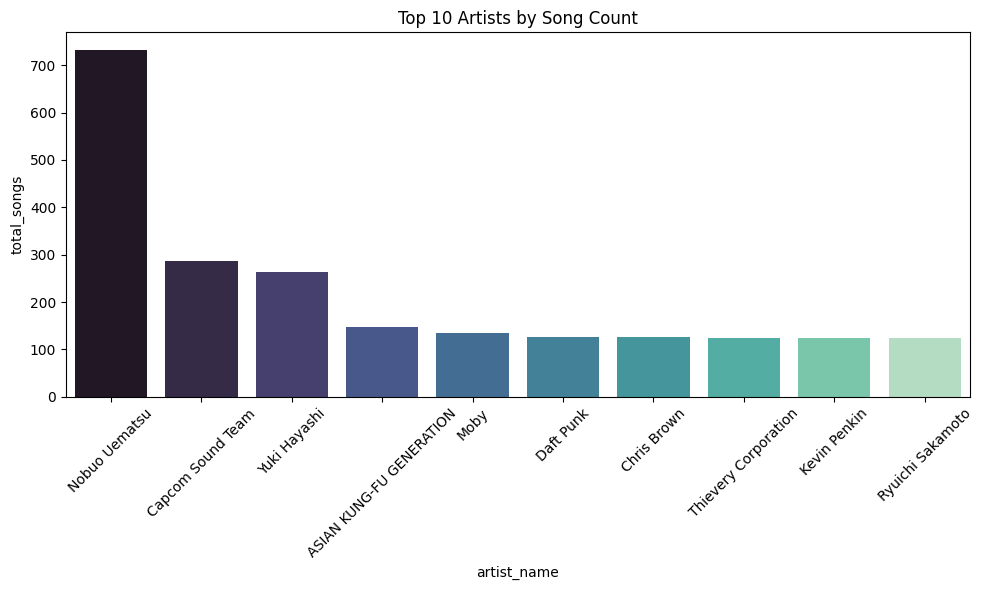

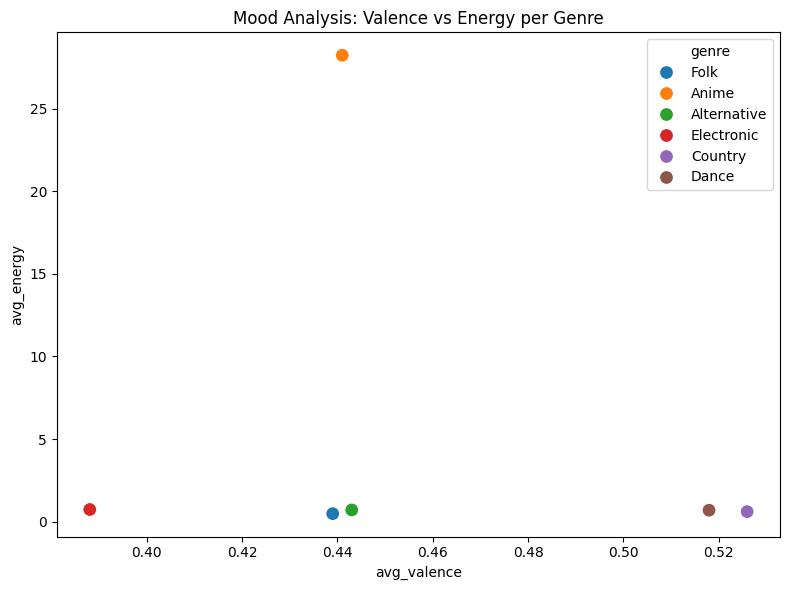

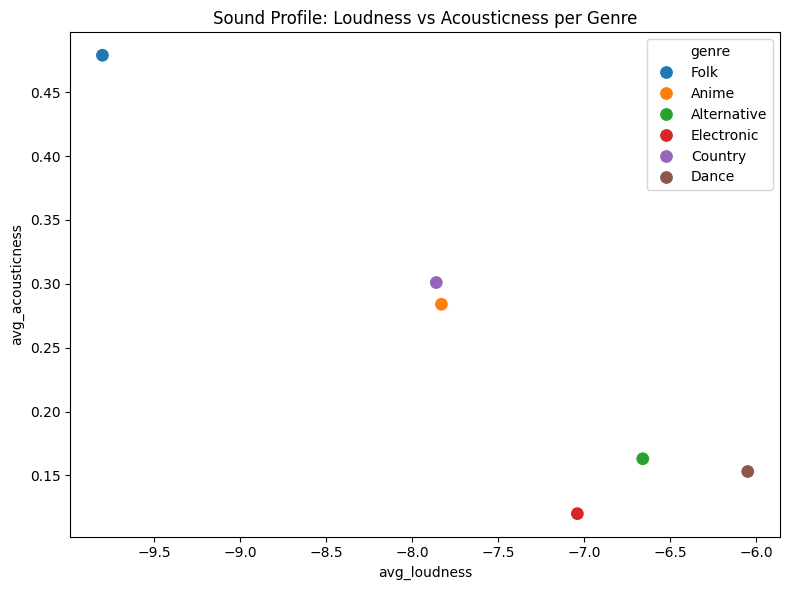

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


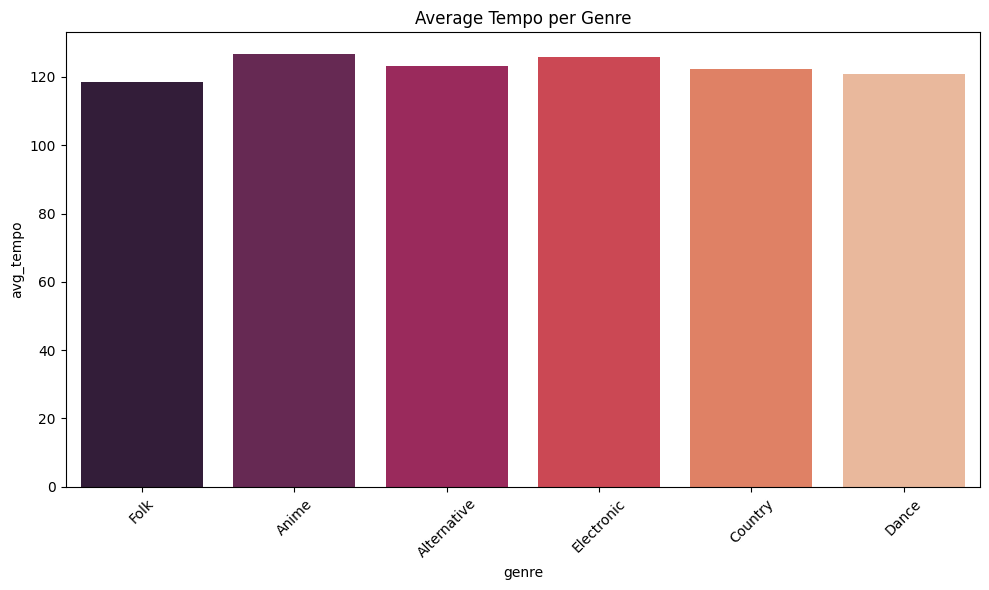

-------------------------------------------
Batch: 22
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Anime      |24.582703708008832|8604 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


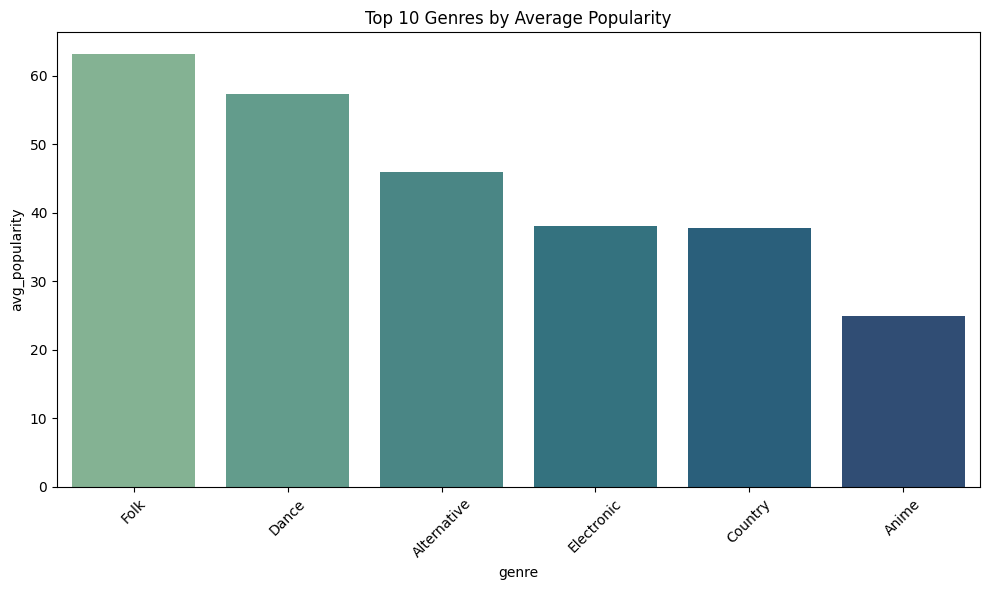

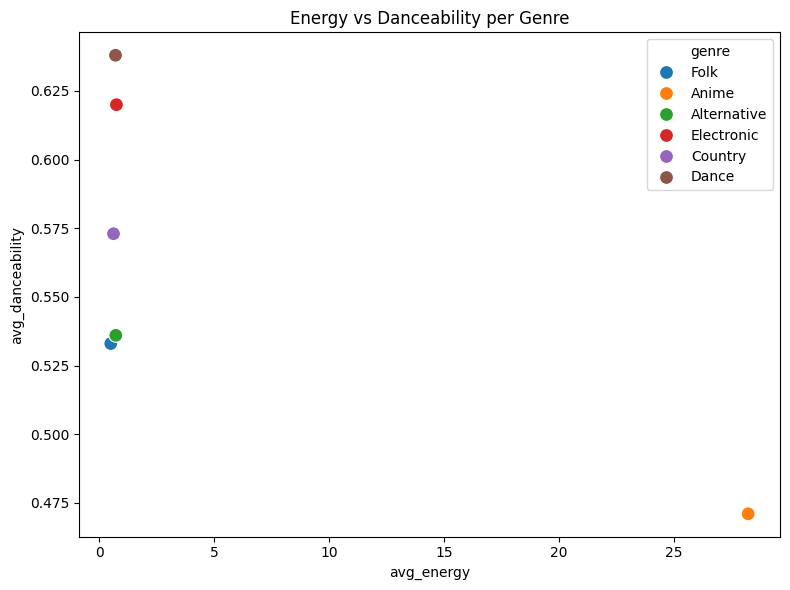

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 311:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


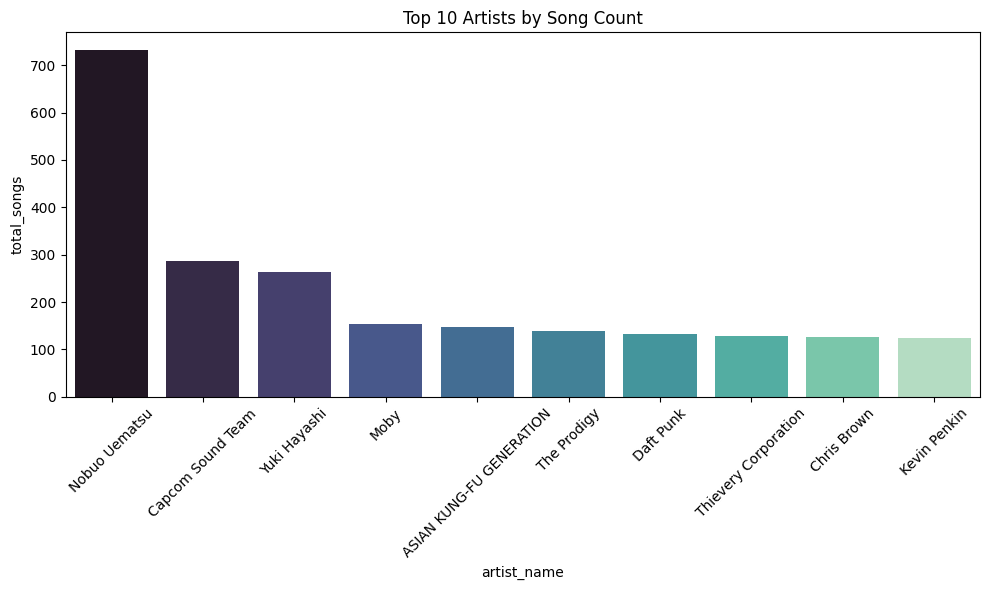

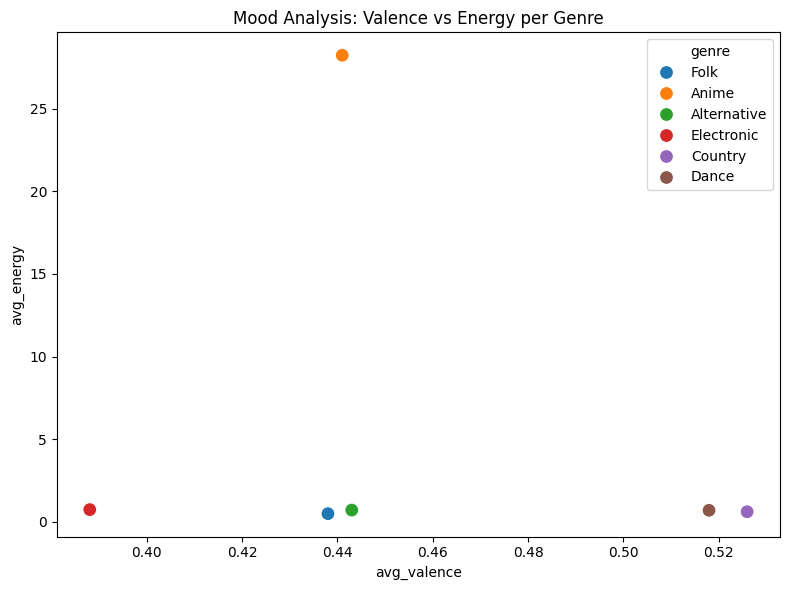

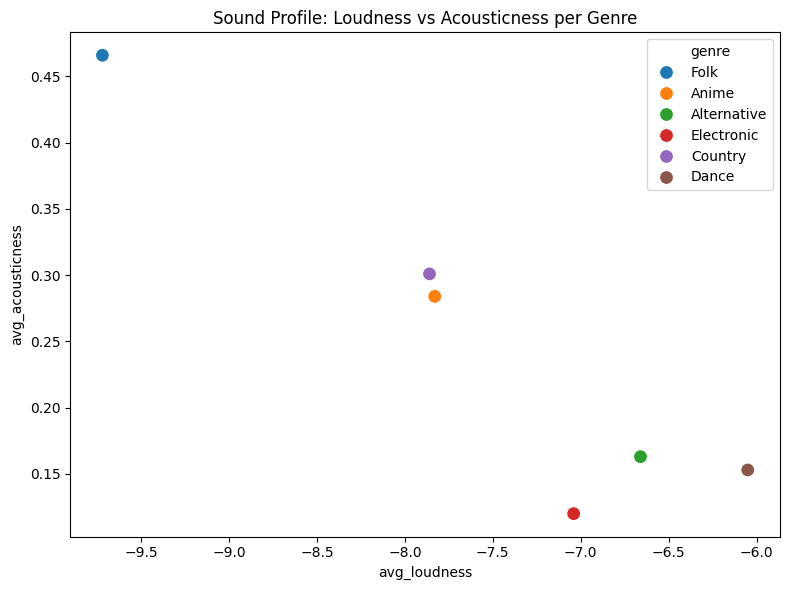

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


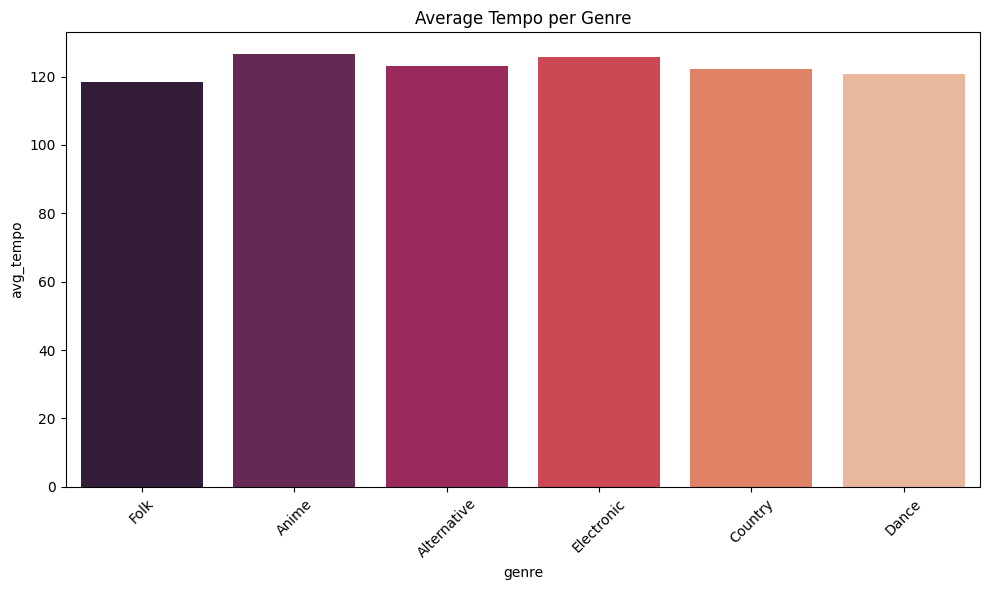

-------------------------------------------
Batch: 23
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |46.54012345679013 |2268 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 325:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


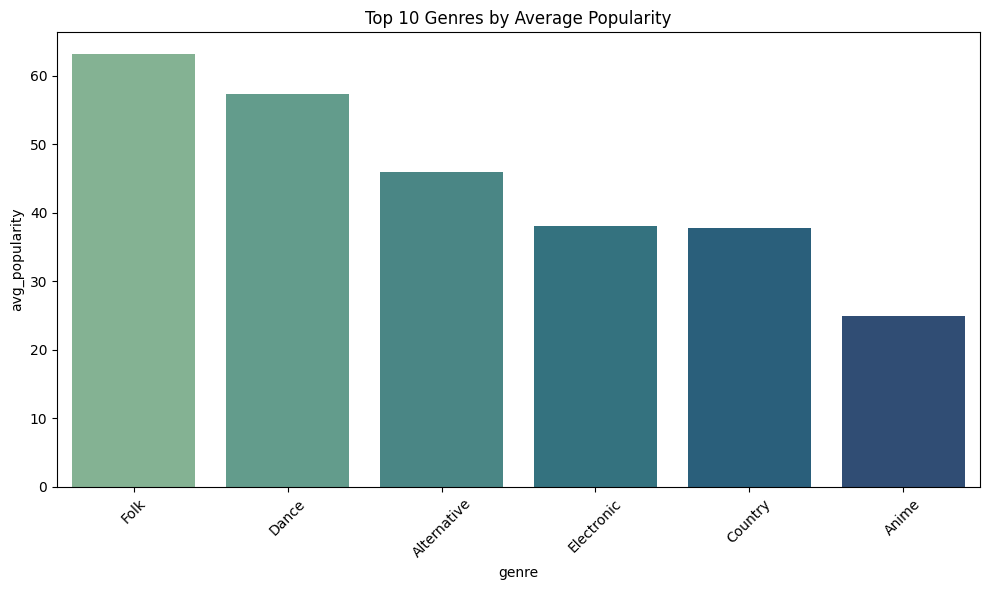

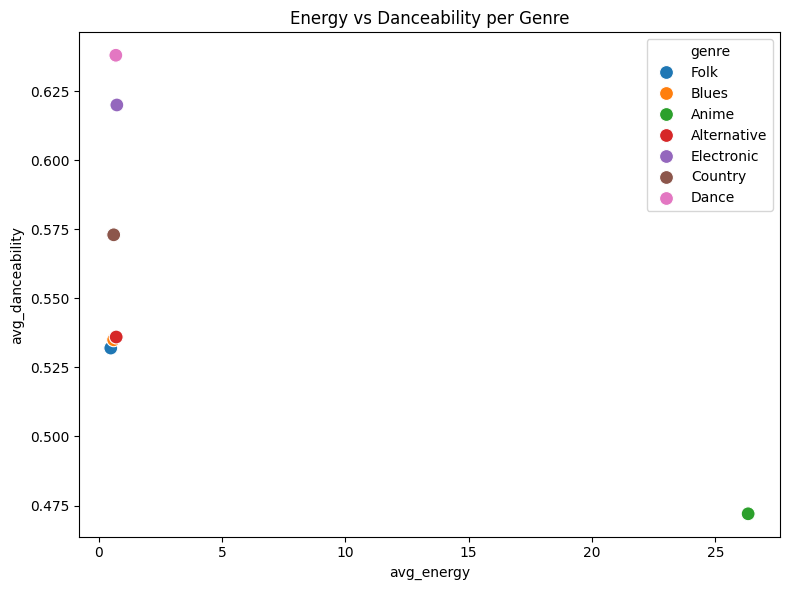

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


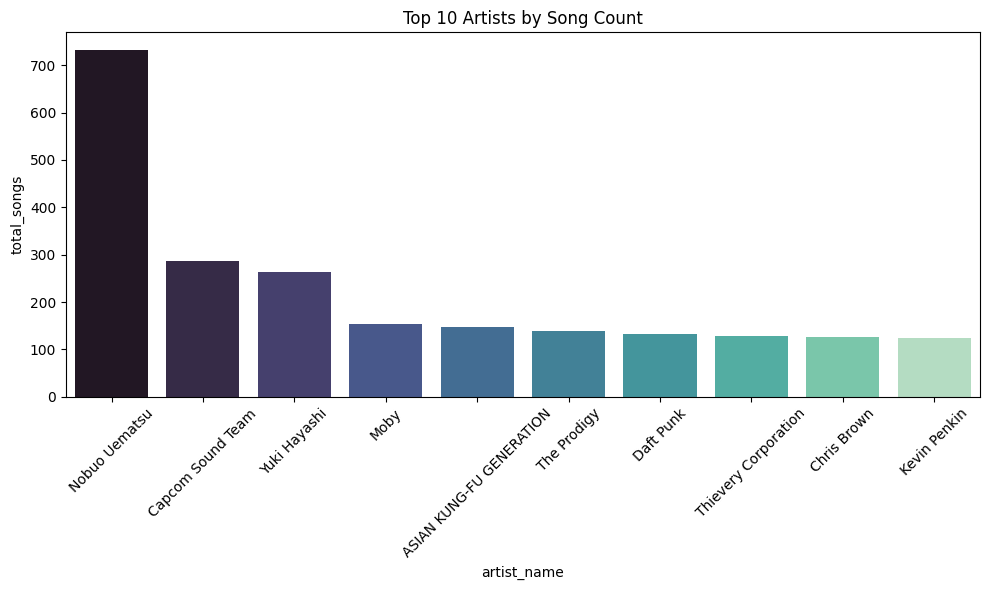

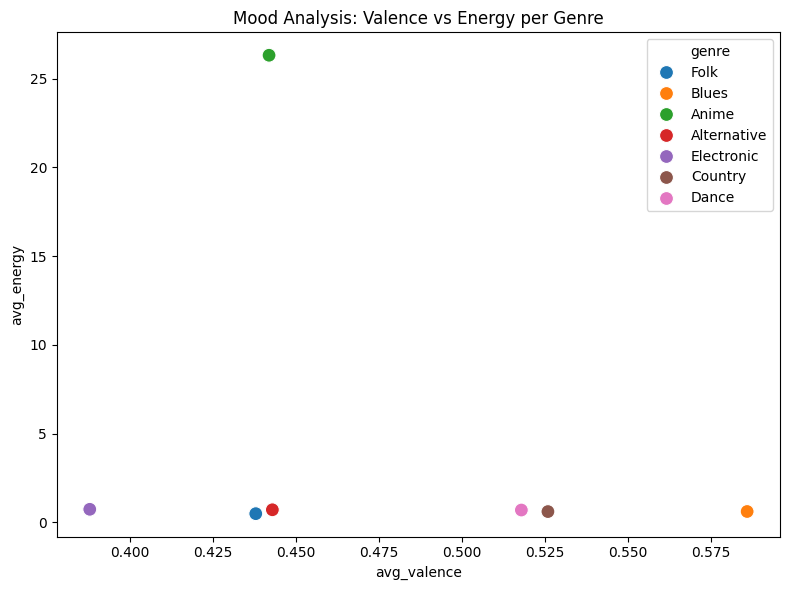

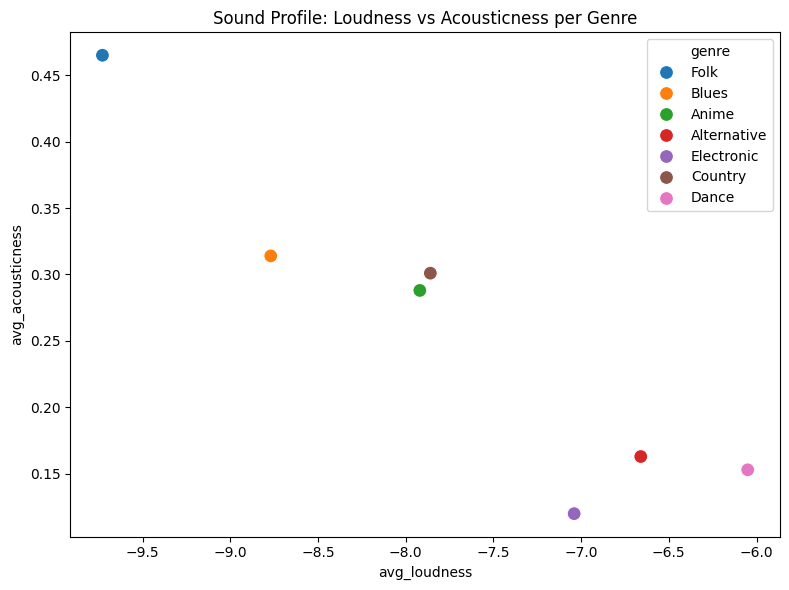

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


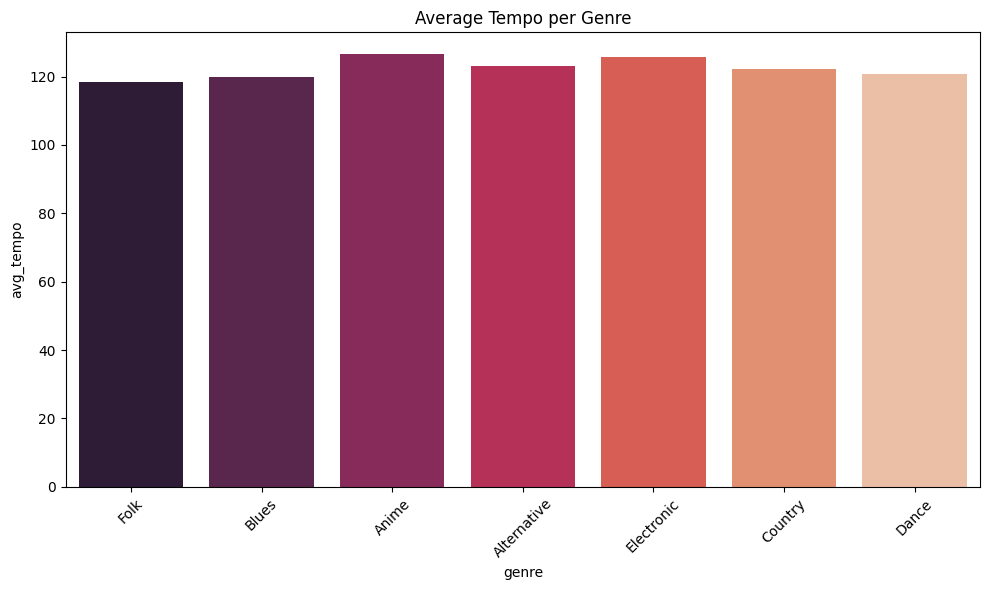

-------------------------------------------
Batch: 24
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |42.126163391933815|3868 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


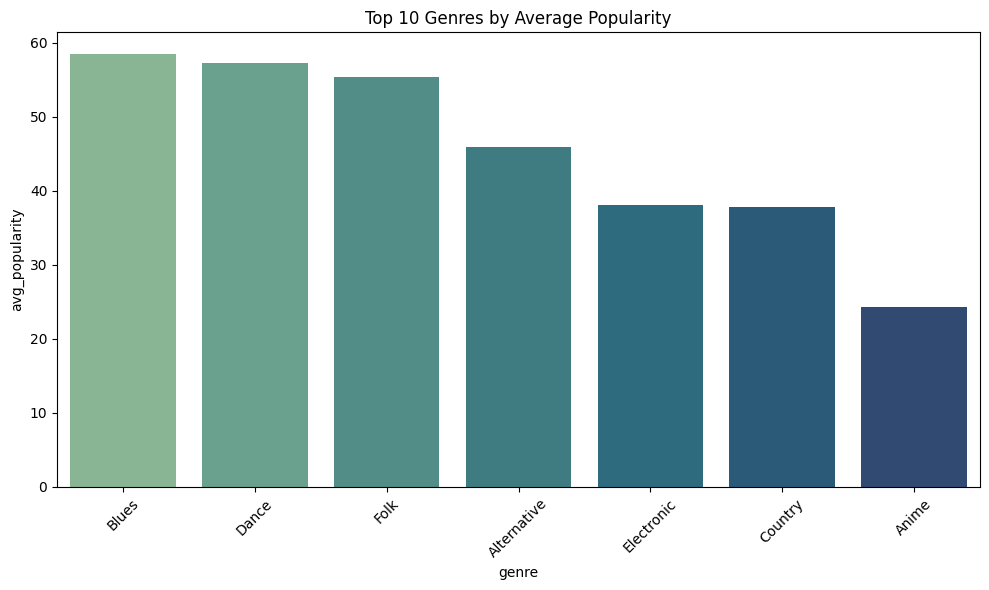

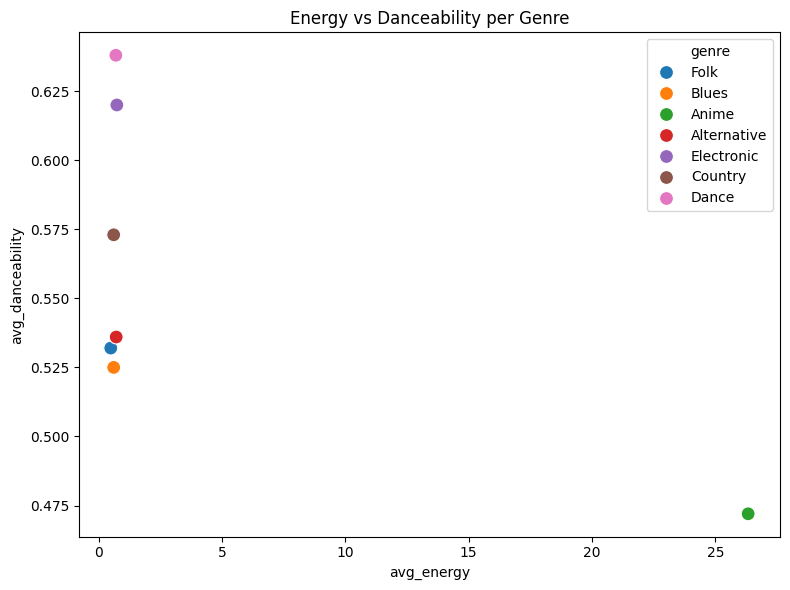

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


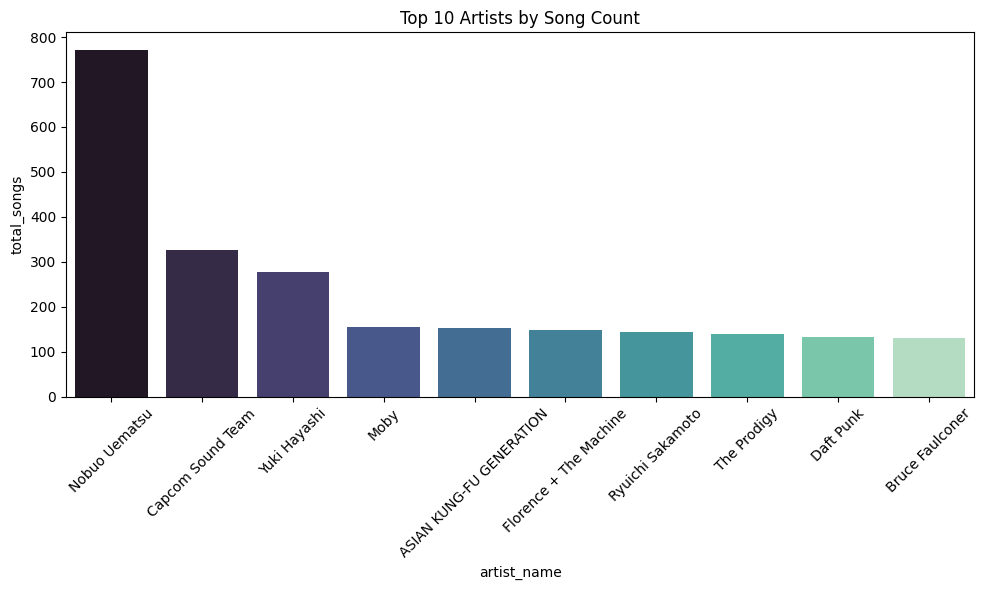

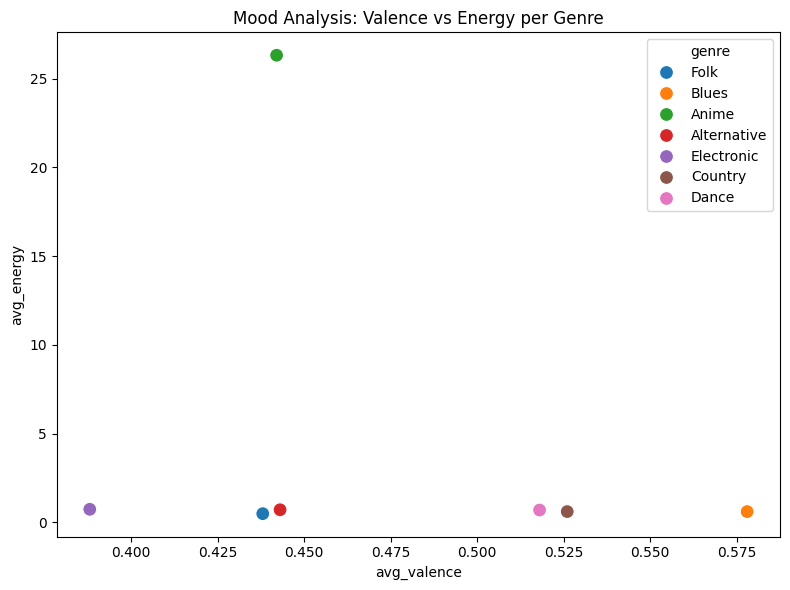

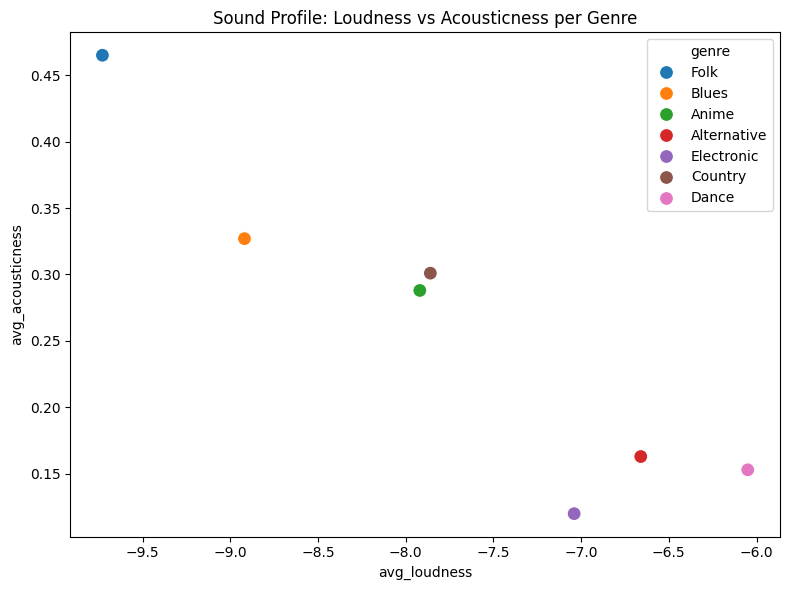

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


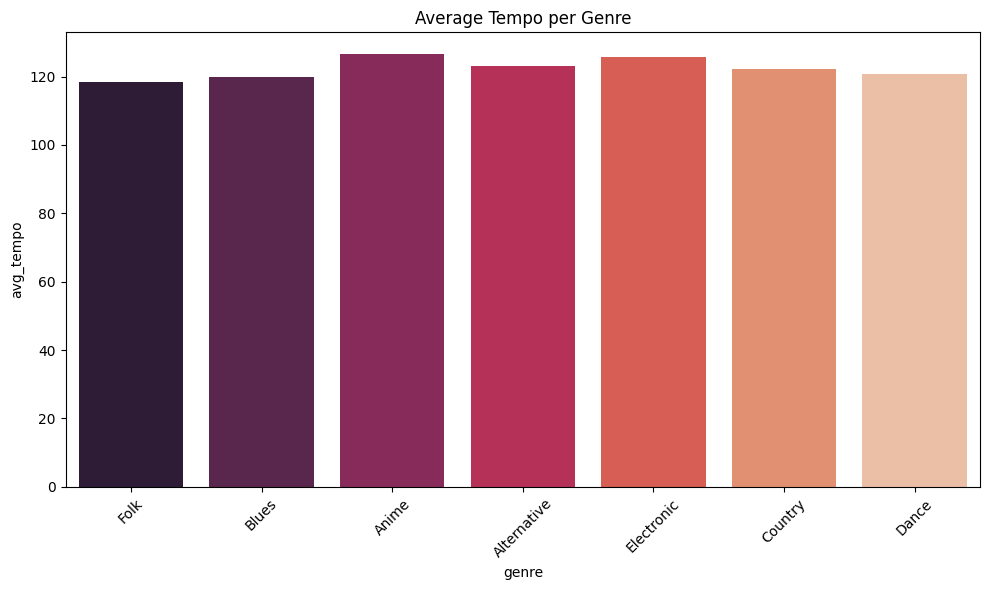

-------------------------------------------
Batch: 25
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |38.0276049146322  |6268 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: age 358:(15 + 0) / 200] 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


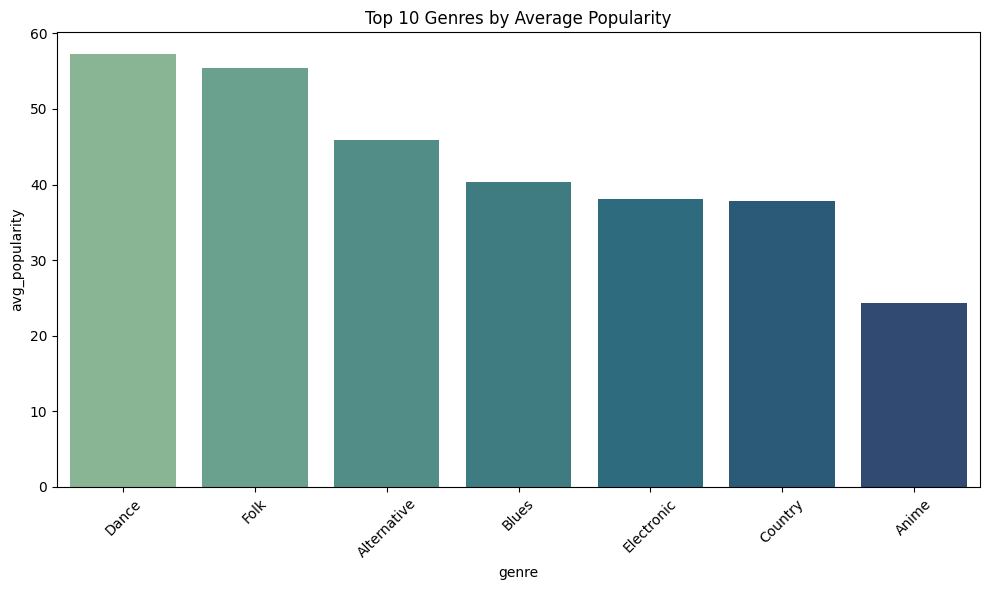

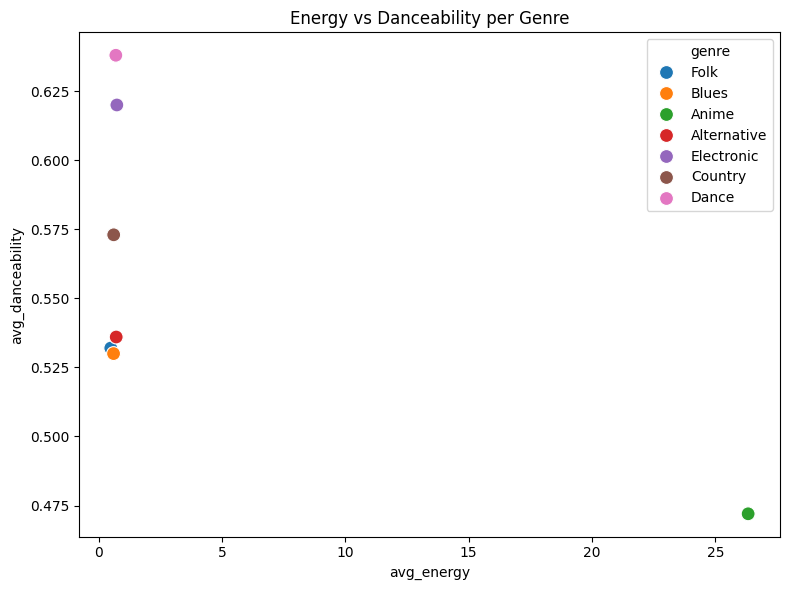

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 358:(15 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


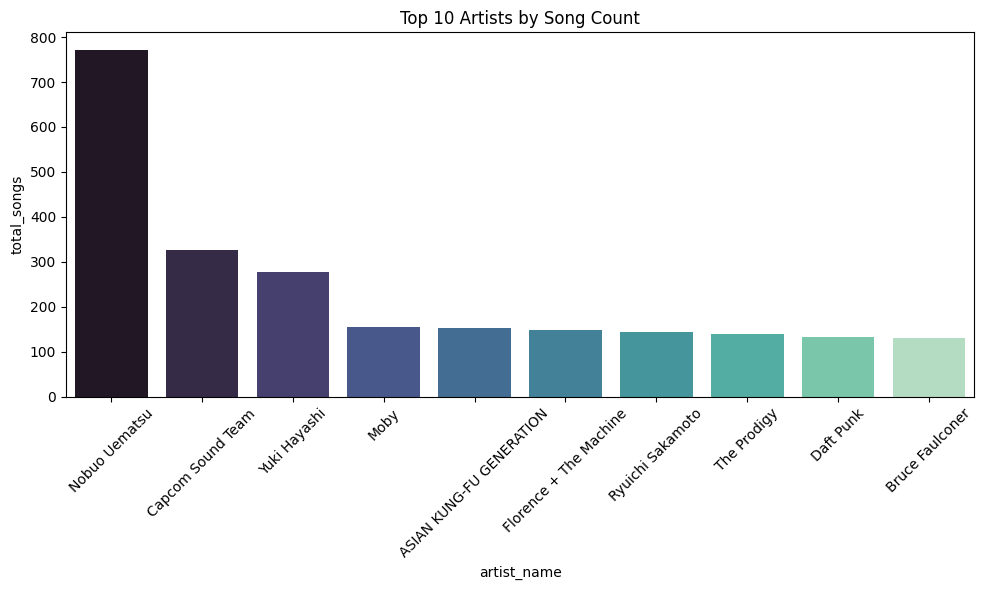

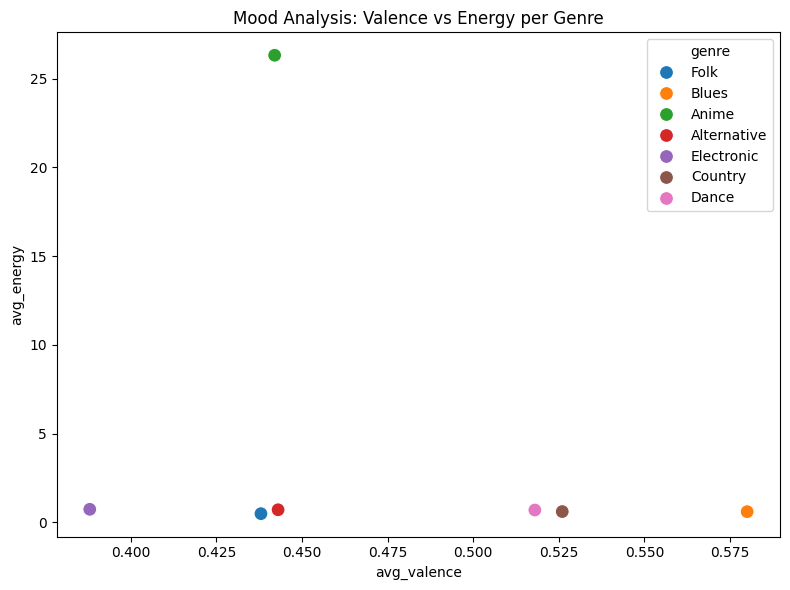

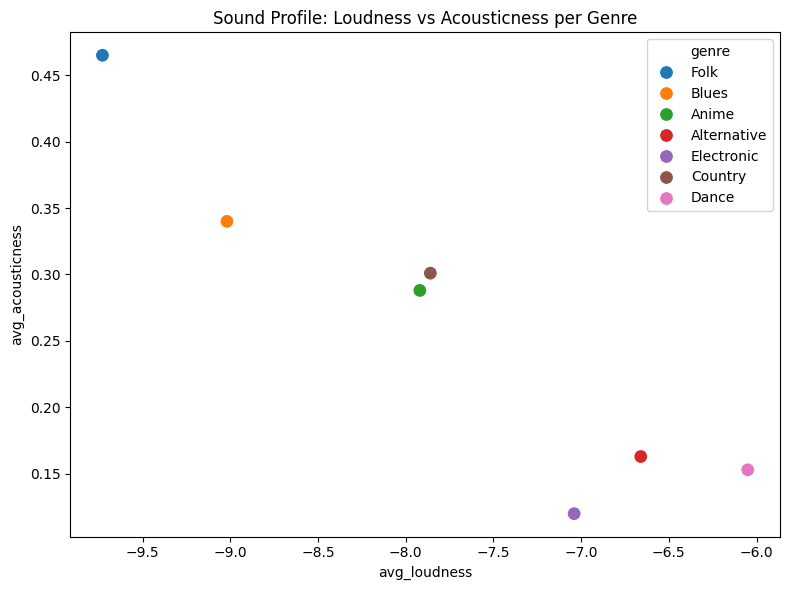

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


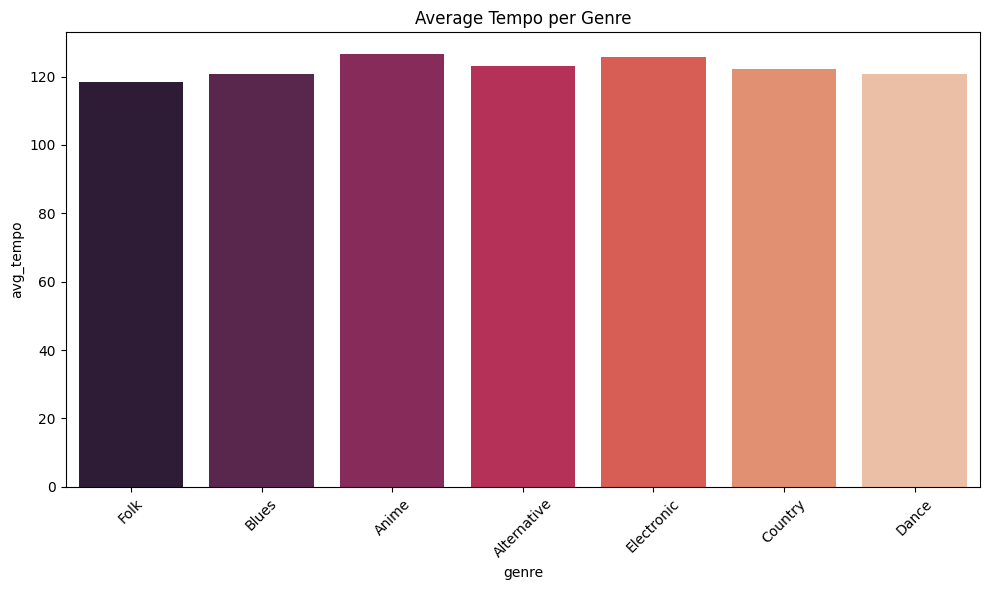

-------------------------------------------
Batch: 26
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |36.0416931485954  |7868 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 372:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


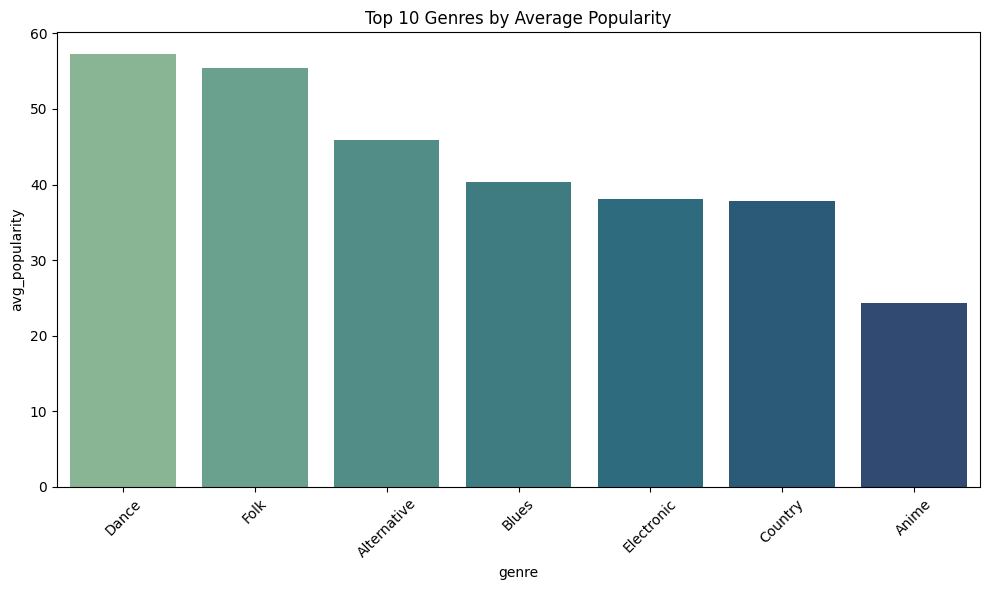

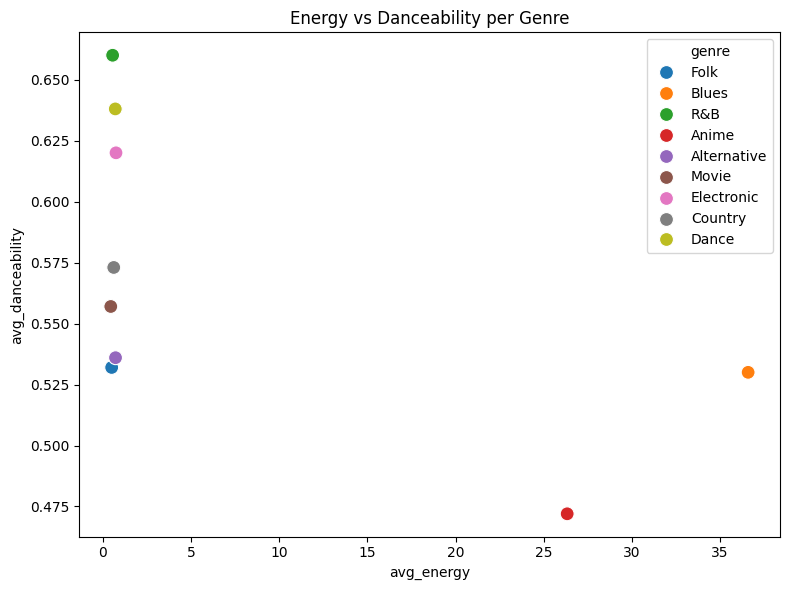

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: ge 374:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


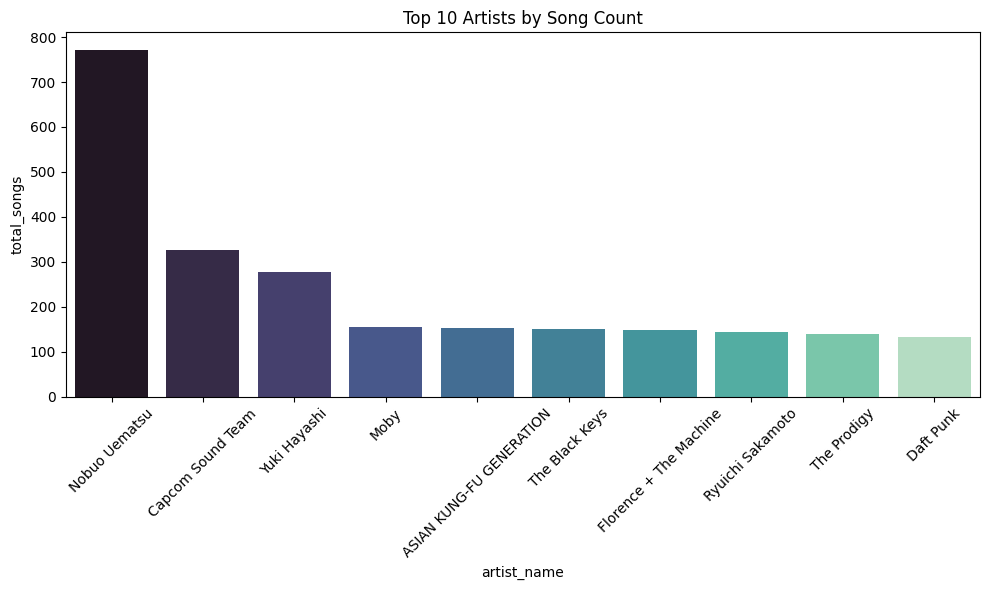

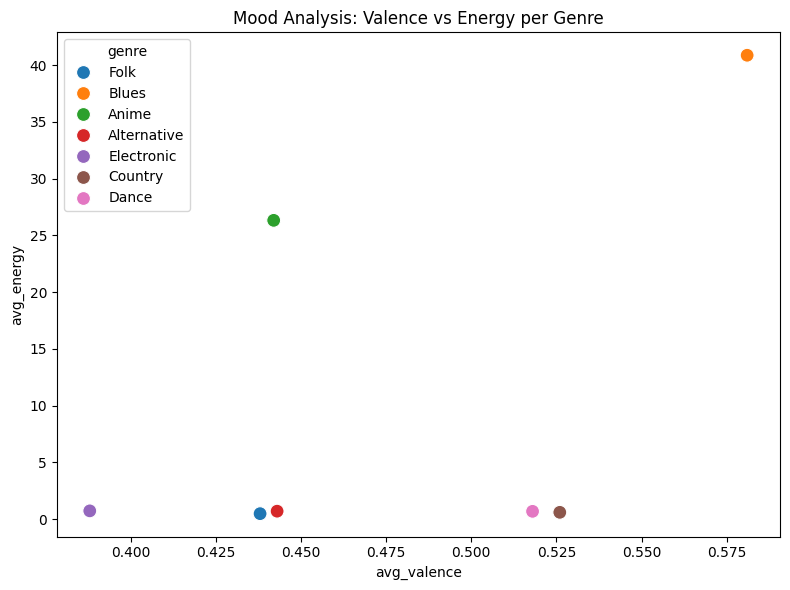

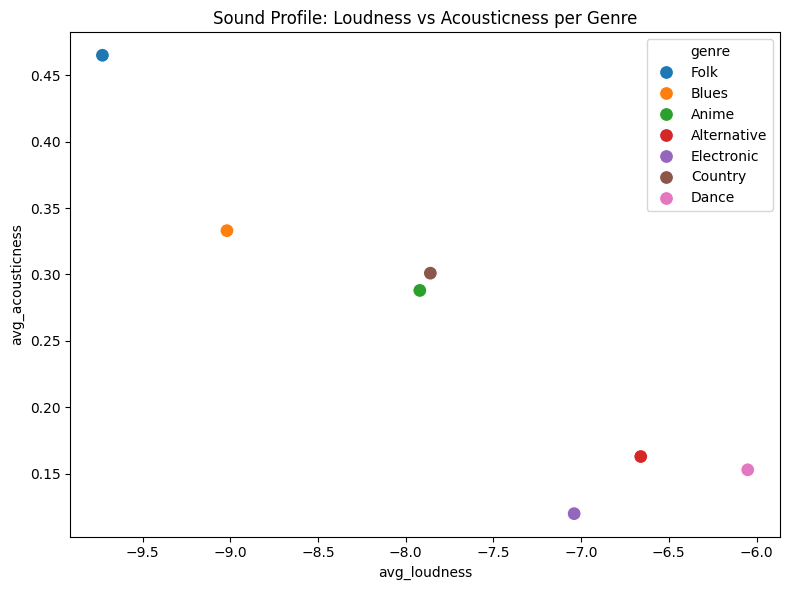

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


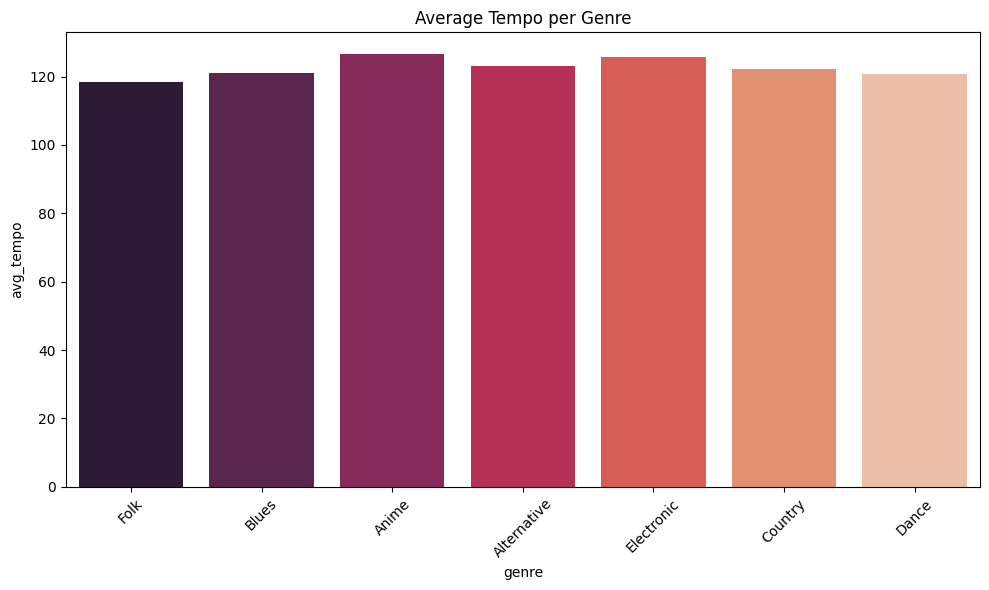

-------------------------------------------
Batch: 27
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |35.59505034574791 |8244 |
|R&B        |62.100294985250734|678  |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Movie      |1.489908256880734 |546  |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 388:>(8 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


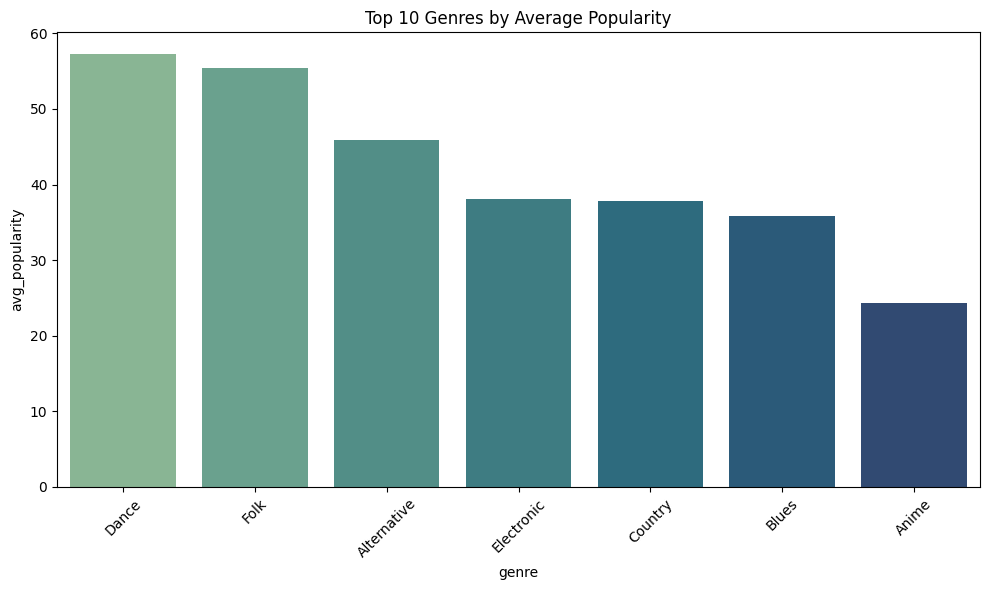

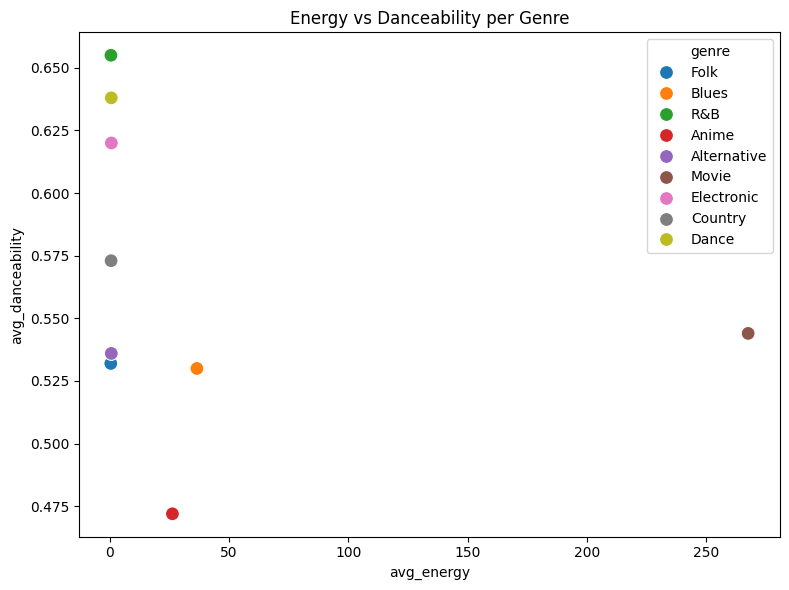

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: ge 390:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


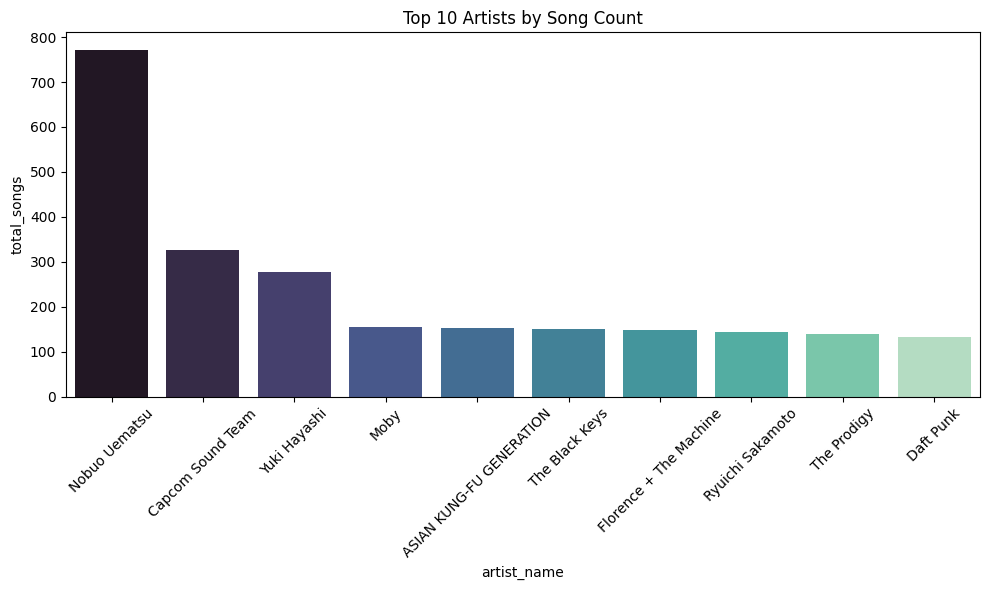

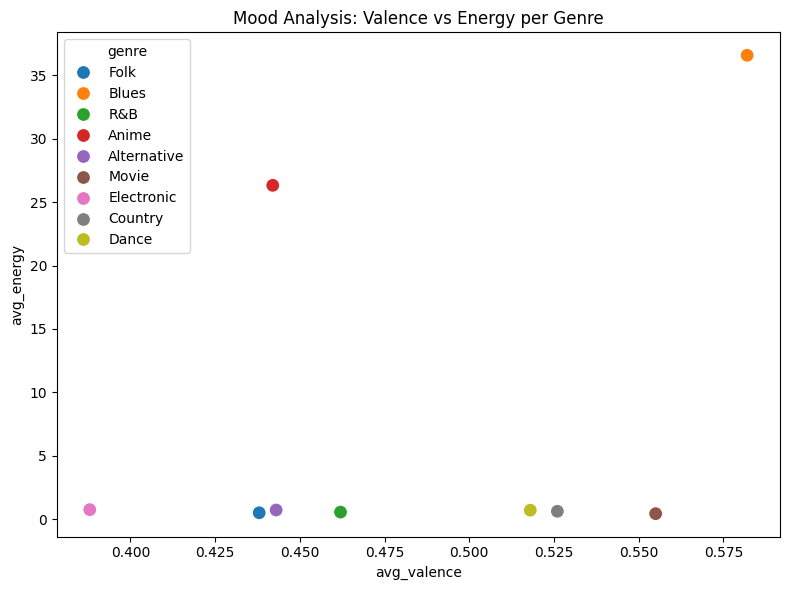

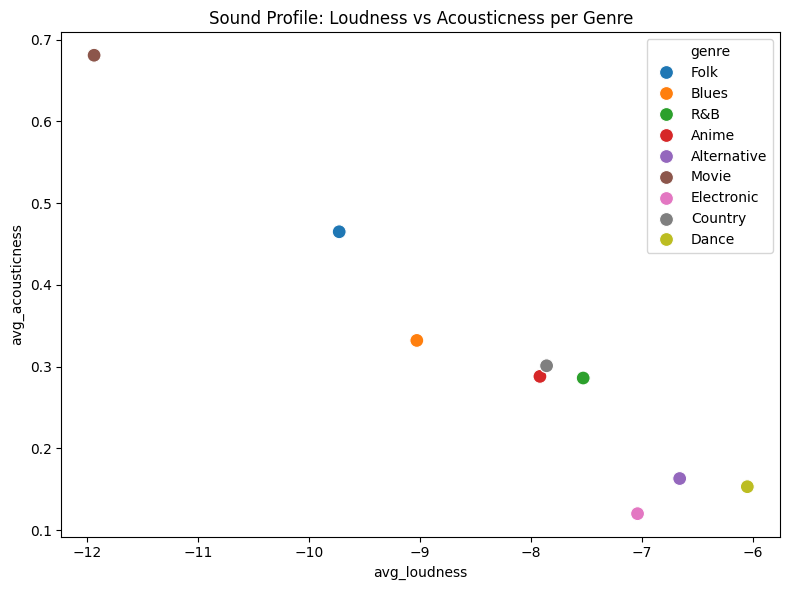

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


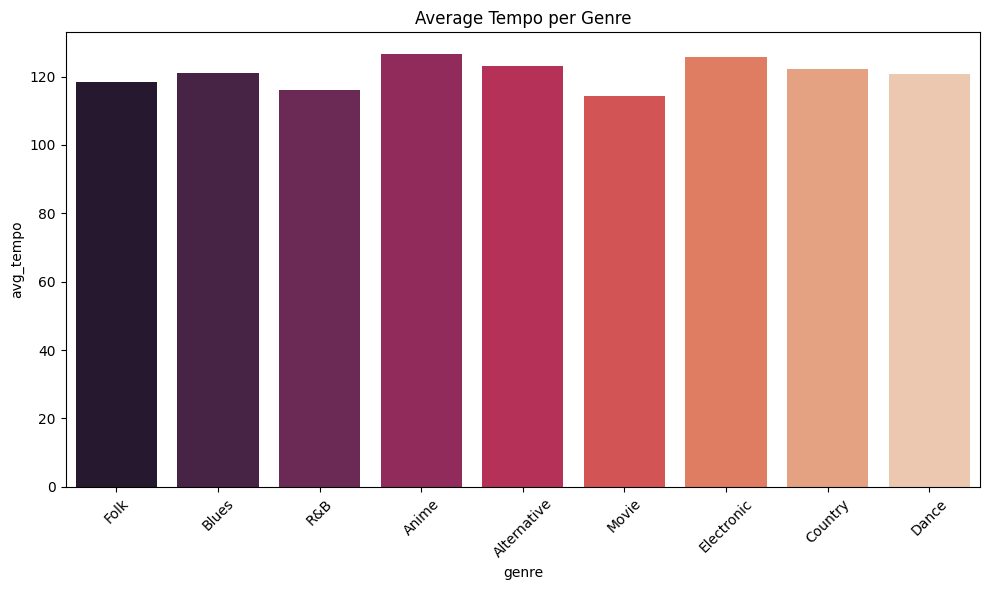

-------------------------------------------
Batch: 28
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |35.59505034574791 |8244 |
|R&B        |58.900151285930406|1983 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Movie      |2.431013431013431 |1641 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 404:>  (0 + 0) / 1]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


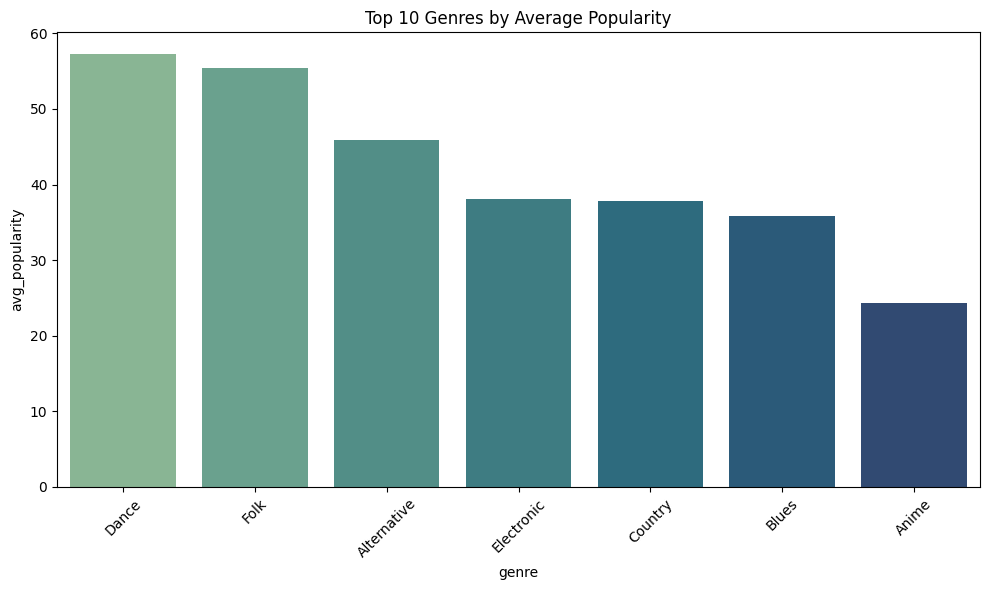

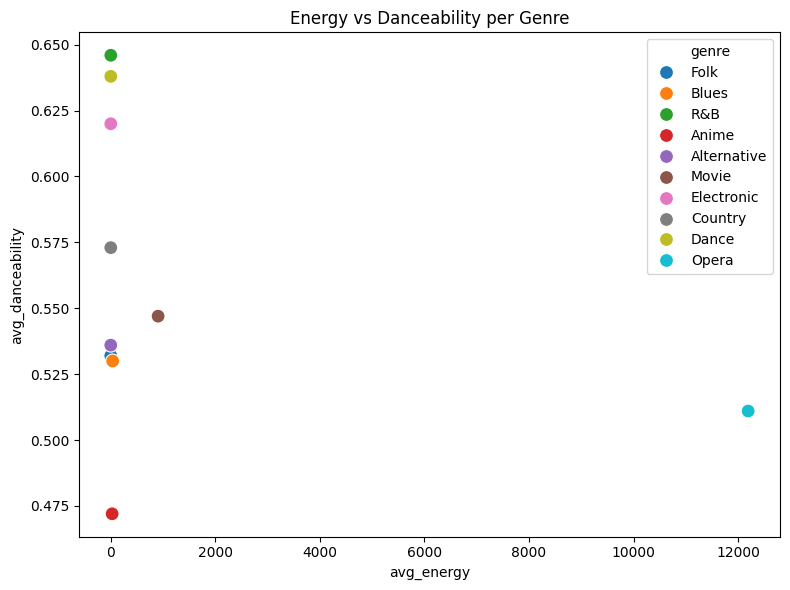

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


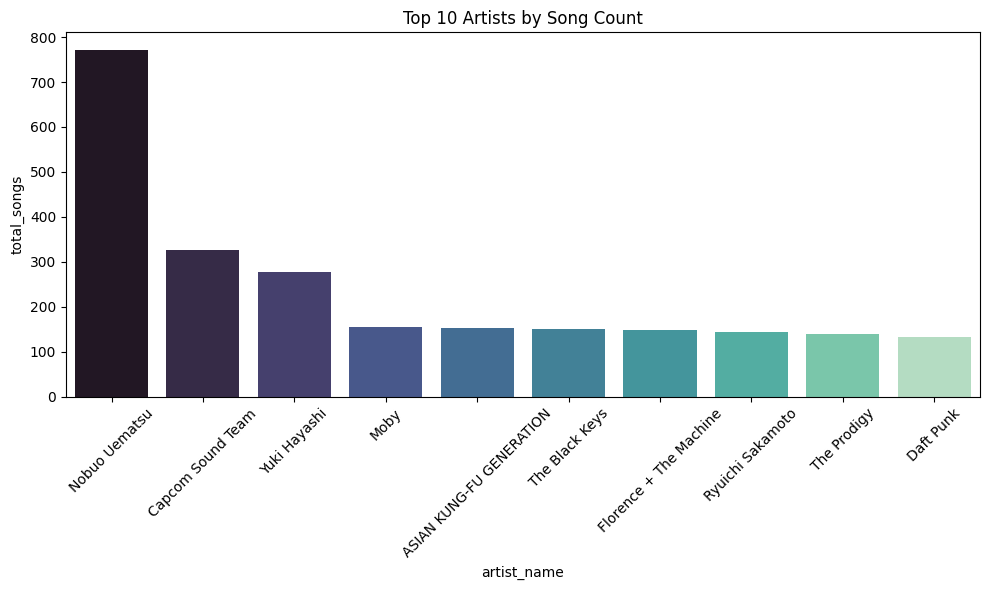

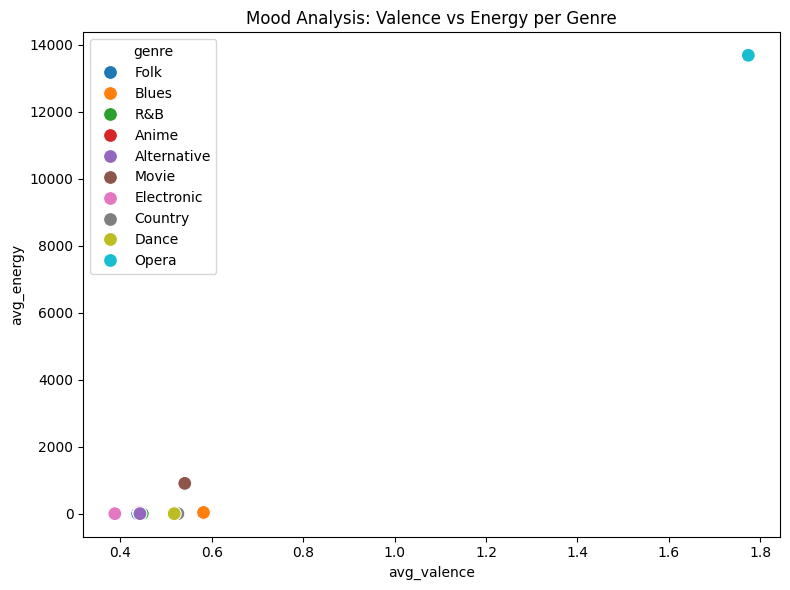

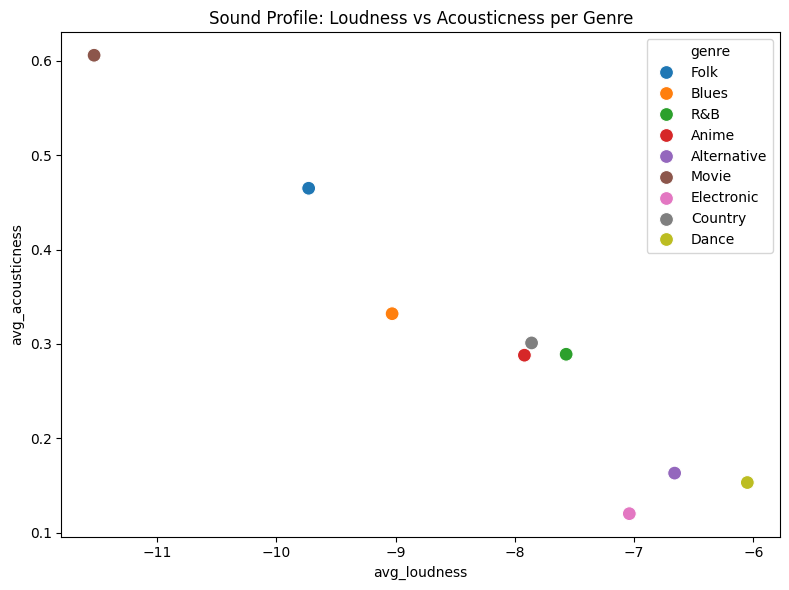

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


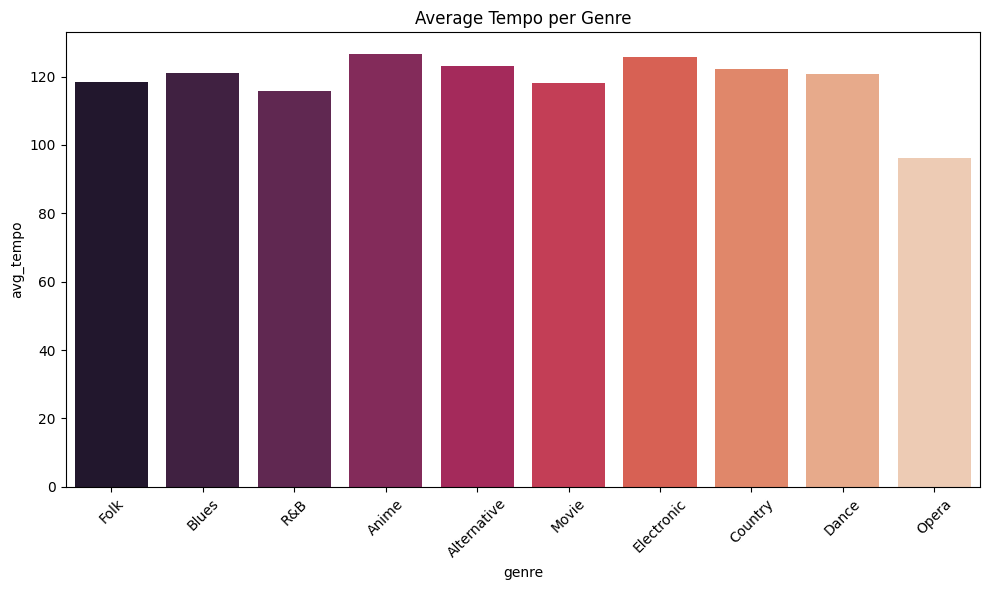

-------------------------------------------
Batch: 29
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |55.3959301039593  |4521 |
|Blues      |35.59505034574791 |8244 |
|R&B        |57.67151607963247 |2612 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Movie      |2.445438282647585 |1680 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
|Opera      |23.429054054054053|1932 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: age 422:>  (0 + 0) / 1] 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


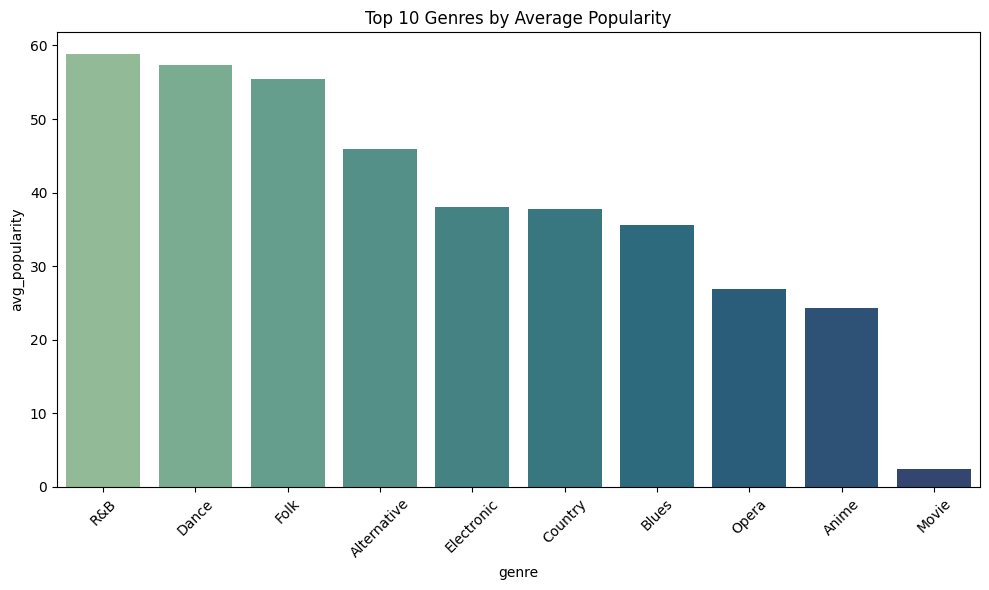

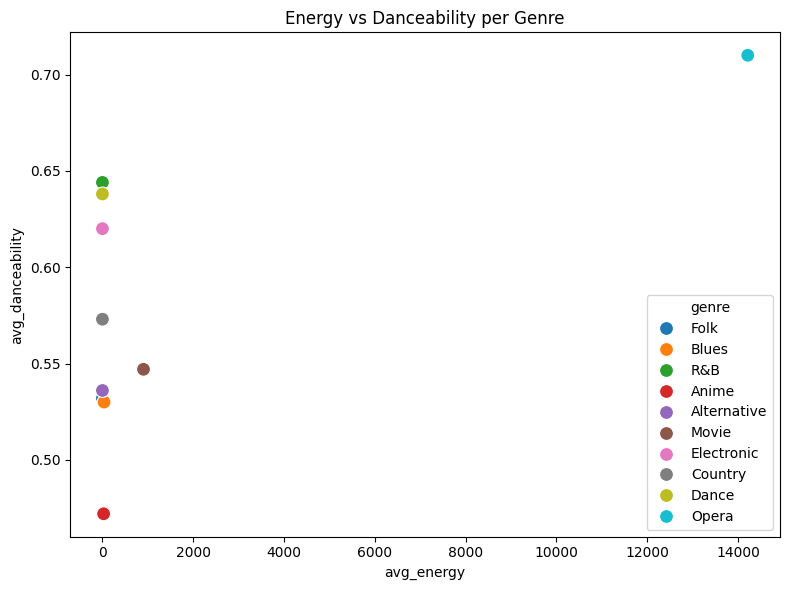

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: ====>  (191 + 9) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


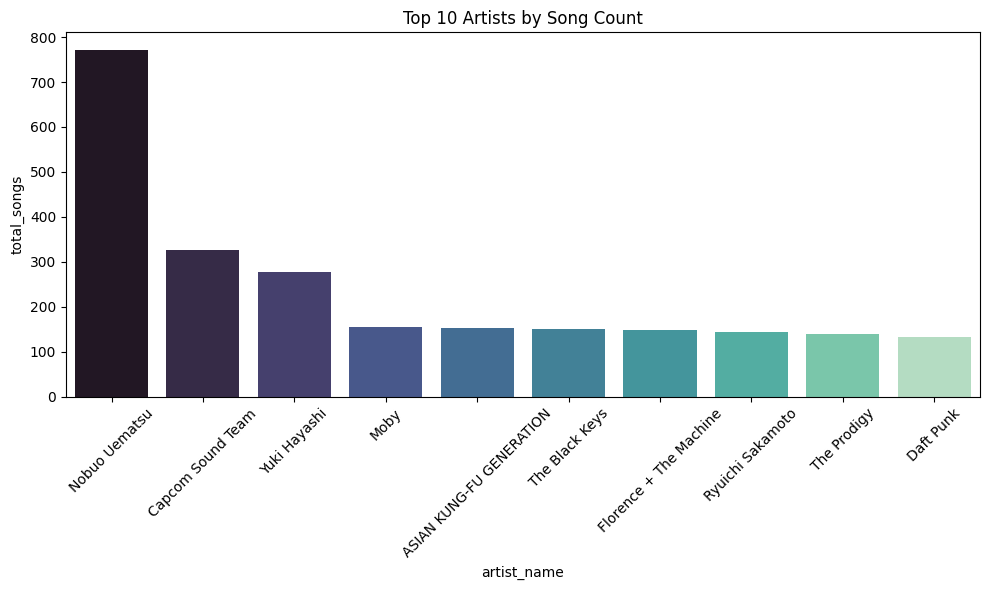

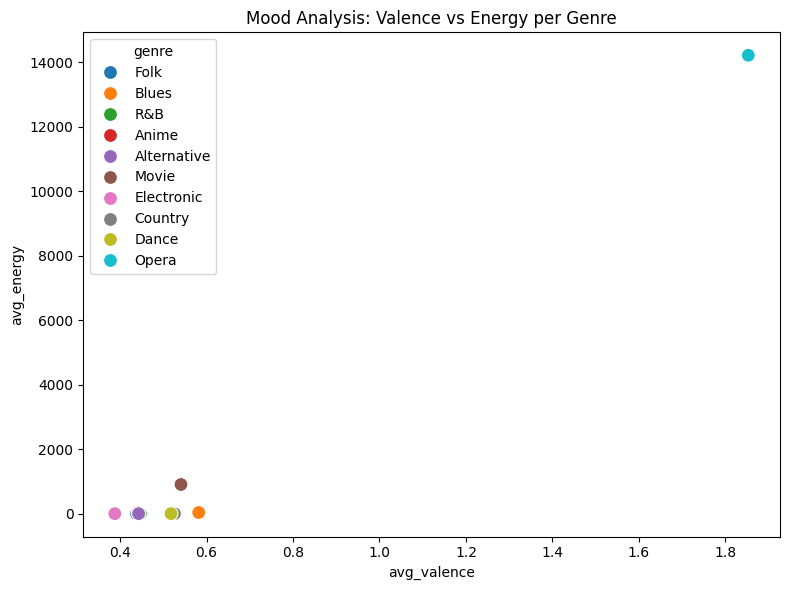

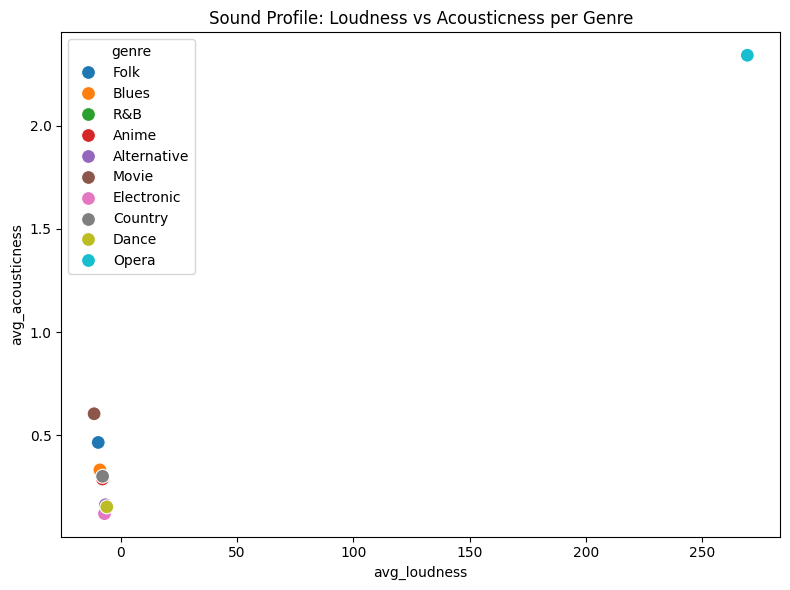

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


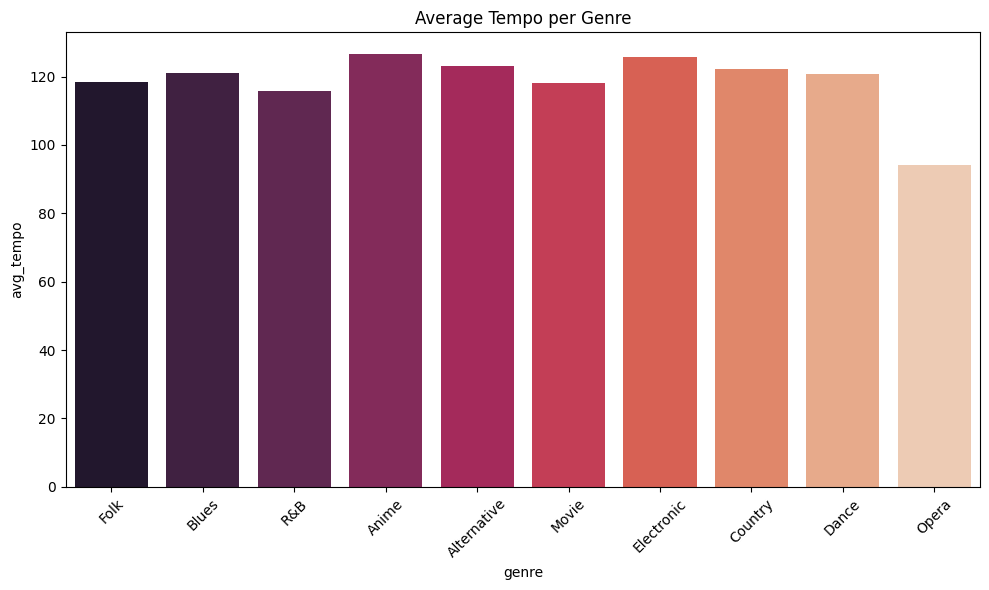

-------------------------------------------
Batch: 30
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |54.69124423963134 |4991 |
|Blues      |35.59505034574791 |8244 |
|R&B        |54.912713035467526|4342 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Movie      |2.445438282647585 |1680 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
|Opera      |23.429054054054053|1932 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning: tage 437:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


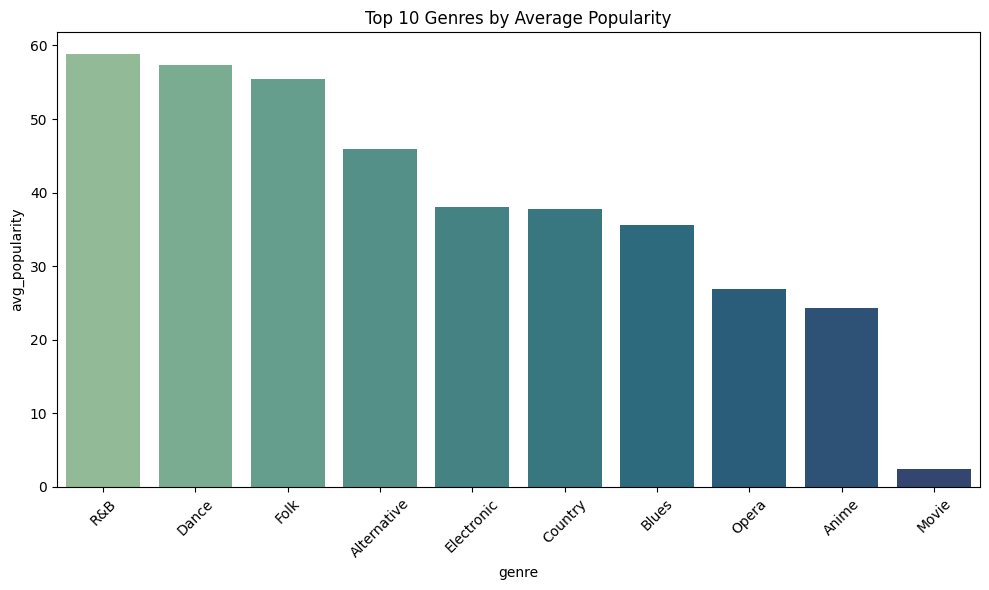

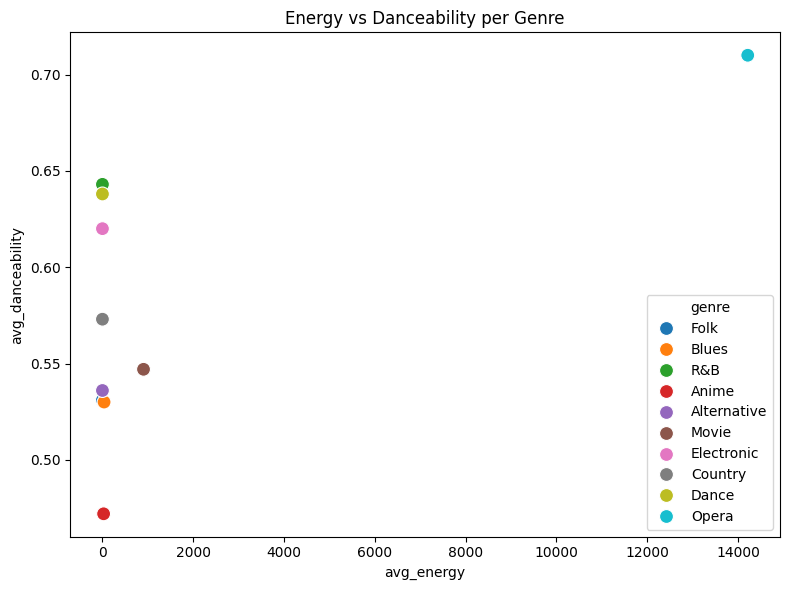

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 439:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


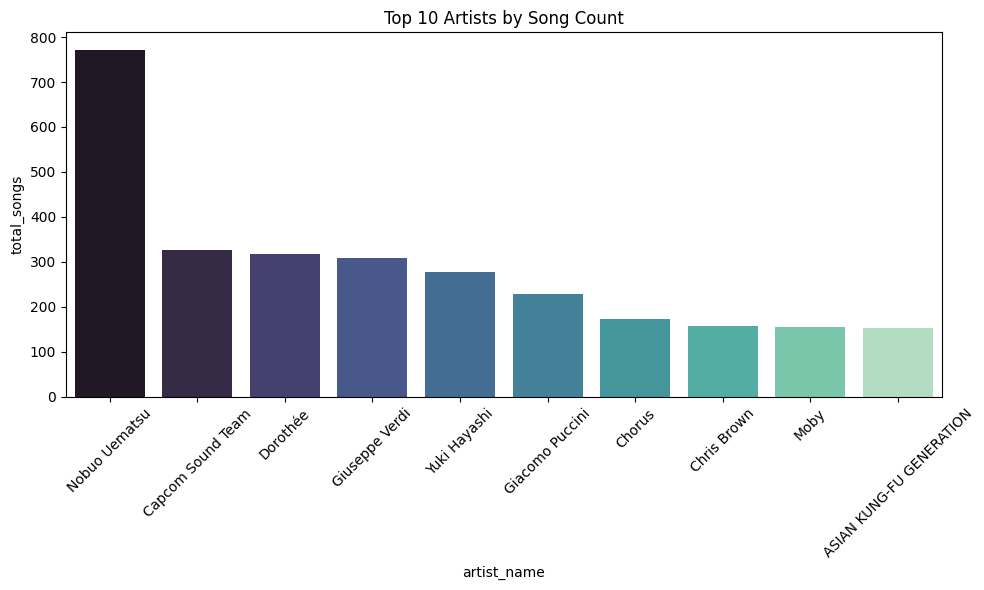

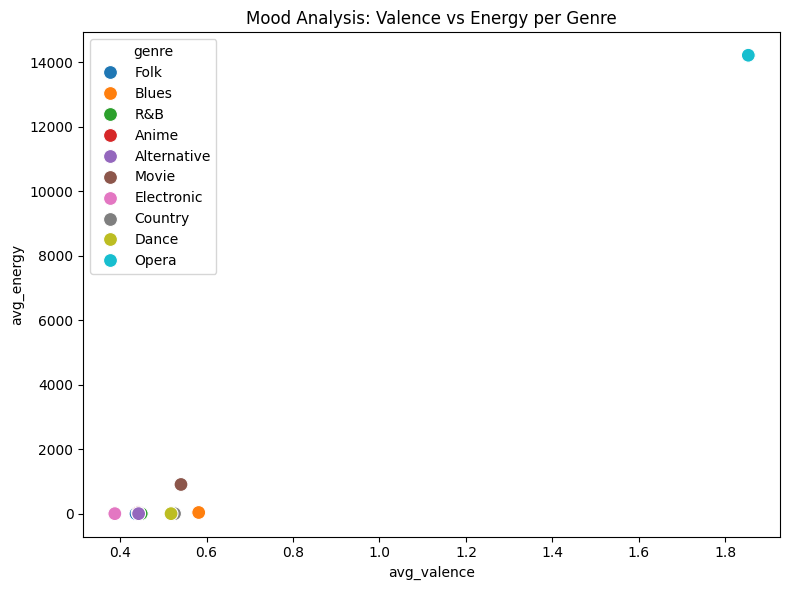

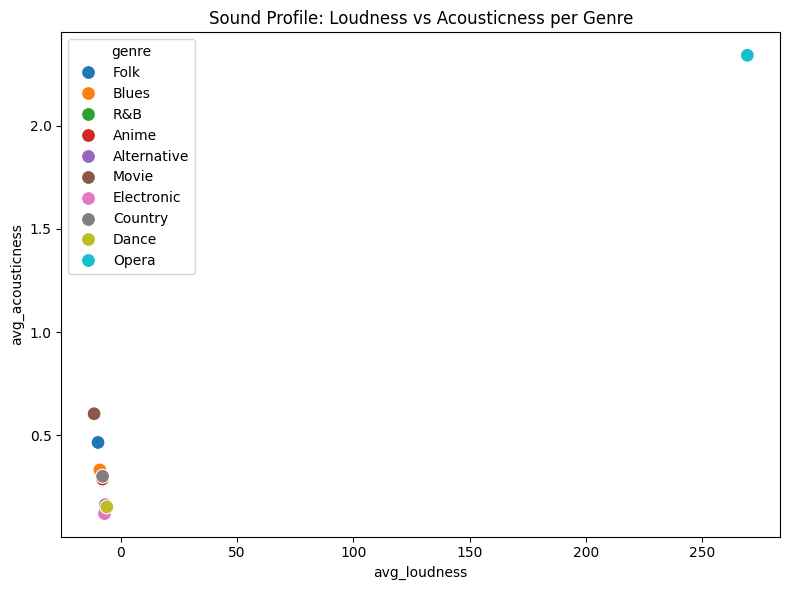

/tmp/ipykernel_1358241/1941357690.py:130: FutureWarning: ge 441:(20 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")


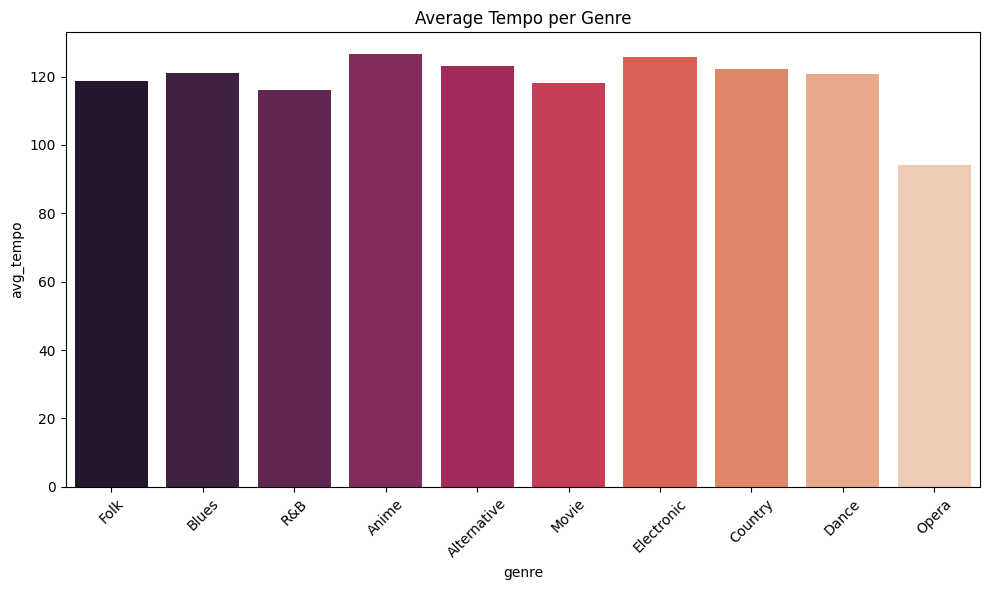

-------------------------------------------
Batch: 31
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |52.182806465455585|6991 |
|Blues      |35.59505034574791 |8244 |
|R&B        |54.912713035467526|4342 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Movie      |2.445438282647585 |1680 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
|Opera      |23.429054054054053|1932 |
+-----------+------------------+-----+



/tmp/ipykernel_1358241/1941357690.py:93: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")


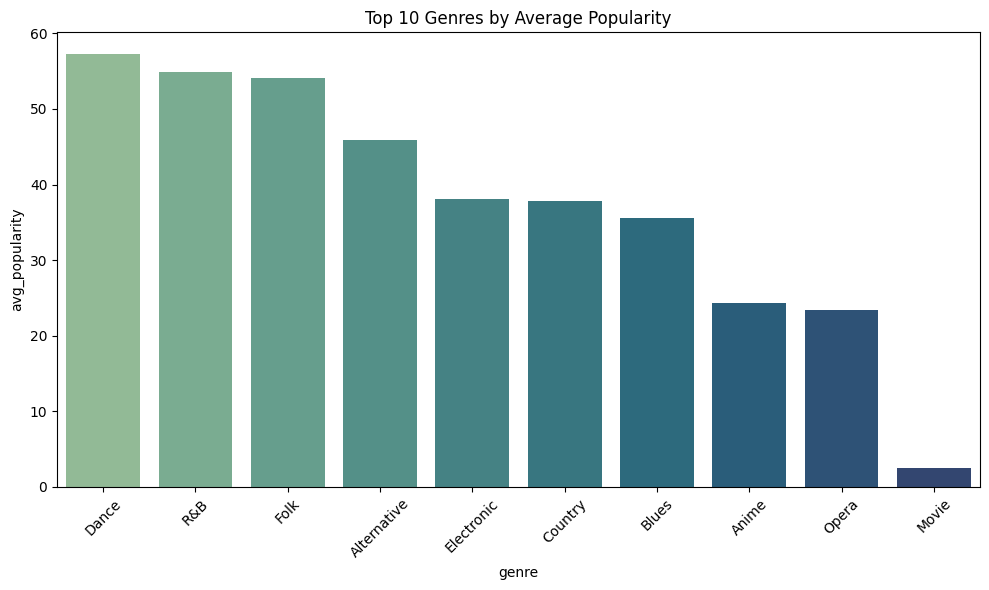

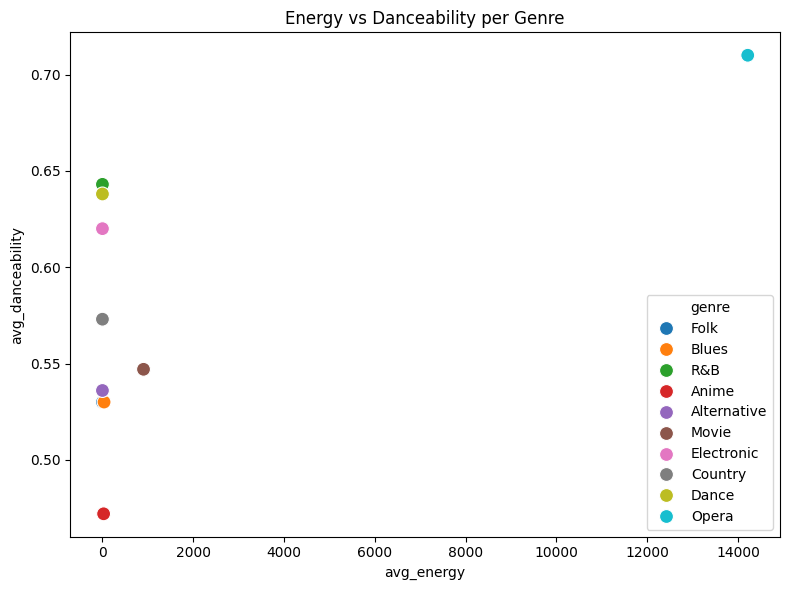

/tmp/ipykernel_1358241/1941357690.py:108: FutureWarning: age 457:>(0 + 0) / 200]

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")


-------------------------------------------
Batch: 32
-------------------------------------------
+-----------+------------------+-----+
|genre      |avg_popularity    |count|
+-----------+------------------+-----+
|Folk       |49.94020862458329 |9299 |
|Blues      |35.59505034574791 |8244 |
|R&B        |54.912713035467526|4342 |
|Anime      |24.2599888080582  |8936 |
|Alternative|47.188814317673376|6705 |
|Movie      |2.445438282647585 |1680 |
|Electronic |38.05609469979738 |9377 |
|Country    |37.90726577437859 |2092 |
|Dance      |57.27525571773359 |8701 |
|Hip-Hop    |84.73913043478261 |92   |
|Opera      |23.429054054054053|1932 |
+-----------+------------------+-----+



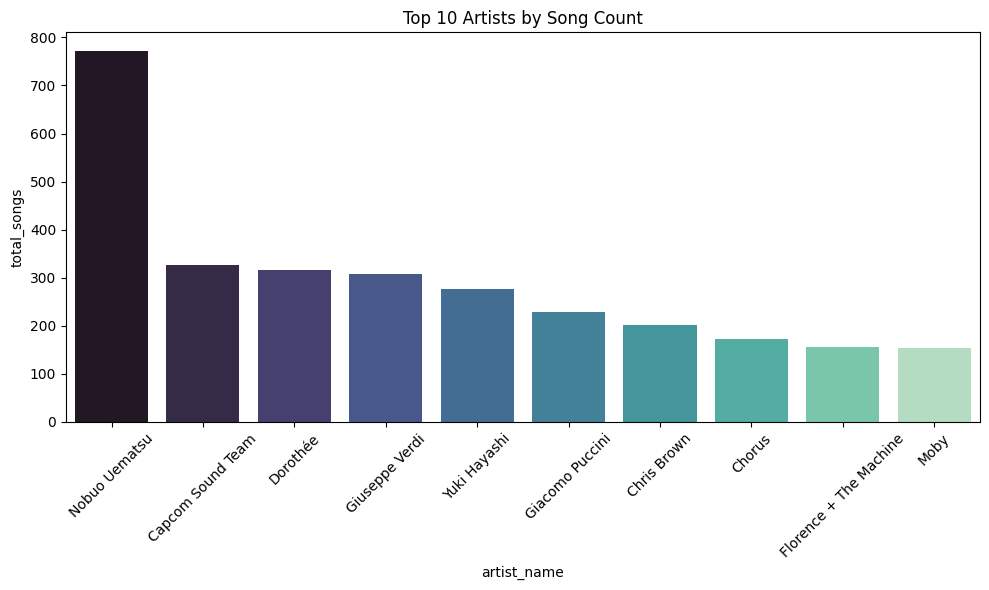

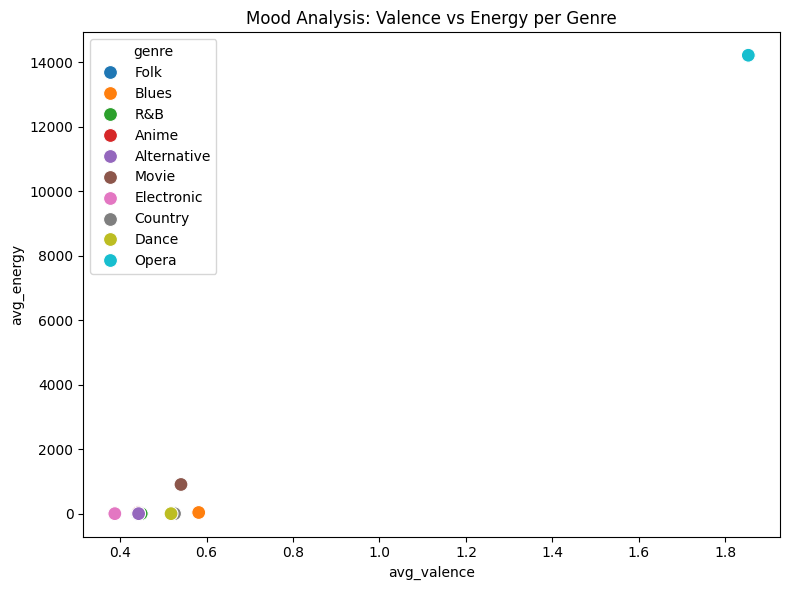

In [ ]:
top_genres = (
    parsed_df.groupBy("genre")
             .agg(_round(avg("popularity"), 2).alias("avg_popularity"))
             .orderBy(col("avg_popularity").desc())
)
q1 = (
    top_genres.writeStream
              .outputMode("complete")
              .format("memory")
              .queryName("top_genres")
              .start()
)

energy_dance = (
    parsed_df.groupBy("genre")
             .agg(
                 _round(avg("energy"), 3).alias("avg_energy"),
                 _round(avg("danceability"), 3).alias("avg_danceability")
             )
)
q2 = (
    energy_dance.writeStream
                .outputMode("complete")
                .format("memory")
                .queryName("energy_dance")
                .start()
)

top_artists = (
    parsed_df.groupBy("artist_name")
             .count()
             .withColumnRenamed("count", "total_songs")
             .orderBy(col("total_songs").desc())
)
q3 = (
    top_artists.writeStream
               .outputMode("complete")
               .format("memory")
               .queryName("top_artists")
               .start()
)

mood_stats = (
    parsed_df.groupBy("genre")
             .agg(
                 _round(avg("valence"), 3).alias("avg_valence"),
                 _round(avg("energy"), 3).alias("avg_energy")
             )
)
q4 = (
    mood_stats.writeStream
              .outputMode("complete")
              .format("memory")
              .queryName("mood_stats")
              .start()
)

sound_profile = (
    parsed_df.groupBy("genre")
             .agg(
                 _round(avg("loudness"), 2).alias("avg_loudness"),
                 _round(avg("acousticness"), 3).alias("avg_acousticness")
             )
)
q5 = (
    sound_profile.writeStream
                 .outputMode("complete")
                 .format("memory")
                 .queryName("sound_profile")
                 .start()
)

tempo_stats = (
    parsed_df.groupBy("genre")
             .agg(
                 _round(avg("tempo"), 2).alias("avg_tempo"),
                 approx_count_distinct("time_signature").alias("unique_time_sigs")
             )
)
q6 = (
    tempo_stats.writeStream
               .outputMode("complete")
               .format("memory")
               .queryName("tempo_stats")
               .start()
)

while True:
    time.sleep(10)

    df1 = spark.sql("SELECT * FROM top_genres").toPandas()
    plt.figure(figsize=(10,6))
    sns.barplot(x="genre", y="avg_popularity", data=df1.head(10), palette="crest")
    plt.title("Top 10 Genres by Average Popularity")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    df2 = spark.sql("SELECT * FROM energy_dance").toPandas()
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df2, x="avg_energy", y="avg_danceability", hue="genre", s=100)
    plt.title("Energy vs Danceability per Genre")
    plt.tight_layout()
    plt.show()

    df3 = spark.sql("SELECT * FROM top_artists").toPandas()
    plt.figure(figsize=(10,6))
    sns.barplot(data=df3.head(10), x="artist_name", y="total_songs", palette="mako")
    plt.title("Top 10 Artists by Song Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    df4 = spark.sql("SELECT * FROM mood_stats").toPandas()
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df4, x="avg_valence", y="avg_energy", hue="genre", s=100)
    plt.title("Mood Analysis: Valence vs Energy per Genre")
    plt.tight_layout()
    plt.show()

    df5 = spark.sql("SELECT * FROM sound_profile").toPandas()
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df5, x="avg_loudness", y="avg_acousticness", hue="genre", s=100)
    plt.title("Sound Profile: Loudness vs Acousticness per Genre")
    plt.tight_layout()
    plt.show()

    df6 = spark.sql("SELECT * FROM tempo_stats").toPandas()
    plt.figure(figsize=(10,6))
    sns.barplot(data=df6.head(10), x="genre", y="avg_tempo", palette="rocket")
    plt.title("Average Tempo per Genre")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
